In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-data/pollution.csv
/kaggle/input/time-series-data/MaunaLoa.csv
/kaggle/input/time-series-data/WeeklyClosing.csv
/kaggle/input/time-series-data/Emission.csv
/kaggle/input/time-series-data/PortugalPort.csv
/kaggle/input/time-series-data/RetailFood.csv
/kaggle/input/time-series-data/GDPUS.csv
/kaggle/input/time-series-data/WaterConsumption.csv
/kaggle/input/time-series-data/AirPassengers.csv
/kaggle/input/time-series-data/AirPax.csv
/kaggle/input/time-series-data/Gasoline.csv
/kaggle/input/time-series-data/AirTemp.csv
/kaggle/input/time-series-data/GDPIndia.csv
/kaggle/input/time-series-data/daily-min-temperatures.csv
/kaggle/input/time-series-data/wage_growth.csv
/kaggle/input/time-series-data/RetailTurnover.csv
/kaggle/input/time-series-data/MaunaLoa-1.csv
/kaggle/input/time-series-data/Champagne.csv
/kaggle/input/time-series-data/daily-total-female-births.csv
/kaggle/input/time-series-data/CrudeOil.csv
/kaggle/input/time-series-data/shampoo.csv
/kaggle/input/t

In [2]:
# importing additional required libraries
import itertools
import time, json
from io import StringIO
from math import sqrt
from random import seed, random
import matplotlib.pyplot as plt
from datetime import datetime, date
import missingno as msn
import pickle
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.holtwinters as ets
import statsmodels.tools.eval_measures as fa
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Univariate Series

univariate_series = pd.read_csv('/kaggle/input/time-series-data/daily-min-temperatures.csv', header = 0, index_col = 0, parse_dates = True)
univariate_series.squeeze()

univariate_series.head()


Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

Plot the time series data to detect patterns

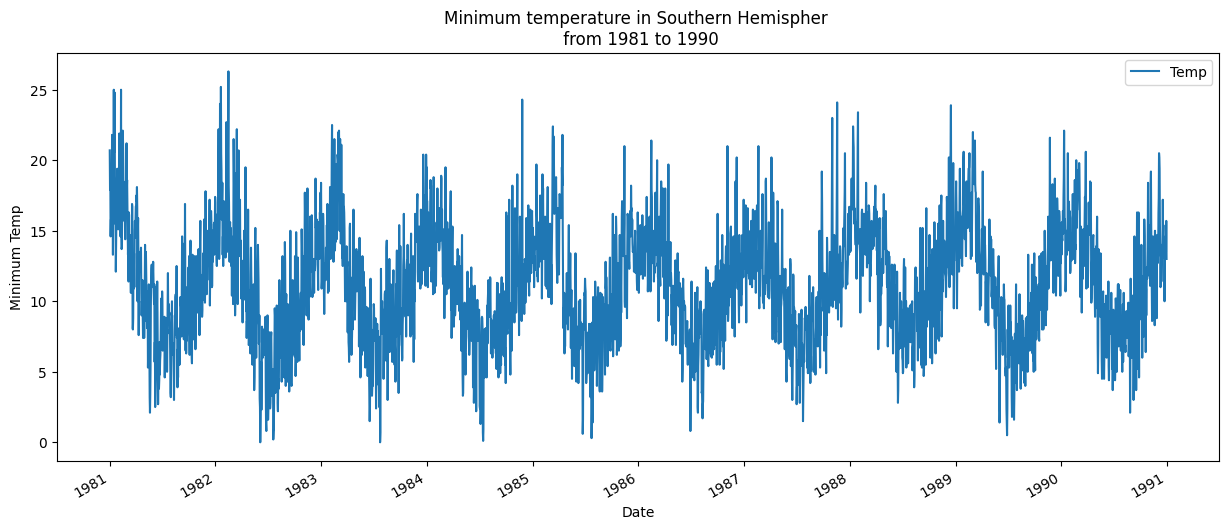

In [4]:
univariate_series.plot()
plt.ylabel('Minimum Temp')
plt.title('Minimum temperature in Southern Hemispher \n from 1981 to 1990')
plt.show()
# we have used only one variable here, Temp 
# hence Univariate Time series Analysis / Forecasting

# Air pollution forecasting

### Exploring the dataset

In [5]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

pollution_df = pd.read_csv('/kaggle/input/time-series-data/pollution.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
pollution_df.head()

No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0

In [6]:
pollution_df.isnull().sum()

No          0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

<Axes: >

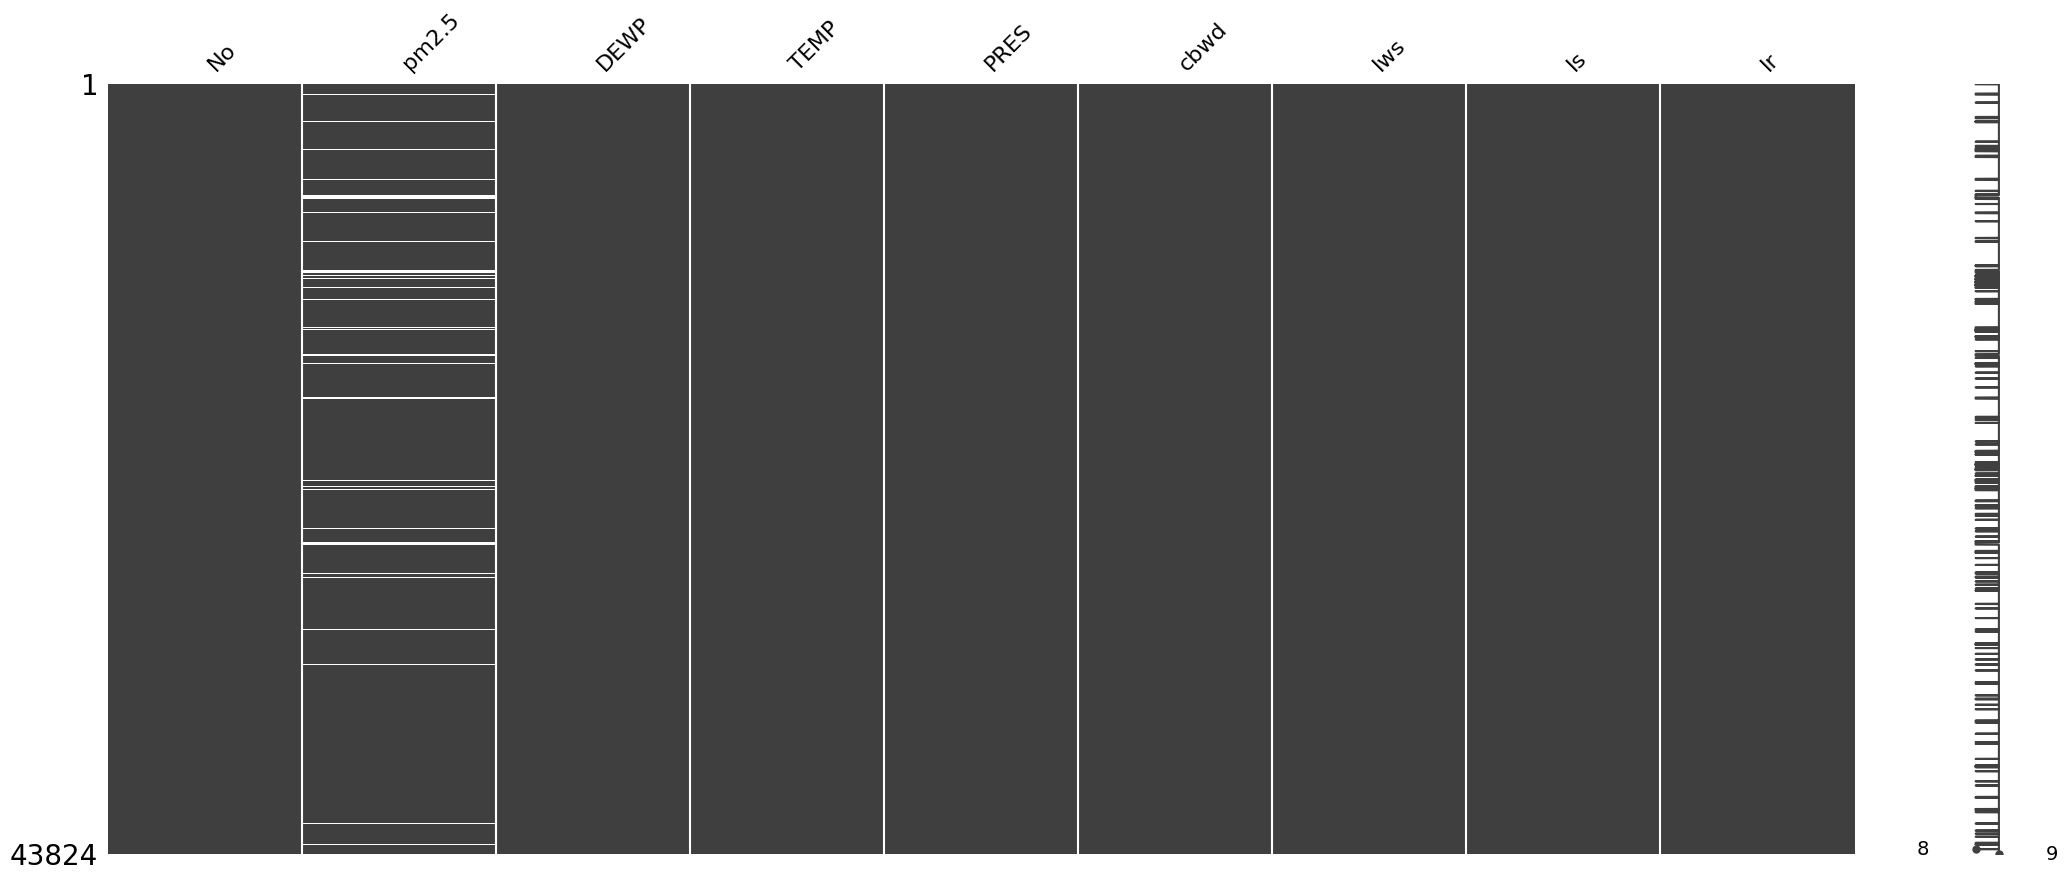

In [7]:
# visualize missing values
msn.matrix(pollution_df)

In [8]:
pollution_df.drop('No', axis=1, inplace=True)

# columns names
pollution_df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
pollution_df.index.name = 'date'

# mark all Na values with 0
pollution_df['pollution'].fillna(0, inplace = True)

#drop the first 24 hours
pollution_df = pollution_df[24:]

pollution_df.head()

pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0

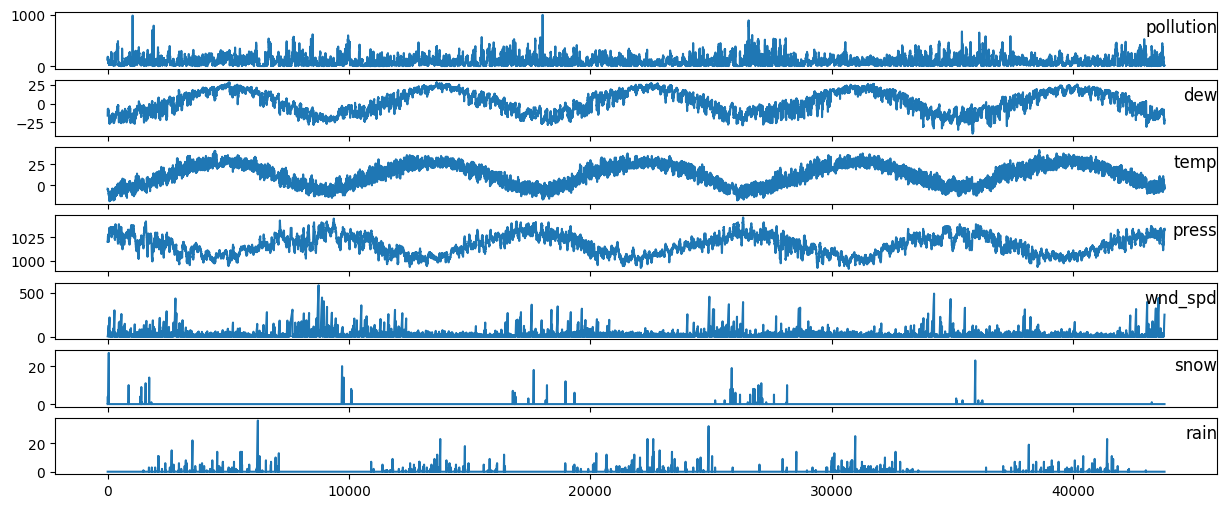

In [9]:
values = pollution_df.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure()

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(pollution_df.columns[group], y = 0.5, loc='right')
    i += 1
    
plt.show()

# Reeading and saving Time series Objects in Python


### Air Passengers dataset

In [10]:
# loading the dataset
airPas_df = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')

#parse string to datetime type
airPas_df['Month'] = pd.to_datetime(airPas_df['Month'], infer_datetime_format=True)
airPas_df_indexed = airPas_df.set_index(['Month'])
airPas_df_indexed.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

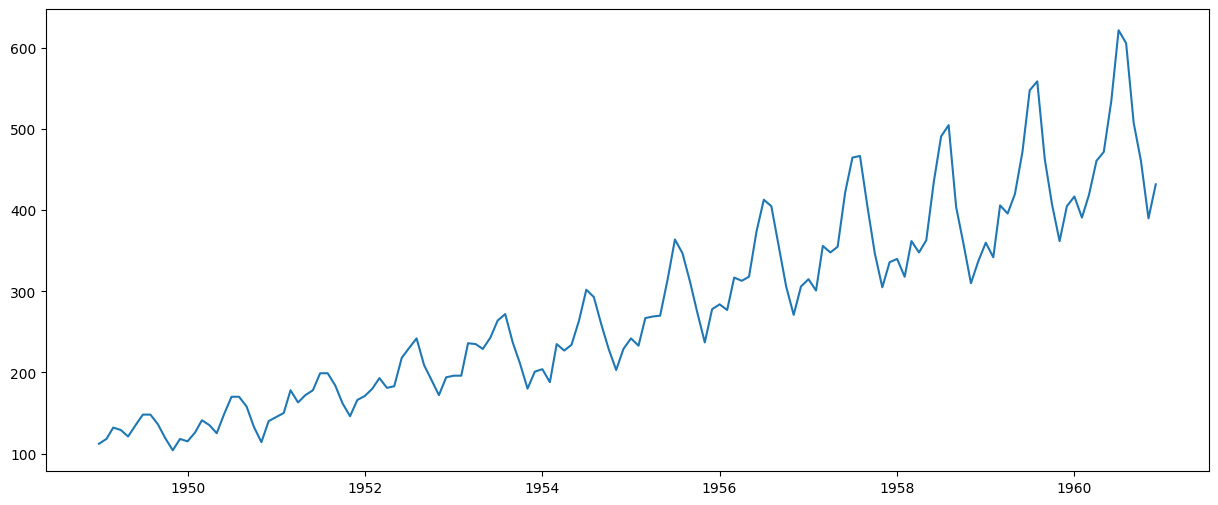

In [11]:
plt.plot(airPas_df_indexed)
plt.show()

In [12]:
# save the timeSeries object 
airPas_df_indexed.to_csv('ts_1.csv', index = True, sep = ',')

#check the object
series_1 = pd.read_csv('ts_1.csv', header = 0)

print(type(series_1))
series_1.head()

<class 'pandas.core.frame.DataFrame'>


Month  #Passengers
0  1949-01-01          112
1  1949-02-01          118
2  1949-03-01          132
3  1949-04-01          129
4  1949-05-01          121

### GDP DataSet

In [13]:
india_gdp_df = pd.read_csv('/kaggle/input/time-series-data/GDPIndia.csv')
date_rng = pd.date_range(start='1/1/1960', end='31/12/2017', freq='A')
india_gdp_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Year'])

india_gdp_df.head().T

0                    1                    2  \
Year                         1960                 1961                 1962   
GDPpercapita            81.284764            84.426437            88.914919   
TimeIndex     1960-12-31 00:00:00  1961-12-31 00:00:00  1962-12-31 00:00:00   

                                3                    4  
Year                         1963                 1964  
GDPpercapita           100.048592           114.315161  
TimeIndex     1963-12-31 00:00:00  1964-12-31 00:00:00

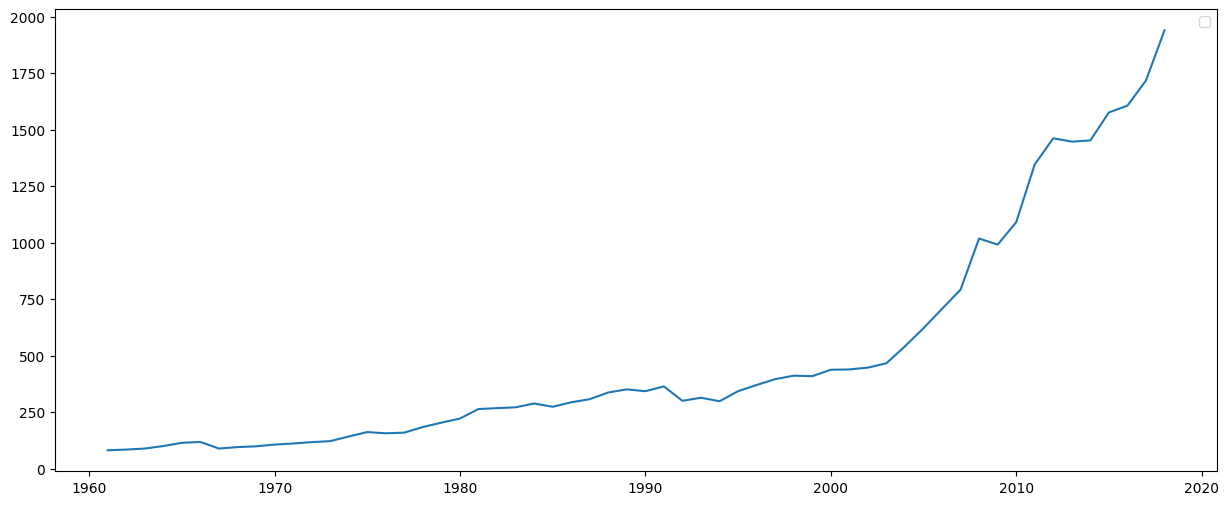

In [14]:
plt.plot(india_gdp_df.TimeIndex, india_gdp_df.GDPpercapita)
plt.legend(loc='best')
plt.show()

In [15]:

with open('GDPIndia.obj', 'wb') as fp:
    pickle.dump(india_gdp_df, fp)
    

In [16]:
with open('GDPIndia.obj', 'rb') as fp:
    india_gdp_1_df = pickle.load(fp)

india_gdp_1_df.head()

Year  GDPpercapita  TimeIndex
0  1960     81.284764 1960-12-31
1  1961     84.426437 1961-12-31
2  1962     88.914919 1962-12-31
3  1963    100.048592 1963-12-31
4  1964    114.315161 1964-12-31

# Component of Time Series

- Trend : The long-term progression of the series
- Seasonality : Regular pattern repeating over a specific period
- Cyclic patterns : Irregular flcuation influenced by economic or business cycles
- Noise: Random variation that cannot be attributed to tren, seasonality or cycles

#### Trend and Seasonality

Shampoo sales dataset

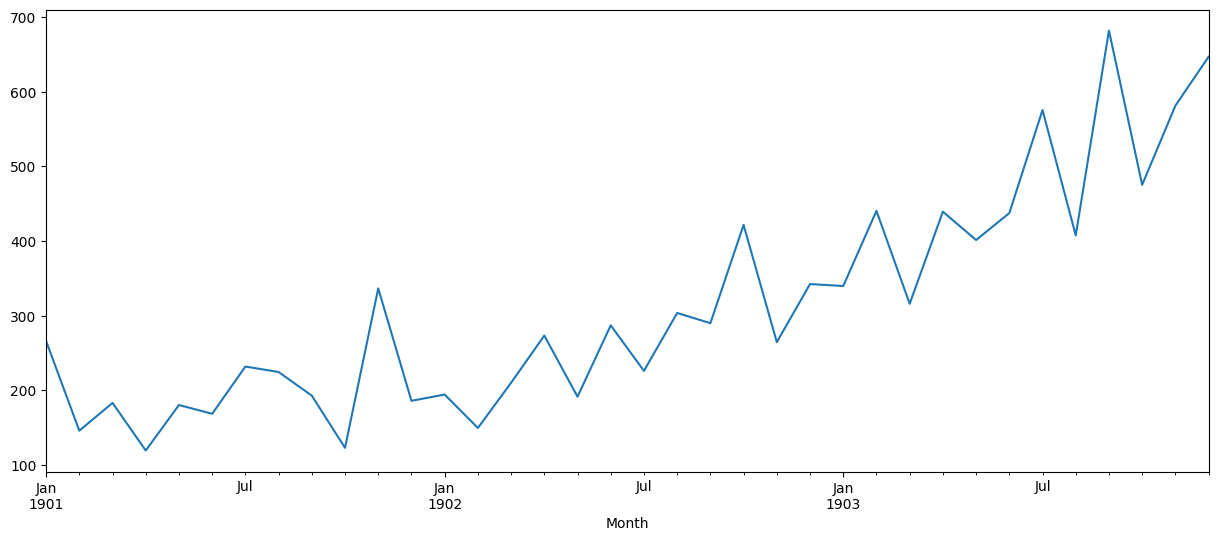

In [17]:
def parse(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/kaggle/input/time-series-data/shampoo.csv', header=0, parse_dates=[0], index_col=0, date_parser=parse).squeeze()

series.plot()
plt.show()

the above plot shows increasing trend


#### Minimum Daily Temperatures Dataset


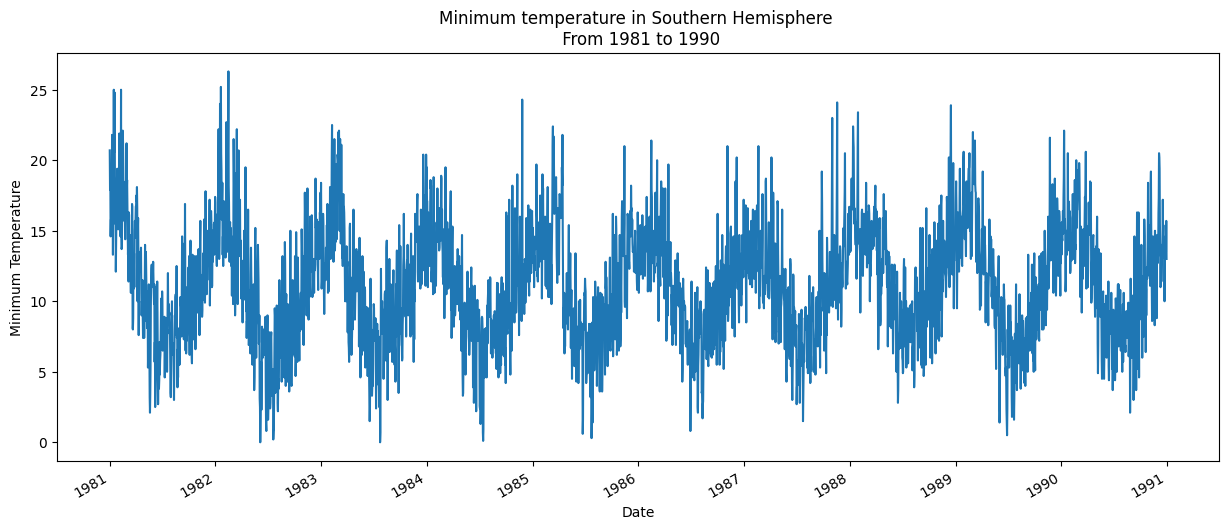

In [18]:
series = pd.read_csv('/kaggle/input/time-series-data/daily-min-temperatures.csv', header=0, index_col=0,parse_dates=True).squeeze()

series.plot()
plt.ylabel('Minimum Temperature')
plt.title('Minimum temperature in Southern Hemisphere \n From 1981 to 1990')
plt.show()

The above plot shows a string seasonality component


lets draw boxplot to check the variable in a year 1990

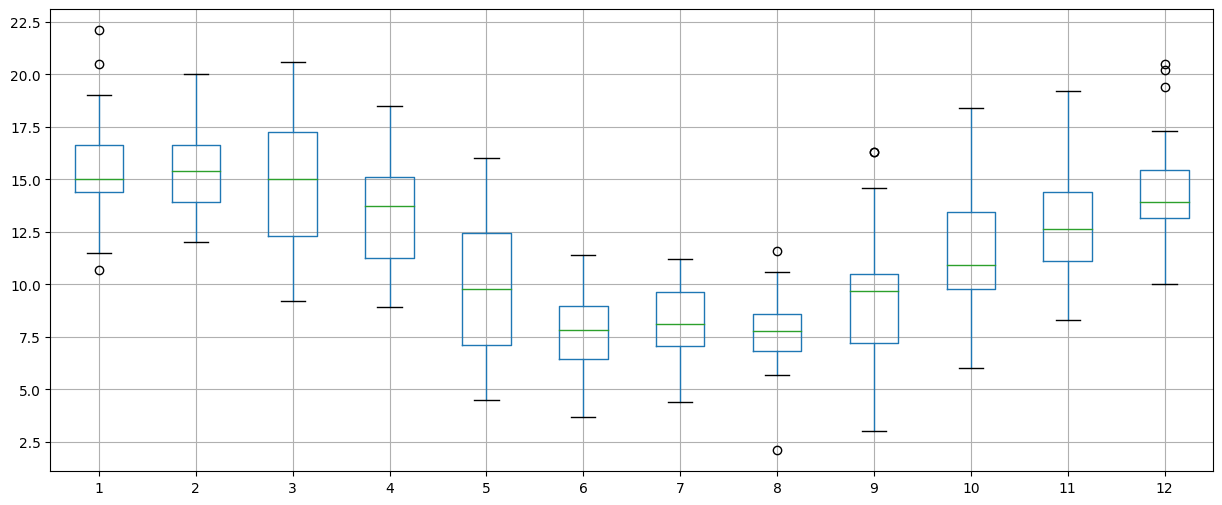

In [19]:
months = pd.DataFrame()
one_year = series['1990']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis = 1)
months = pd.DataFrame(months)
months.columns = range(1, 13)
months.boxplot()
plt.show()

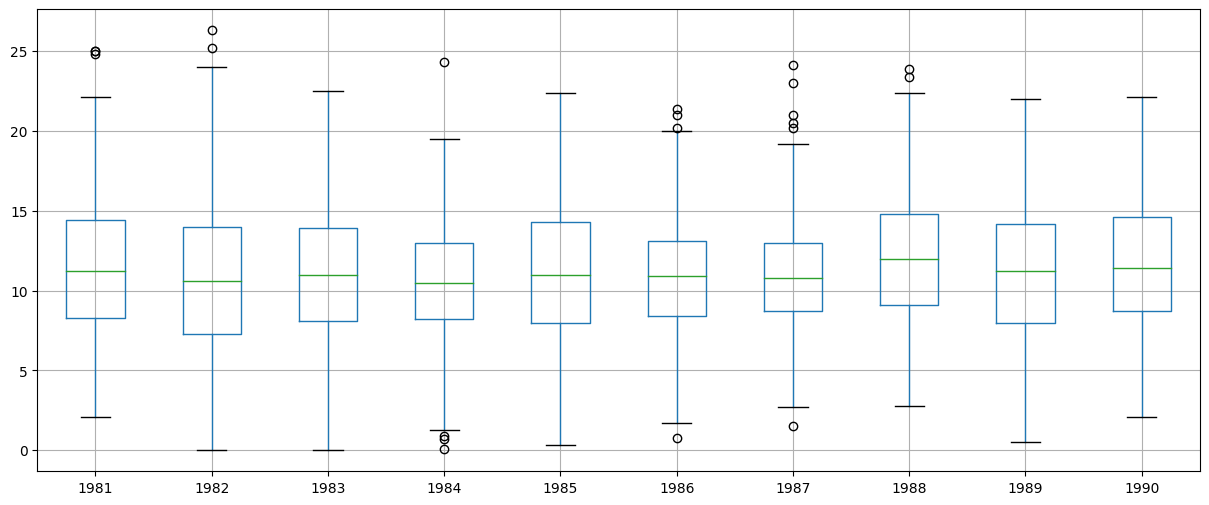

In [20]:
# grouping by year and plotting the same
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values

years.boxplot()
plt.show()

Doesn't show much year by year variation

#### Tractor Sales Dataset

In [21]:
tractor_df = pd.read_csv('/kaggle/input/time-series-data/TractorSales.csv')
tractor_df.head()

Month-Year  Number of Tractor Sold
0      3-Jan                     141
1      3-Feb                     157
2      3-Mar                     185
3      3-Apr                     199
4      3-May                     203

In [22]:
dates = pd.date_range(start = '2003-01-01', freq = 'MS', periods = len(tractor_df))



tractor_df['Month'] = dates.month
tractor_df['Month'] = tractor_df['Month'].apply(lambda x:calendar.month_abbr[x])
tractor_df['Year'] = dates.year

tractor_df.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace = True)
tractor_df = tractor_df[['Month', 'Year', 'Tractor-Sales']]

tractor_df.set_index(dates, inplace = True)

tractor_df = tractor_df[['Tractor-Sales']]
tractor_df.head()

Tractor-Sales
2003-01-01            141
2003-02-01            157
2003-03-01            185
2003-04-01            199
2003-05-01            203

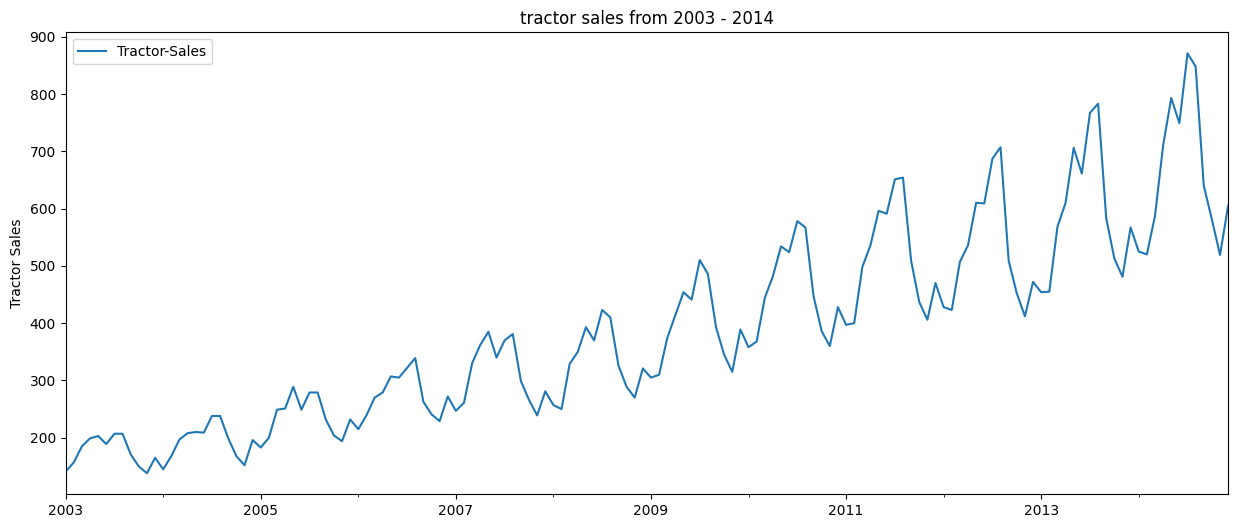

In [23]:
tractor_df.plot()
plt.ylabel('Tractor Sales')
plt.title("tractor sales from 2003 - 2014")
plt.show()

The above plot shows strong seasonality and trend component

# Decomposition of Time Series


#### Additive model decomposition on Retail Turnover data


In [24]:
turnover_df = pd.read_csv('/kaggle/input/time-series-data/RetailTurnover.csv')
date_rng = pd.date_range(start='1/7/1982', end = '31/3/1992', freq='Q')
turnover_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Quarter'])
turnover_df.head()

Year Quarter  Turnover  TimeIndex
0  1982      Q3   13423.2 1982-03-31
1  1982      Q4   13128.8 1982-06-30
2  1983      Q1   15398.8 1982-09-30
3  1983      Q2   12964.2 1982-12-31
4  1983      Q3   13133.5 1983-03-31

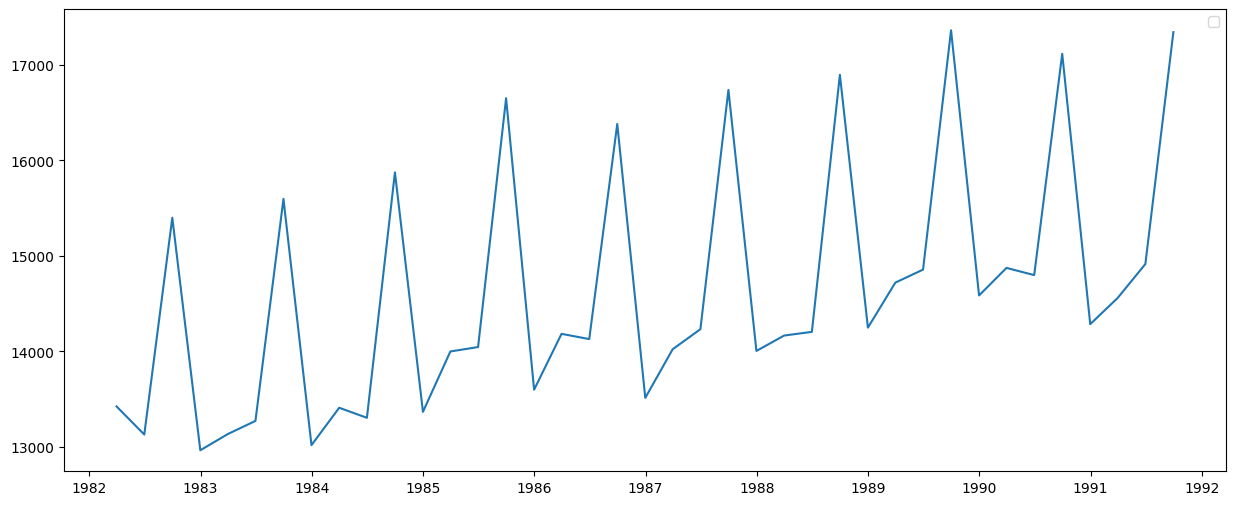

In [25]:
plt.plot(turnover_df.TimeIndex, turnover_df.Turnover)
plt.legend(loc='best')
plt.show()

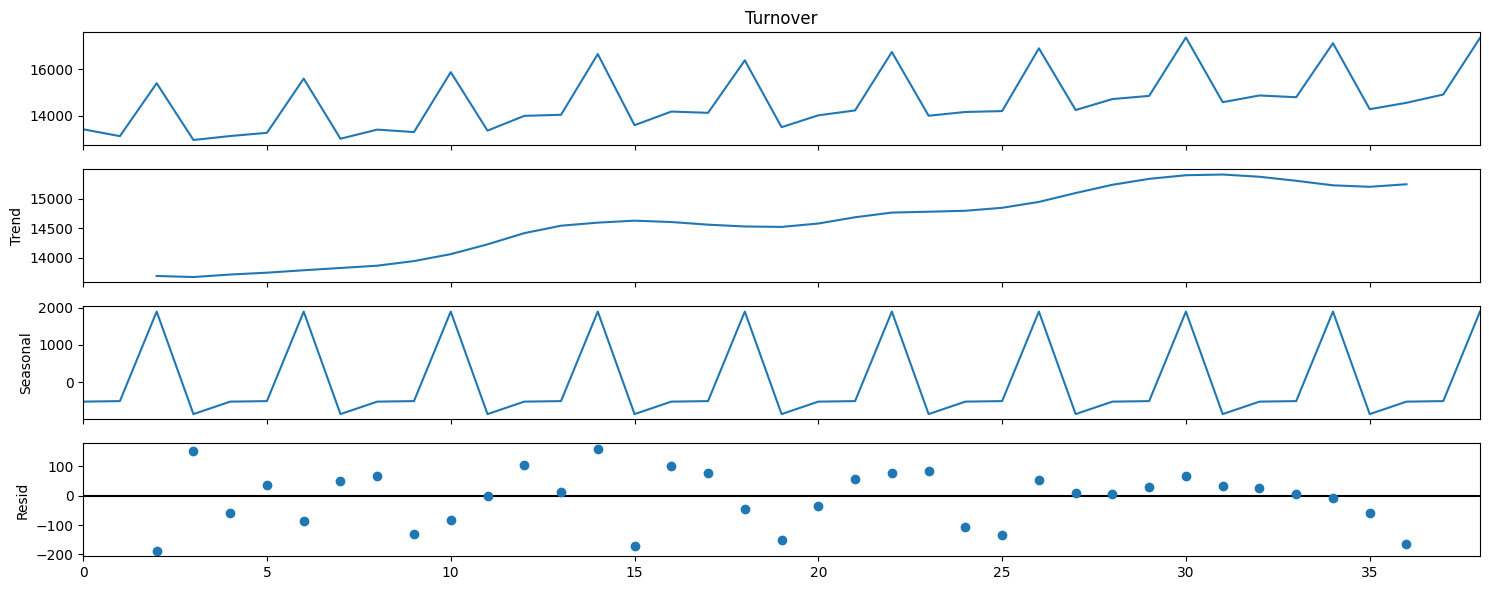

In [26]:


decompTurnover_df = seasonal_decompose(turnover_df.Turnover, model = "additive", period=4)
decompTurnover_df.plot()
plt.show()

We can see the trend and seasonality are clearly separated.

In [27]:
trend = decompTurnover_df.trend
seasonal = decompTurnover_df.seasonal
residual = decompTurnover_df.resid

trend.head()

0           NaN
1           NaN
2    13692.5375
3    13674.1875
4    13716.7375
Name: trend, dtype: float64

In [28]:
seasonal.head()

0    -524.613498
1    -510.713672
2    1894.960113
3    -859.632943
4    -524.613498
Name: seasonal, dtype: float64

In [29]:
residual.head()

0           NaN
1           NaN
2   -188.697613
3    149.645443
4    -58.624002
Name: resid, dtype: float64

#### Additive model on Champagne series data

In [30]:
champagne_df = pd.read_csv('/kaggle/input/time-series-data/Champagne.csv')
date_rng = pd.date_range(start='1/1/1964', end = '30/9/1972', freq='M')
champagne_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])
champagne_df.head()

Year Month  Sales  TimeIndex
0  1964   Jan   2815 1964-01-31
1  1964   Feb   2672 1964-02-29
2  1964   Mar   2755 1964-03-31
3  1964   Apr   2721 1964-04-30
4  1964   May   2946 1964-05-31

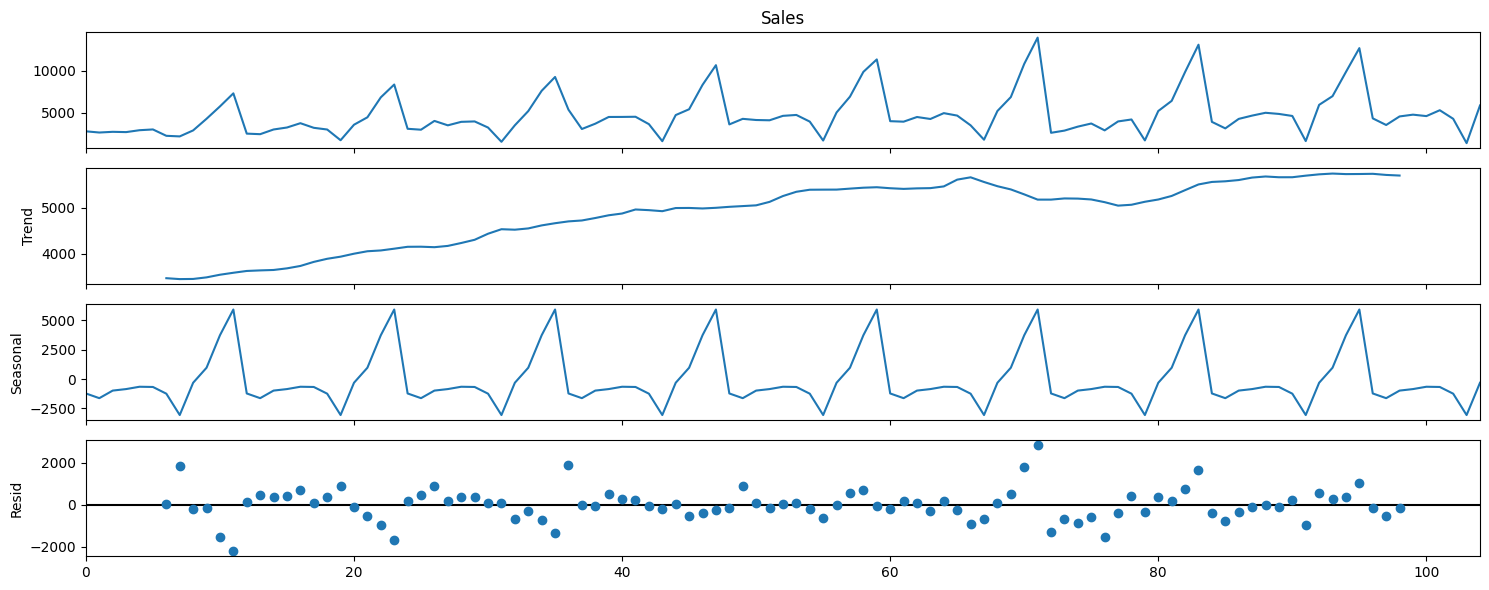

In [31]:
decompChampagne_df = seasonal_decompose(champagne_df.Sales, model = "additive", period=12)
decompChampagne_df.plot()
plt.show()

#### Multiplicative model on International Air Passengers Data

In [32]:
interAirPas_df = pd.read_csv('/kaggle/input/time-series-data/AirPax.csv')
interAirPas_df.head()

Year Month  Passenger
0  1949   Jan        112
1  1949   Feb        118
2  1949   Mar        132
3  1949   Apr        129
4  1949   May        121

In [33]:
date_rng = pd.date_range(start = '1/1/1949', end = '31/12/1960', freq = 'M')

interAirPas_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])
interAirPas_df.head()

Year Month  Passenger  TimeIndex
0  1949   Jan        112 1949-01-31
1  1949   Feb        118 1949-02-28
2  1949   Mar        132 1949-03-31
3  1949   Apr        129 1949-04-30
4  1949   May        121 1949-05-31

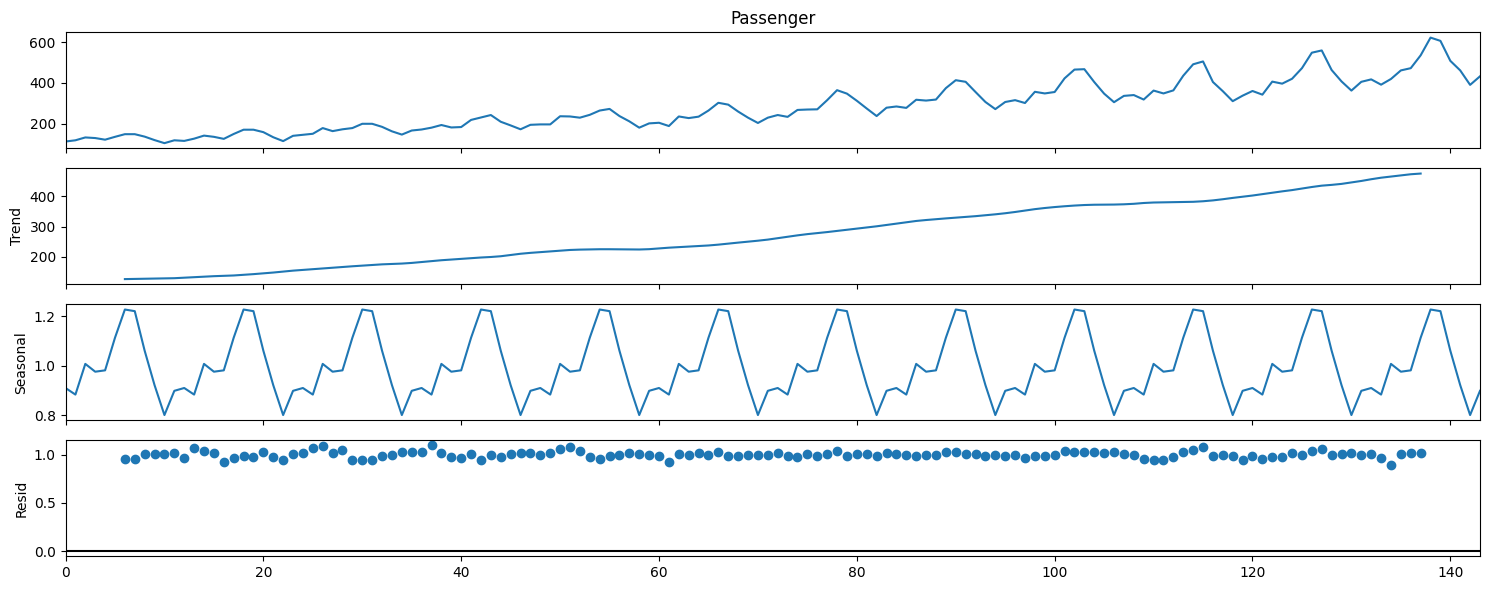

In [34]:
decompAirPas = seasonal_decompose(interAirPas_df.Passenger, model='multiplicative', period=12)
decompAirPas.plot()
plt.show()

We can see the trend and seasonality are clearly separated

# Visualization of seasonality - Month plots


In [35]:
quarterly_turnover = pd.pivot_table(turnover_df, values = "Turnover", columns = "Quarter", index = "Year")
quarterly_turnover

Quarter       Q1       Q2       Q3       Q4
Year                                       
1982         NaN      NaN  13423.2  13128.8
1983     15398.8  12964.2  13133.5  13271.7
1984     15596.3  13018.0  13409.3  13304.2
1985     15873.9  13366.5  13998.6  14045.1
1986     16650.3  13598.4  14183.2  14128.5
1987     16380.7  13512.8  14022.1  14231.8
1988     16737.0  14004.5  14165.5  14203.9
1989     16895.1  14248.2  14719.5  14855.8
1990     17361.6  14585.2  14873.5  14798.4
1991     17115.2  14284.9  14558.8  14914.3
1992     17342.3      NaN      NaN      NaN

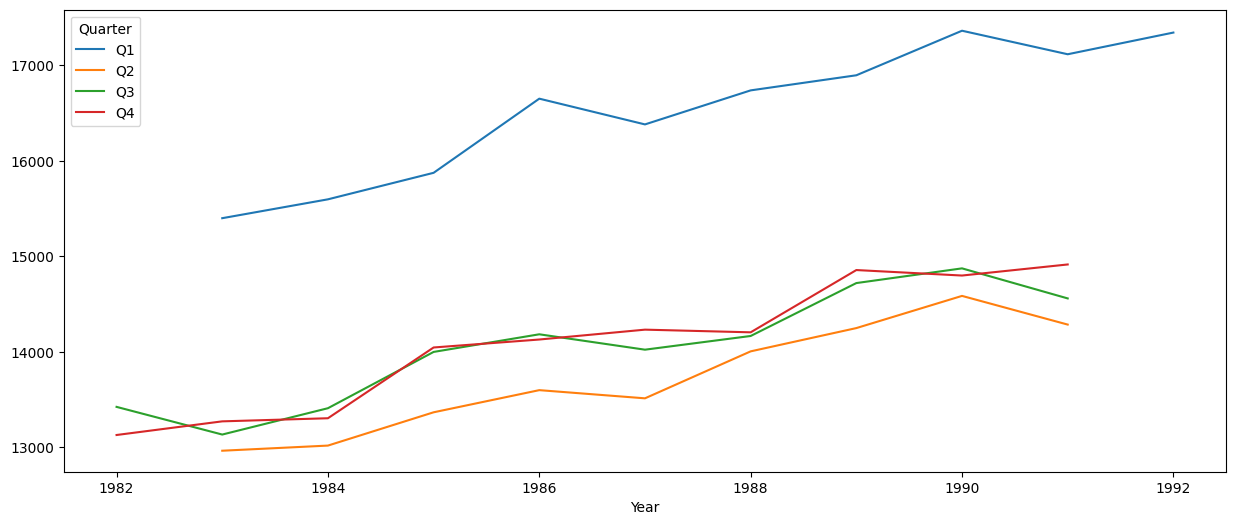

In [36]:
quarterly_turnover.plot()
plt.show()

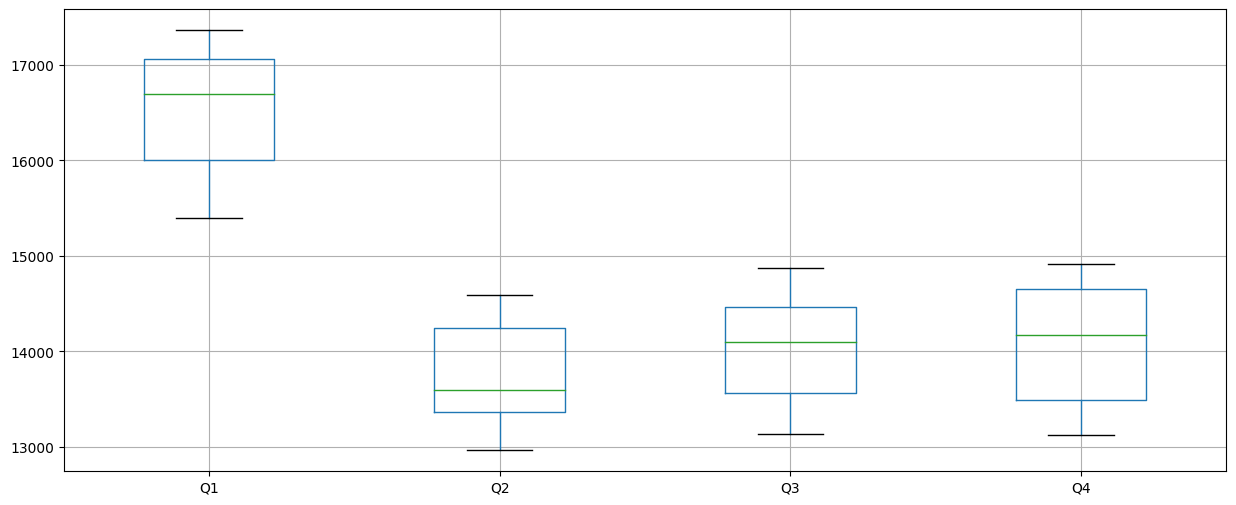

In [37]:
quarterly_turnover.boxplot()
plt.show()

Clearly shows Quarter 1 turnover is the highest and Quarter 2 is the lowest

#### Petrol data seasonality

In [38]:
petrol_df = pd.read_csv('/kaggle/input/time-series-data/Petrol.csv')
petrol_df.tail()

Year Quarter  Consumption
46  2012      Q3      0.88818
47  2012      Q4      0.99804
48  2013      Q1      0.84120
49  2013      Q2      0.74032
50  2013      Q3      0.72823

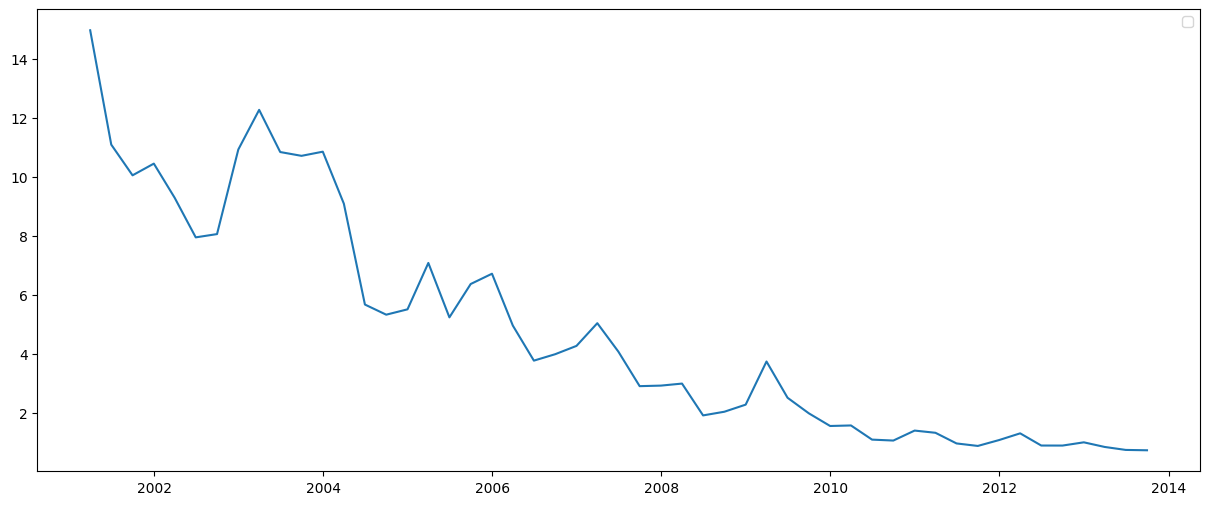

In [39]:
date_rng = pd.date_range(start='1/1/2001', end='30/9/2013', freq='Q')
petrol_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Quarter'])

plt.plot(petrol_df.TimeIndex, petrol_df.Consumption)
plt.legend(loc='best')
plt.show()

# Moving Average forecast

### Two types of moving average

1) Centred moving average  
2) trailing moving average


#### Average and moving average on Air Temp data

In [40]:
airTemp_df = pd.read_csv('/kaggle/input/time-series-data/AirTemp.csv')
date_rng = pd.date_range(start='1/1/1920', end = '31/12/1939', freq='M')
airTemp_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])
airTemp_df.head()

Year Month  AvgTemp  TimeIndex
0  1920   Jan     40.6 1920-01-31
1  1920   Feb     40.8 1920-02-29
2  1920   Mar     44.4 1920-03-31
3  1920   Apr     46.7 1920-04-30
4  1920   May     54.1 1920-05-31

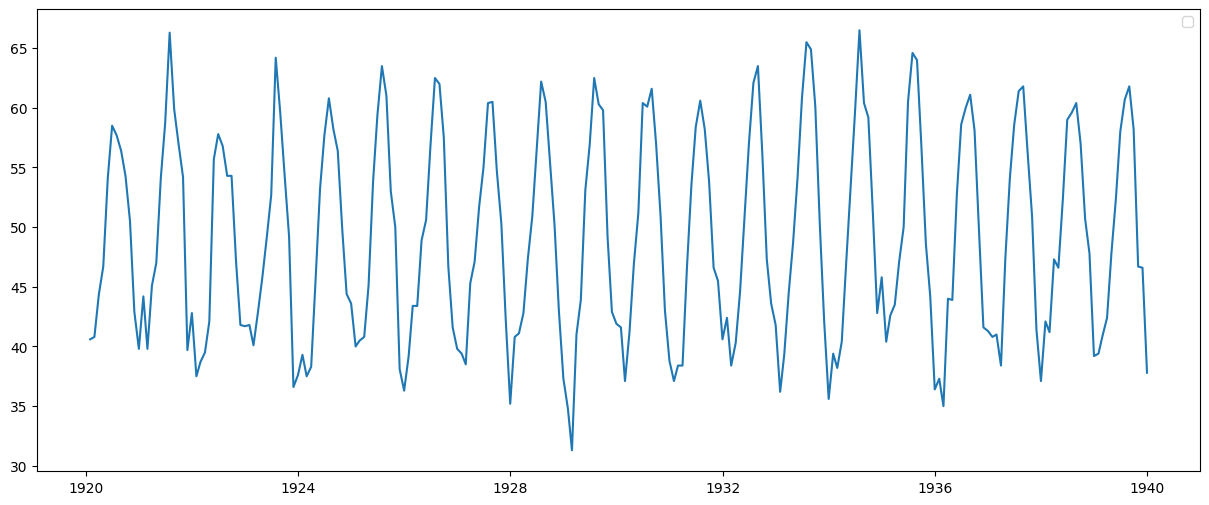

In [41]:
plt.plot(airTemp_df.TimeIndex, airTemp_df.AvgTemp)
plt.legend(loc='best')
plt.show()

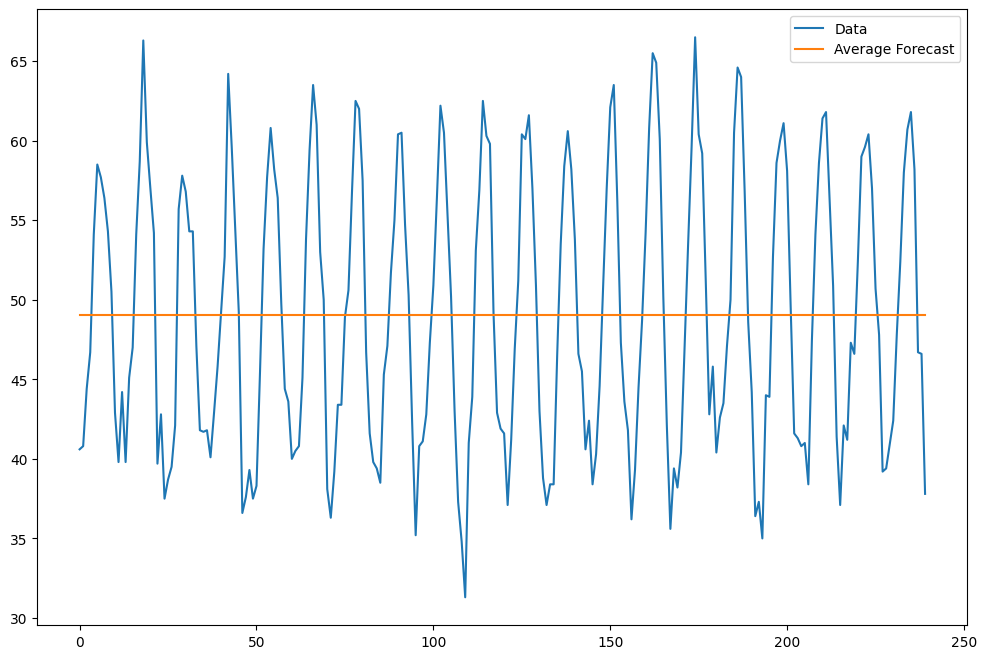

In [42]:
# plotting average forecast
temp_avg = airTemp_df.copy()
temp_avg['avg_forecast'] = airTemp_df['AvgTemp'].mean()

plt.figure(figsize=(12, 8))
plt.plot(airTemp_df['AvgTemp'], label='Data')
plt.plot(temp_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

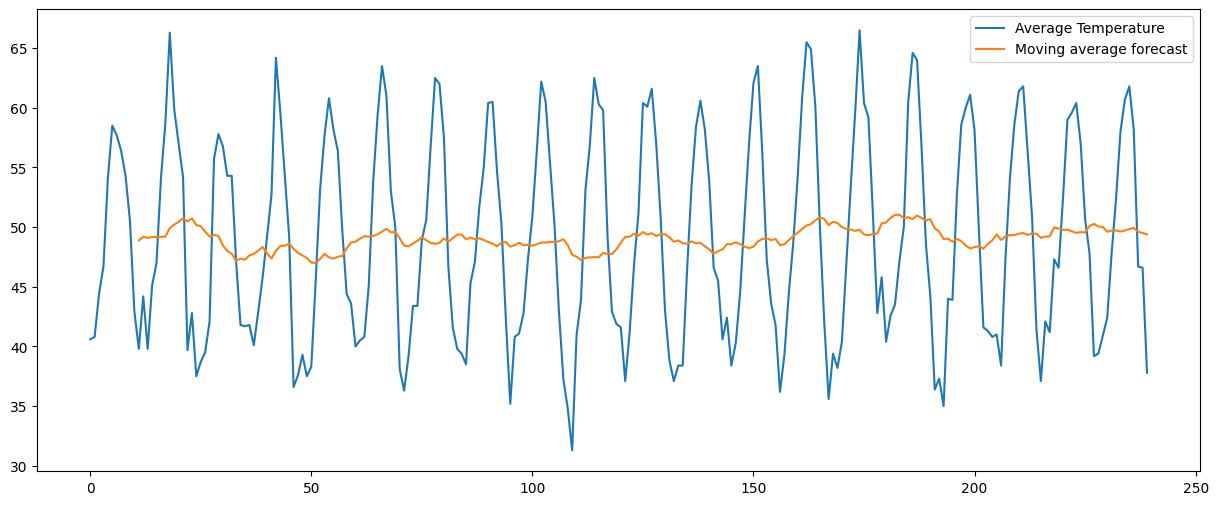

In [43]:
# plotting moving forecast and average temperature
mvg_avg = airTemp_df.copy()
mvg_avg['moving_avg_forecast'] = airTemp_df['AvgTemp'].rolling(12).mean()

plt.plot(airTemp_df['AvgTemp'], label="Average Temperature")
plt.plot(mvg_avg['moving_avg_forecast'], label="Moving average forecast")
plt.legend(loc='best')
plt.show()

#### Moving average with window size 5 for US GDP

In [44]:
USGDP_df = pd.read_csv('/kaggle/input/time-series-data/GDPIndia.csv', header=0)
USGDP_df.head()

Year  GDPpercapita
0  1960     81.284764
1  1961     84.426437
2  1962     88.914919
3  1963    100.048592
4  1964    114.315161

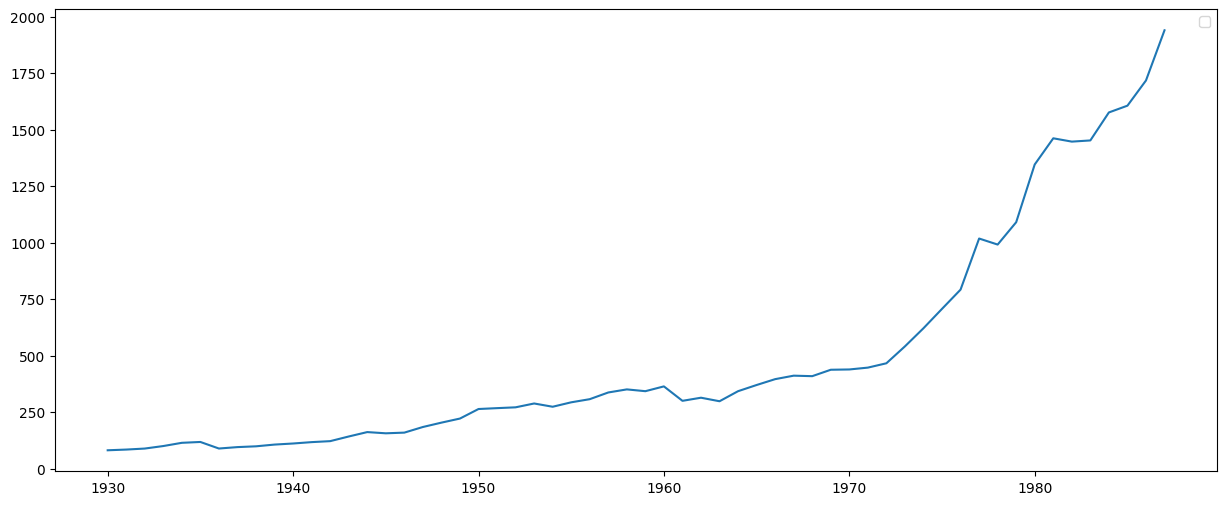

In [45]:
date_rng = pd.date_range(start='1/1/1929', end='31/12/1991', freq='A')

USGDP_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Year'])

plt.plot(USGDP_df.TimeIndex, USGDP_df.GDPpercapita)
plt.legend(loc='best')
plt.show()

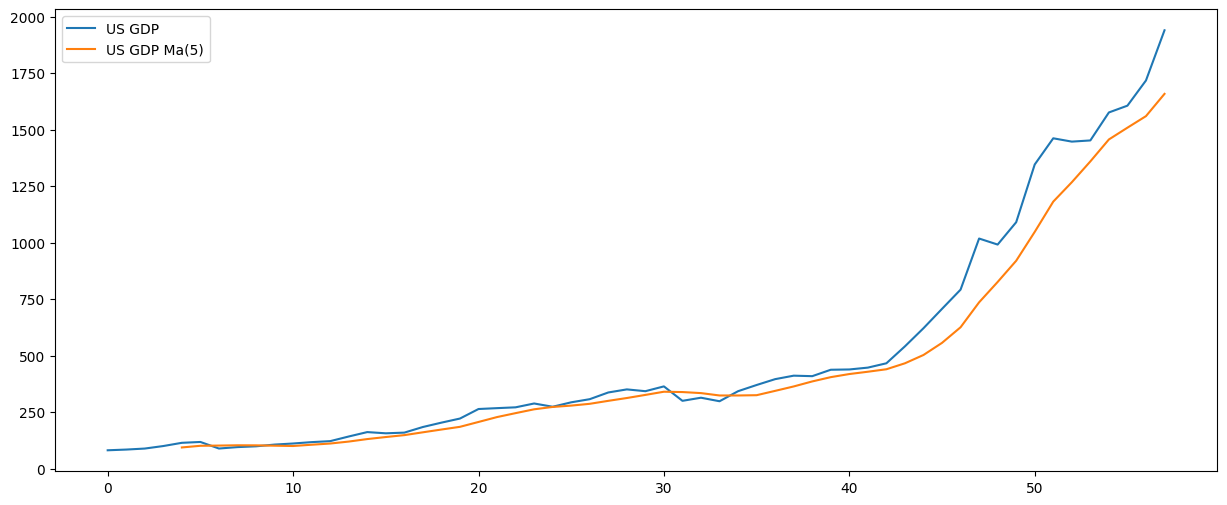

In [46]:
# moving average on US GDP
mvg_avg_USGDP = USGDP_df.copy()
mvg_avg_USGDP['moving_avg_forecast'] = USGDP_df['GDPpercapita'].rolling(5).mean()
plt.plot(USGDP_df['GDPpercapita'], label = 'US GDP')
plt.plot(mvg_avg_USGDP['moving_avg_forecast'], label='US GDP Ma(5)')
plt.legend(loc='best')
plt.show()

#### moving average 3 for India GDP

In [47]:

IndiaGDP_df = pd.read_csv('/kaggle/input/time-series-data/GDPIndia.csv', header=0)

IndiaGDP_df.head()
#IndiaGDP_df.tail()

Year  GDPpercapita
0  1960     81.284764
1  1961     84.426437
2  1962     88.914919
3  1963    100.048592
4  1964    114.315161

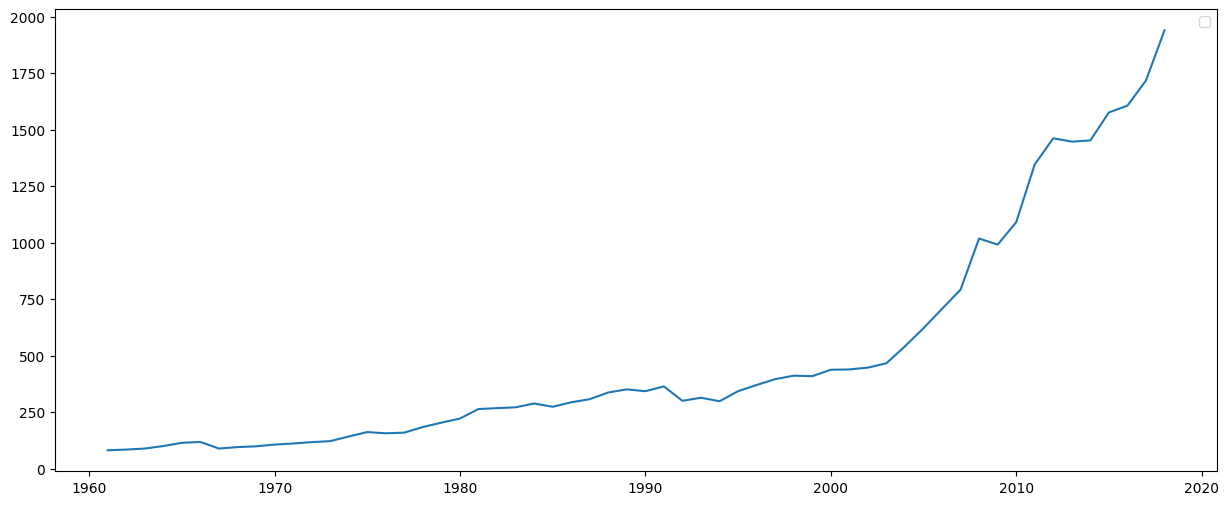

In [48]:
date_rng = pd.date_range(start='1/1/1960', end='31/12/2017', freq='A')
IndiaGDP_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Year'])

plt.plot(IndiaGDP_df.TimeIndex, IndiaGDP_df.GDPpercapita)
plt.legend(loc='best')
plt.show()

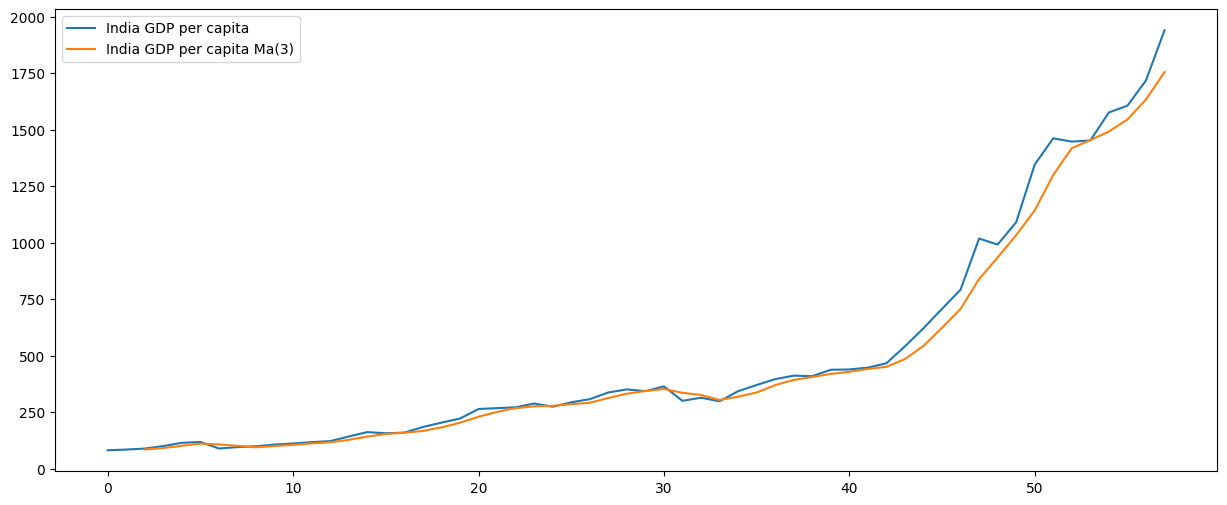

In [49]:
mvg_avg_IndiaGDP = IndiaGDP_df.copy()
mvg_avg_IndiaGDP['moving_avg_forecast'] = IndiaGDP_df['GDPpercapita'].rolling(3).mean()

plt.plot(IndiaGDP_df['GDPpercapita'], label='India GDP per capita')
plt.plot(mvg_avg_IndiaGDP['moving_avg_forecast'], label='India GDP per capita Ma(3)')
plt.legend(loc='best')
plt.show()

# Handling missing values

In [50]:
def handle_missing_values():
    print()
    print(format('How to deal with missing values in a Timeseries in Python', '*^82'))
    
    # create date
    time_index = pd.date_range('28/03/2017', periods=5, freq='M')
    
    # create dataframe , set index
    df = pd.DataFrame(index=time_index)
    print(df)
    
    # create feature with a gap of missing values
    df['Sales'] = [1.0, 2.0, np.nan, np.nan, 5.0]
    print(" df : ")
    print(df)
    
    # interpolate missing values 
    df_1 = df.interpolate()
    print("df_1 : ")
    print(df_1)
    
    # forward-fill missing values
    df_2 = df.ffill()
    print("df_2 : ")
    print(df_2)
    
    # backFill missing values
    df_3 = df.bfill()
    print("df_3 : ")
    print(df_3)
    
    # Interpolate missing values but only up one value
    df_4 = df.interpolate(limit=1, limit_direction='forward')
    print("df_4 : ")
    print(df_4)
    
    # Interpolate missing values but only up two value
    df_5 = df.interpolate(limit=2, limit_direction='forward')
    print("df_5 : ")
    print(df_5)

handle_missing_values()


************How to deal with missing values in a Timeseries in Python*************
Empty DataFrame
Columns: []
Index: [2017-03-31 00:00:00, 2017-04-30 00:00:00, 2017-05-31 00:00:00, 2017-06-30 00:00:00, 2017-07-31 00:00:00]
 df : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    NaN
2017-06-30    NaN
2017-07-31    5.0
df_1 : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    3.0
2017-06-30    4.0
2017-07-31    5.0
df_2 : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    2.0
2017-06-30    2.0
2017-07-31    5.0
df_3 : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    5.0
2017-06-30    5.0
2017-07-31    5.0
df_4 : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    3.0
2017-06-30    NaN
2017-07-31    5.0
df_5 : 
            Sales
2017-03-31    1.0
2017-04-30    2.0
2017-05-31    3.0
2017-06-30    4.0
2017-07-31    5.0


#### Water Consumption dataset

In [51]:
waterConsumption_df = pd.read_csv('/kaggle/input/time-series-data/WaterConsumption.csv')
waterConsumption_df.head()

Date  reference  target
0  15-01-2010       12.0    12.0
1  15-02-2010       18.0    18.0
2  15-03-2010       22.0    22.0
3  15-04-2010       26.0    26.0
4  15-05-2010       31.0     NaN

In [52]:
waterConsumption_df.Date = pd.to_datetime(waterConsumption_df.Date, format='%d-%m-%Y')
waterConsumption_df = waterConsumption_df.set_index('Date')
waterConsumption_df.head()

reference  target
Date                         
2010-01-15       12.0    12.0
2010-02-15       18.0    18.0
2010-03-15       22.0    22.0
2010-04-15       26.0    26.0
2010-05-15       31.0     NaN

In [53]:
# for visualization, we will add a column that contains the missing values only

waterConsumption_df = waterConsumption_df.assign(missing = np.nan)
waterConsumption_df.missing[waterConsumption_df.target.isna()] = waterConsumption_df.reference
waterConsumption_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2010-01-15 to 2017-12-15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reference  96 non-null     float64
 1   target     75 non-null     float64
 2   missing    21 non-null     float64
dtypes: float64(3)
memory usage: 3.0 KB


<Axes: xlabel='Date'>

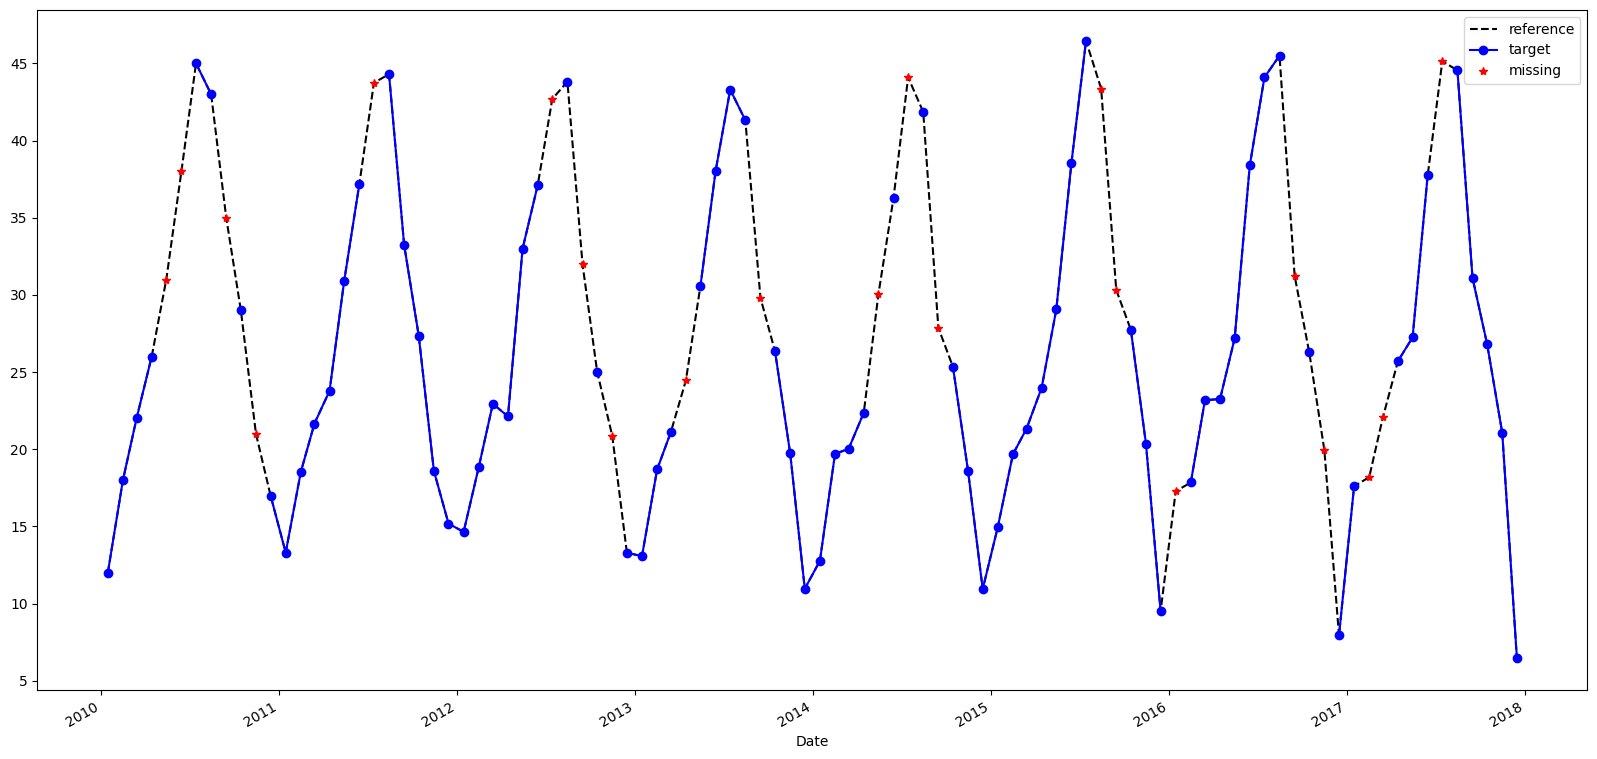

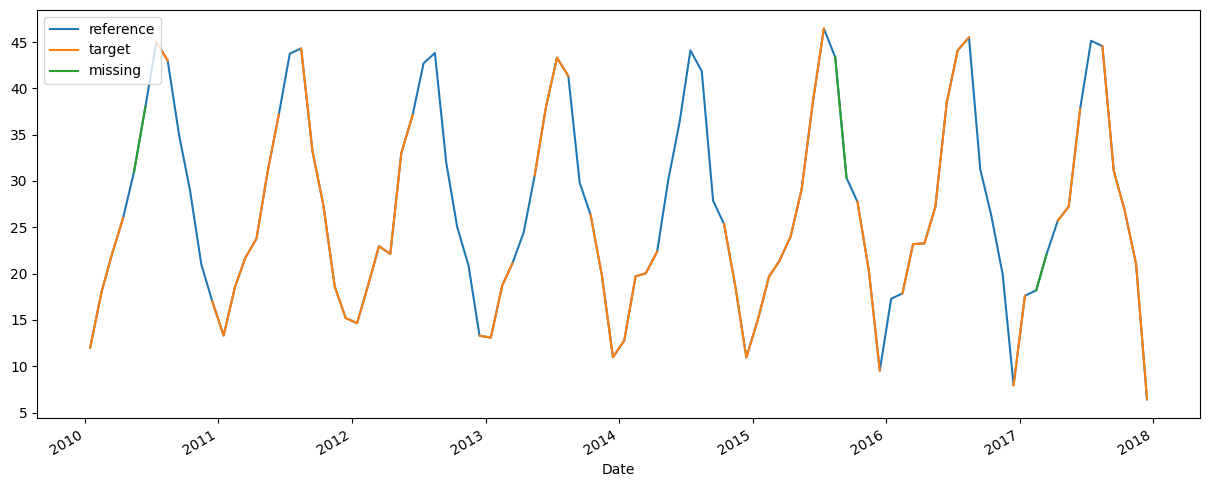

In [54]:
waterConsumption_df.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))
waterConsumption_df.plot()

In [55]:
# Filling using mean or median

waterConsumption_df = waterConsumption_df.assign(FillMean=waterConsumption_df.target.fillna(waterConsumption_df.target.mean()))
waterConsumption_df = waterConsumption_df.assign(FillMedian=waterConsumption_df.target.fillna(waterConsumption_df.target.median()))

# imputing using rolling average
waterConsumption_df = waterConsumption_df.assign(Rollingmean=waterConsumption_df.target.fillna(waterConsumption_df.target.rolling(24, min_periods=1).mean()))

#imputing using rolling median
waterConsumption_df = waterConsumption_df.assign(Rollingmedian=waterConsumption_df.target.fillna(waterConsumption_df.target.rolling(24, min_periods=1).median()))


In [56]:
# imputing using interpolation with different methods

waterConsumption_df = waterConsumption_df.assign(InterpolateLinear=waterConsumption_df.target.interpolate(method='linear'))
waterConsumption_df = waterConsumption_df.assign(InterpolateTime=waterConsumption_df.target.interpolate(method='time'))
waterConsumption_df = waterConsumption_df.assign(InterpolateQuadratic=waterConsumption_df.target.interpolate(method='quadratic'))
waterConsumption_df = waterConsumption_df.assign(InterpolateCubic=waterConsumption_df.target.interpolate(method='cubic'))
waterConsumption_df = waterConsumption_df.assign(InterpolateSLinear=waterConsumption_df.target.interpolate(method='slinear'))
waterConsumption_df = waterConsumption_df.assign(InterpolateAkima=waterConsumption_df.target.interpolate(method='akima'))
waterConsumption_df = waterConsumption_df.assign(InterpolatePoly5=waterConsumption_df.target.interpolate(method='polynomial', order=5))
waterConsumption_df = waterConsumption_df.assign(InterpolatePoly7=waterConsumption_df.target.interpolate(method='polynomial', order=7))
waterConsumption_df = waterConsumption_df.assign(InterpolateSpline3=waterConsumption_df.target.interpolate(method='spline', order=3))
waterConsumption_df = waterConsumption_df.assign(InterpolateSpline4=waterConsumption_df.target.interpolate(method='spline', order=4))
waterConsumption_df = waterConsumption_df.assign(InterpolateSpline5=waterConsumption_df.target.interpolate(method='spline', order=5))


In [57]:
# scoring the results and see which is better

results = [(method, r2_score(waterConsumption_df.reference, waterConsumption_df[method])) for method in list(waterConsumption_df)[3:]]

results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by = 'R_squared', ascending=False)


Method           R_squared
9       InterpolateAkima   0.981684100149588
5        InterpolateTime  0.9815664478940275
8     InterpolateSLinear  0.9815664478940275
4      InterpolateLinear  0.9813215759943529
6   InterpolateQuadratic     0.9663474396797
12    InterpolateSpline3  0.9633836918698976
7       InterpolateCubic  0.9633218181089737
10      InterpolatePoly5   0.954157955951024
14    InterpolateSpline5   0.951671359314308
11      InterpolatePoly7  0.9504371542313383
13    InterpolateSpline4   0.928463604189156
0               FillMean  0.7859894121335577
2            Rollingmean  0.7457974578754563
1             FillMedian  0.7347827483233148
3          Rollingmedian  0.6888988883243206

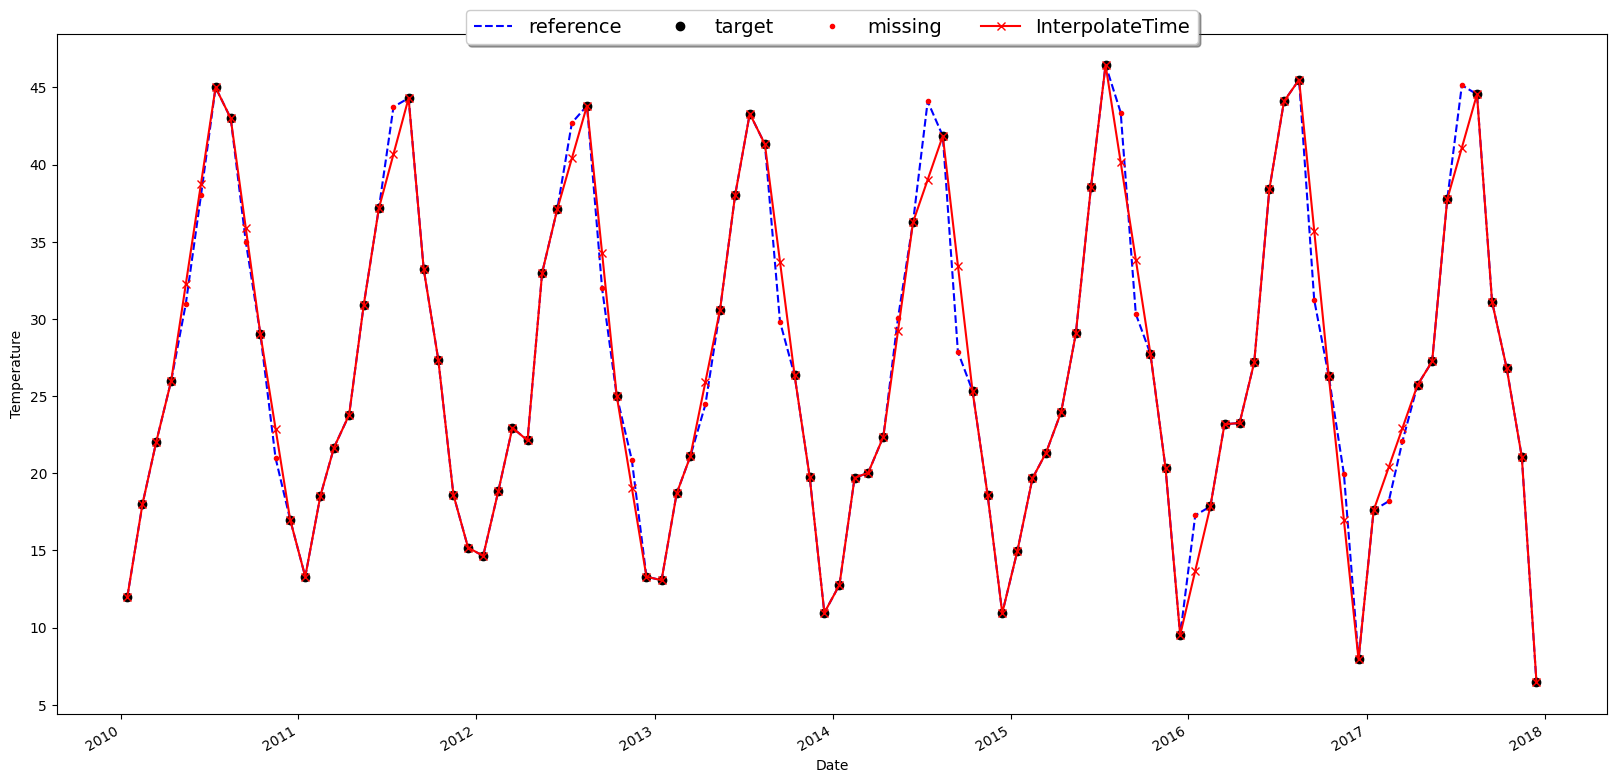

In [58]:
# data after imputation
final_df = waterConsumption_df[['reference', 'target', 'missing', 'InterpolateTime']]
final_df.plot(style=['b--', 'ko', 'r.', 'rx-'], figsize=(20, 10))
plt.ylabel('Temperature')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size':14}
          )

#### Example for Up-sampling frequency

Upsampling is nothing but increasing frequencies of the sample, example = months to days 

The data in Shampoo dataset is monthly, llets upsample i to daily and use interpolation scheme to fill in the new daily frequency

In [59]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

shampoo_df = pd.read_csv('/kaggle/input/time-series-data/shampoo.csv', header=0, index_col=0 , parse_dates=True, date_parser = parse).squeeze()

upsampled_ts = shampoo_df.resample('D').mean()
upsampled_ts.head(10)

Month
1901-01-01    266.0
1901-01-02      NaN
1901-01-03      NaN
1901-01-04      NaN
1901-01-05      NaN
1901-01-06      NaN
1901-01-07      NaN
1901-01-08      NaN
1901-01-09      NaN
1901-01-10      NaN
Freq: D, Name: Sales, dtype: float64

As we can see resample has created rows with NaN values, let use liner interpolation to fill in those values

In [60]:
interpolated = upsampled_ts.interpolate(method='linear')
interpolated.head()

Month
1901-01-01    266.000000
1901-01-02    262.125806
1901-01-03    258.251613
1901-01-04    254.377419
1901-01-05    250.503226
Freq: D, Name: Sales, dtype: float64

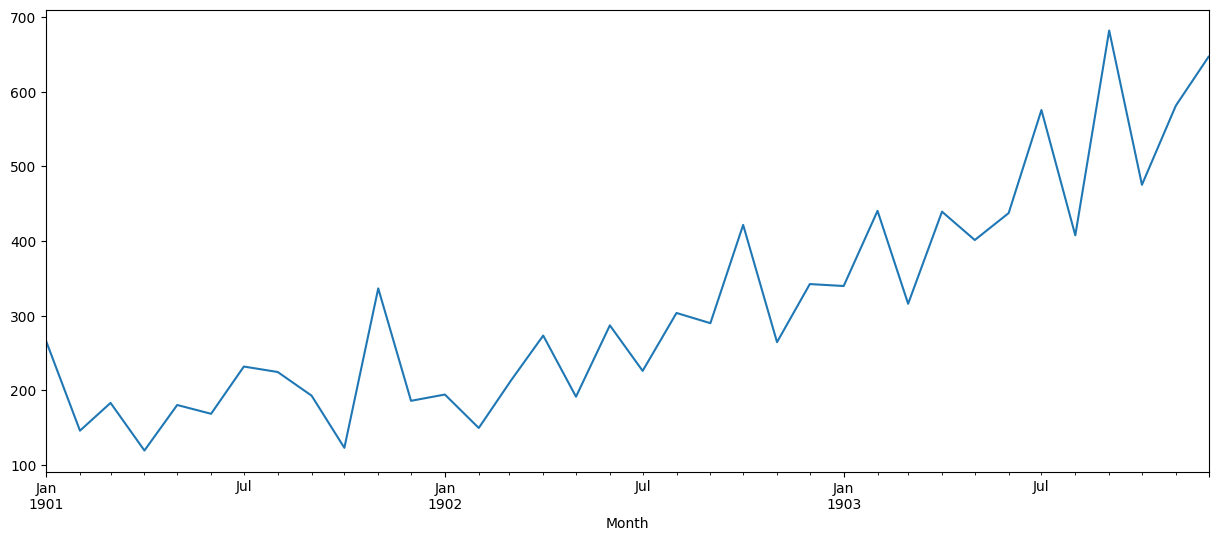

In [61]:
interpolated.plot()
plt.show()

lets try another method which we can use here is spline

In [62]:
interpolated_1 = upsampled_ts.interpolate(method='spline', order = 2)
interpolated_1.head()


Month
1901-01-01    266.000000
1901-01-02    258.630160
1901-01-03    251.560886
1901-01-04    244.720748
1901-01-05    238.109746
Freq: D, Name: Sales, dtype: float64

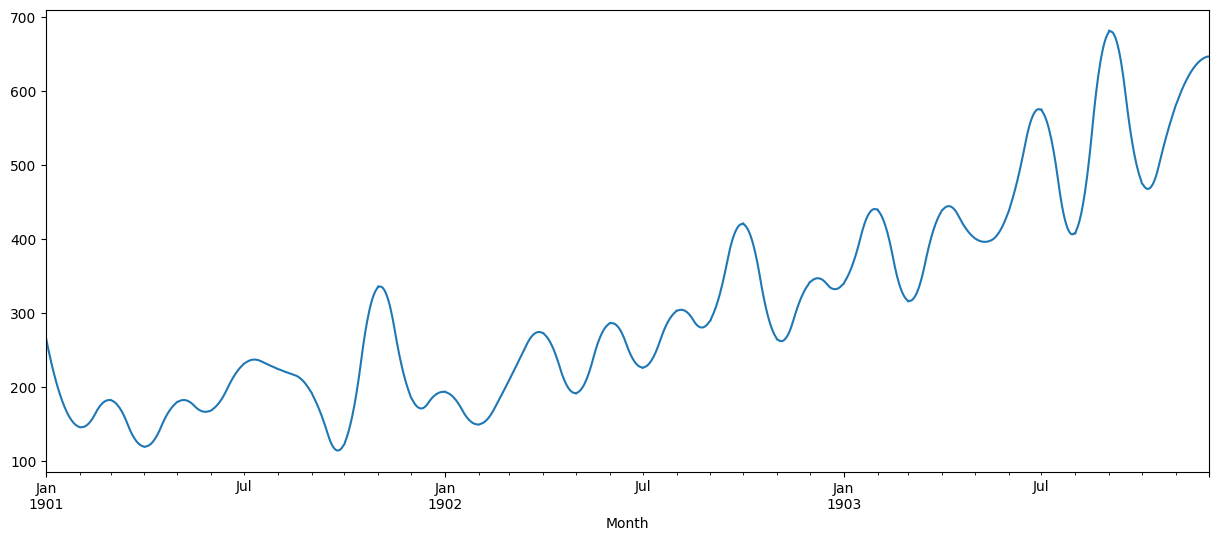

In [63]:
interpolated_1.plot()
plt.show()

#### Down-sampling example

DownSampling is the opposite of upsampling 
the sales data is monthly , and we prefer quaterly 

In [64]:
resample = shampoo_df.resample('Q')
quaterly_mean_sales = resample.mean()
quaterly_mean_sales.head()

Month
1901-03-31    198.333333
1901-06-30    156.033333
1901-09-30    216.366667
1901-12-31    215.100000
1902-03-31    184.633333
Freq: QE-DEC, Name: Sales, dtype: float64

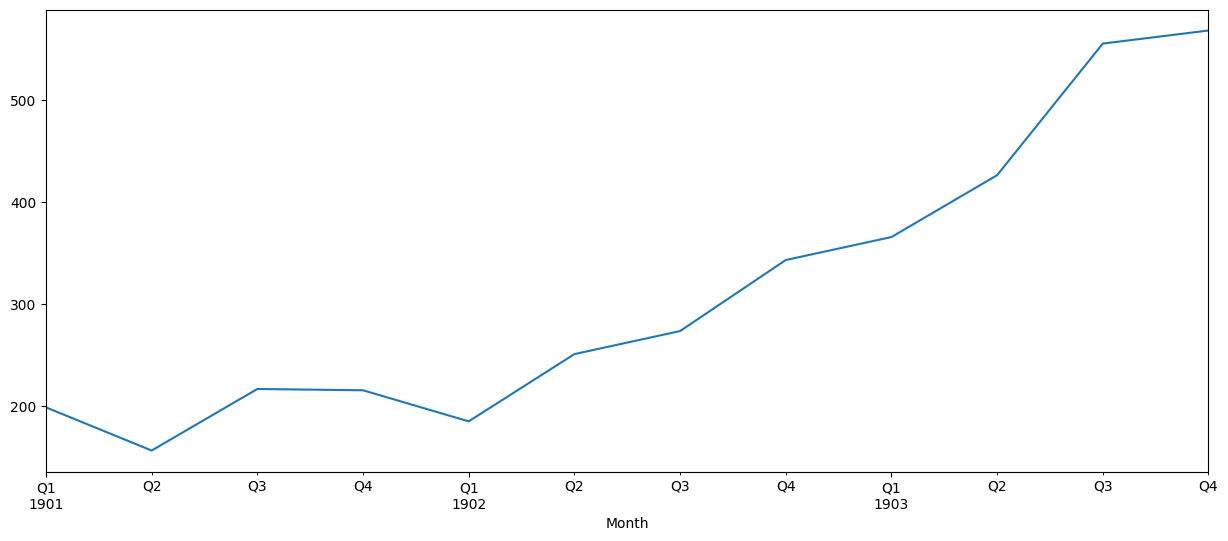

In [65]:
quaterly_mean_sales.plot()
plt.show()

Example where we turn monthly data to yearly using alis 'A' and use sum function to calculate total sales of each year

In [66]:
resample = shampoo_df.resample('A')
yearly_mean_sales = resample.sum()
yearly_mean_sales.head(10)

Month
1901-12-31    2357.5
1902-12-31    3153.5
1903-12-31    5742.6
Freq: YE-DEC, Name: Sales, dtype: float64

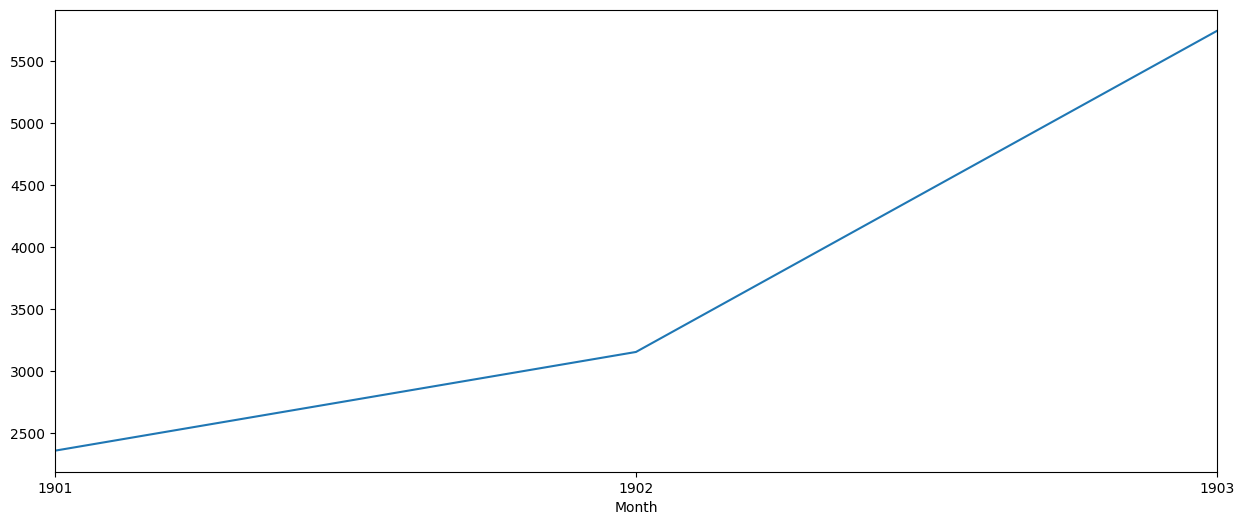

In [67]:
yearly_mean_sales.plot()
plt.show()

#### Handling Outliers

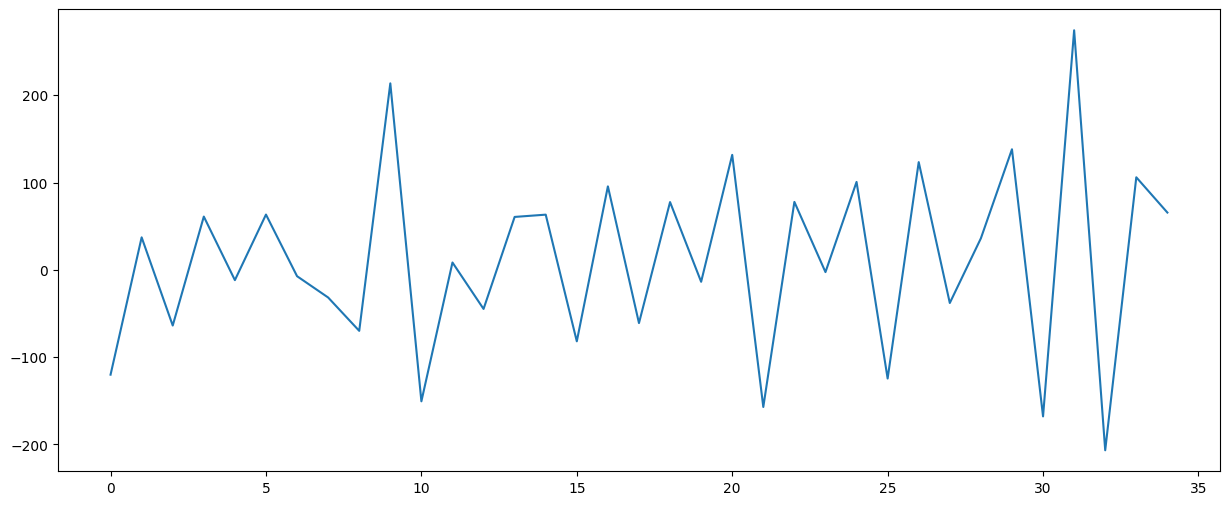

In [68]:
X = shampoo_df.values
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i-1]
    diff.append(value)
    
plt.plot(diff)
plt.show()

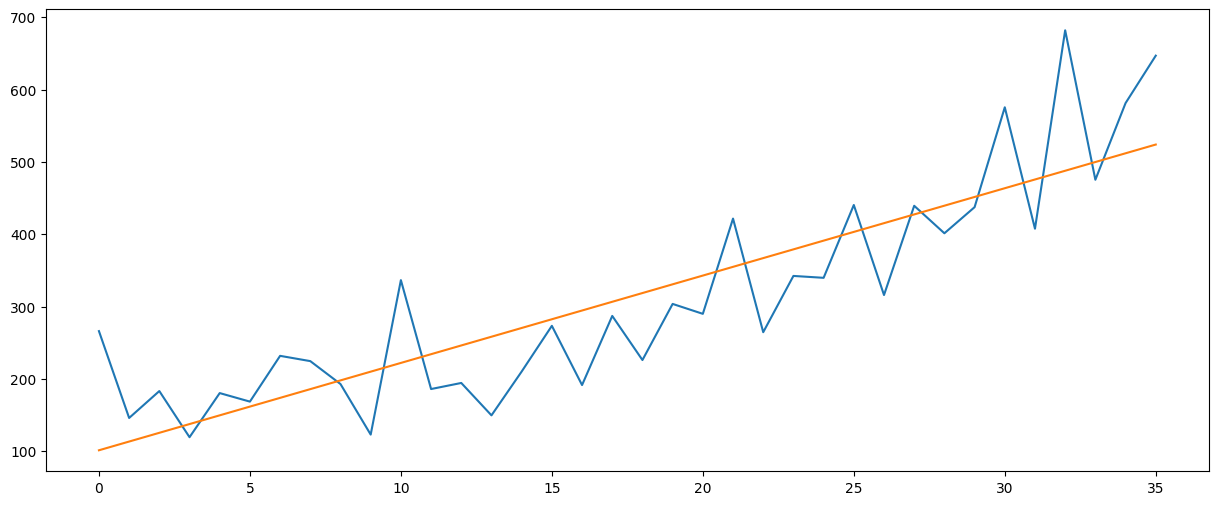

In [69]:
# detrend by model fitting

X = [i for i in range(0, len(shampoo_df))]
X = np.reshape(X, (len(X), 1))
y = shampoo_df.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

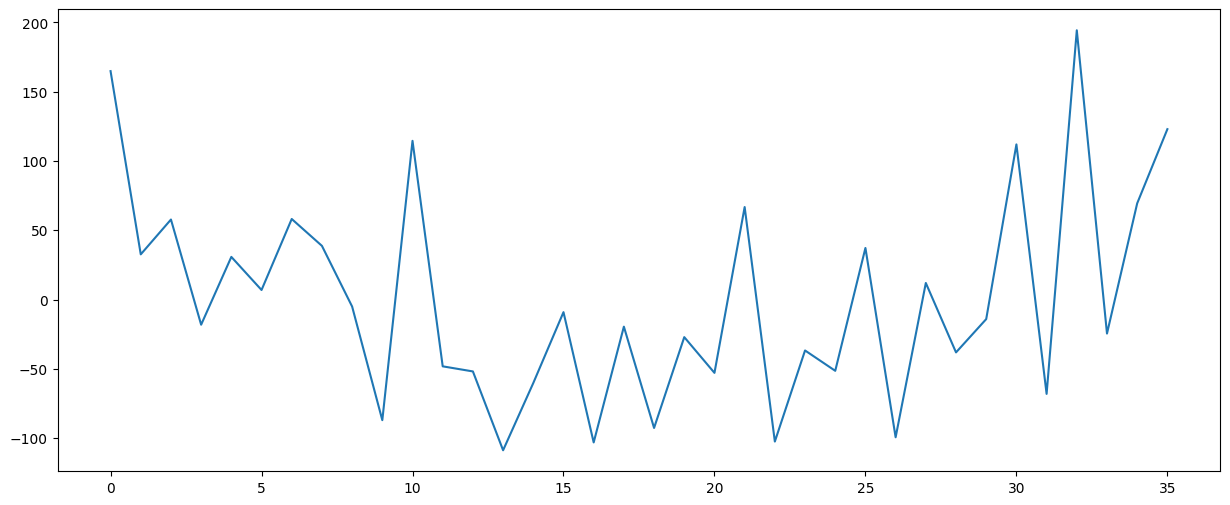

In [70]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(shampoo_df))]

#plot detrended
plt.plot(detrended)
plt.show()

#### testing Seasonal Adjustment / Deseasonalizing on daily minimum temperature

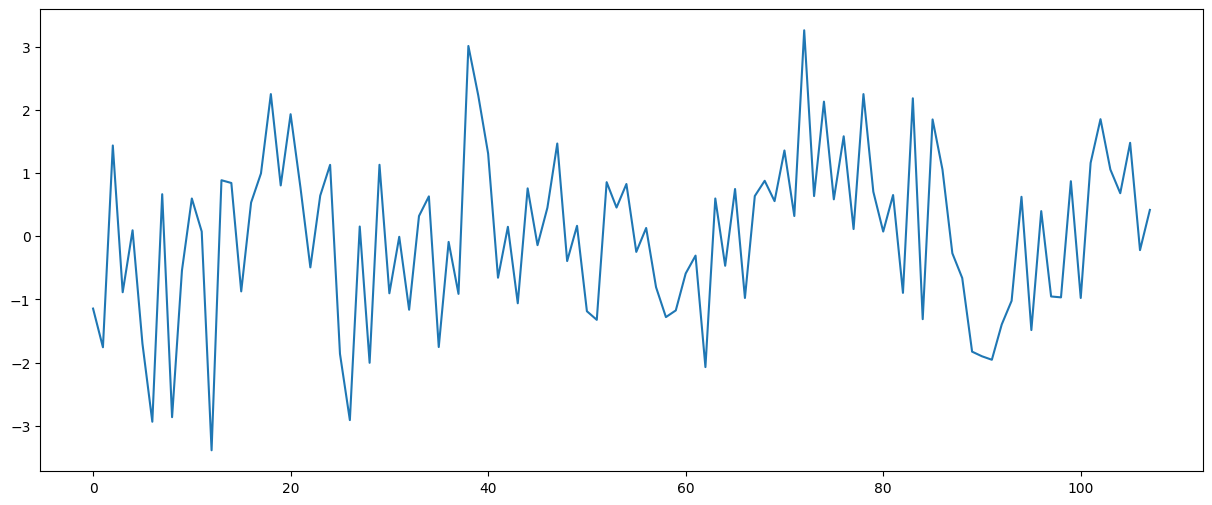

In [71]:
min_temperature = pd.read_csv('/kaggle/input/time-series-data/daily-min-temperatures.csv', header = 0, index_col=0, parse_dates=True).squeeze()
resample = min_temperature.resample('M')
monthly_mean = resample.mean()


X = min_temperature.values
diff = list()
months_in_year = 12

for i in range(months_in_year, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i-months_in_year]
    diff.append(value)
    
plt.plot(diff)
plt.show()

#### Accuracy measure

lets teake Daily Female Birth dataset, fit a moving average of window width 3 and evaluate the model measure such aas RMSE ( Root mean squared error ), MAPE ( Mean absolute Percentage error )

In [72]:
def MAE(y, yhat):
    diff = np.abs(np.array(y) - np.array(yhat))
    try:
        mae = round(np.mean(np.fabs(diff)), 3)
    except:
        print("Error while calculating MAE")
        mae = np.nan
    return mae


In [73]:
def MAPE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = round(np.mean(np.abs((y-yhat)/y))* 100, 2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape

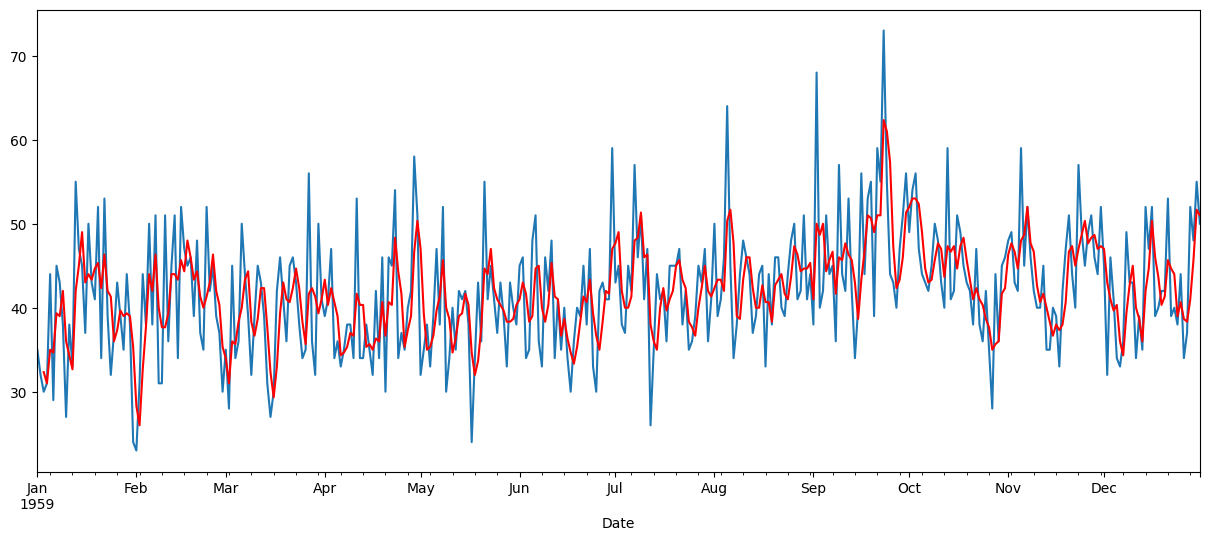

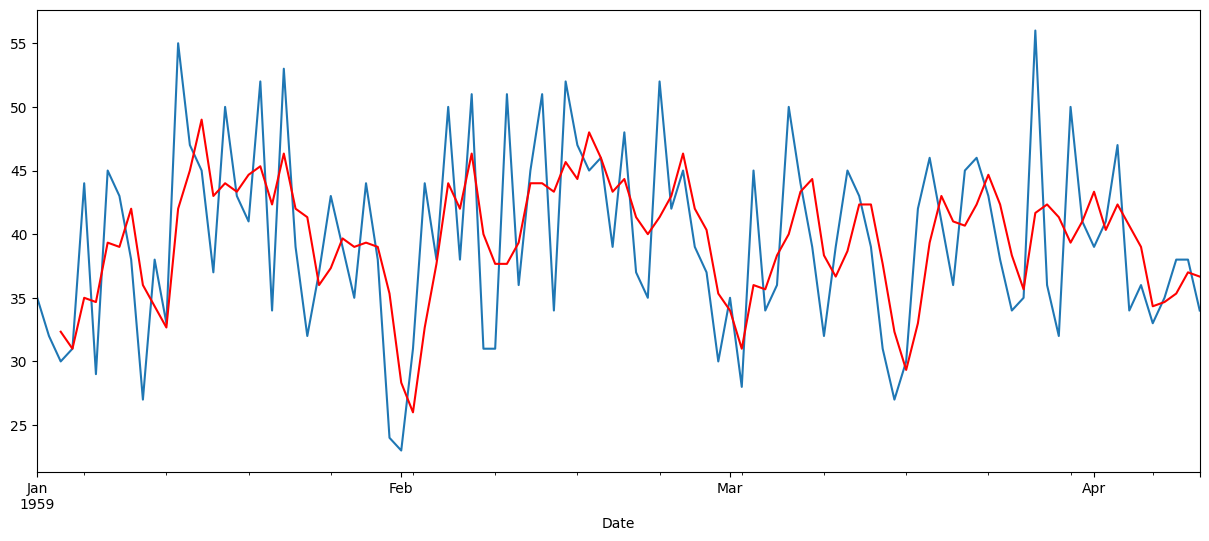

In [74]:
female_birth_series = pd.read_csv('/kaggle/input/time-series-data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True).squeeze()

# tail rolling average transform
rolling = female_birth_series.rolling(window = 3)
rolling_mean = rolling.mean()
female_birth_series.plot()

rolling_mean.plot(color = 'red')
plt.show()

# zoomed plot origianl and transformed dataset
female_birth_series[:100].plot()
rolling_mean[:100].plot(color = 'red')
plt.show()

In [75]:
y_df = pd.DataFrame({'Observed' : female_birth_series.values, 'Predicted': rolling_mean})
y_df.dropna(axis = 0, inplace = True)
print(y_df.tail())

            Observed  Predicted
Date                           
1959-12-27        37  38.333333
1959-12-28        52  41.000000
1959-12-29        48  45.666667
1959-12-30        55  51.666667
1959-12-31        50  51.000000


In [76]:
rmse = np.sqrt(mean_squared_error(y_df.Observed, y_df.Predicted))
print('\n\n Accuracy measures')
print('RMSE: %.3f' % rmse)

n = y_df.shape[0]

mae = MAE(y_df.Observed, y_df.Predicted)
print('MAE: %d' % float(mae))

mape = MAPE(y_df.Observed, y_df.Predicted)
print('MAPE: %.3f' % float(mape))



 Accuracy measures
RMSE: 5.435
MAE: 4
MAPE: 10.630


# ETS Model

ETS ( Error, Trend, Seasonality ) model is a univariate timeseries forecasting model

1) SES ( Simple exponential smoothing ) - ETS (A, N, N)
   - the method is suitable for forecasting data with no suitable trend or seasonality
   
   lets try this on petrol dataset

In [77]:
def MAPE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = round(np.sum(np.abs(y-yhat)) / np.sum(y) * 100, 2)
    except:
        print("Oserved values are empty")
        mape = np.nan
    return mape

In [78]:
petrol_df = pd.read_csv('/kaggle/input/time-series-data/Petrol.csv')
date_rng = pd.date_range(start = '1/1/2001', end='30/9/2013', freq = 'Q')
print(date_rng)

DatetimeIndex(['2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31',
               '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31',
               '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31',
               '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30'],
              dtype='datetime64[ns]', freq='QE-DEC')


In [79]:
petrol_df['TimeIndex'] = pd.DataFrame(date_rng, columns = ['Quater'])
petrol_df.head().T

0                    1                    2  \
Year                        2001                 2001                 2001   
Quarter                       Q1                   Q2                   Q3   
Consumption               14.978               11.099               10.057   
TimeIndex    2001-03-31 00:00:00  2001-06-30 00:00:00  2001-09-30 00:00:00   

                               3                    4  
Year                        2001                 2002  
Quarter                       Q4                   Q1  
Consumption               10.454                9.295  
TimeIndex    2001-12-31 00:00:00  2002-03-31 00:00:00

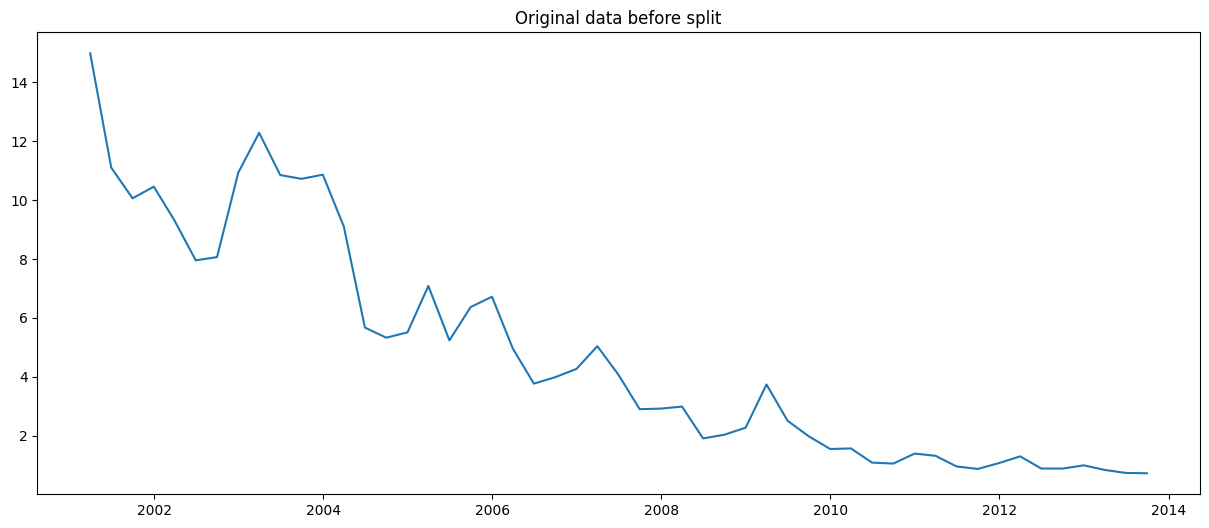

In [80]:
plt.plot(petrol_df.TimeIndex, petrol_df.Consumption)
plt.title('Original data before split')
plt.show()


 Training data start at 

   Year Quarter  Consumption  TimeIndex
0  2001      Q1       14.978 2001-03-31 ['Year', 'Quarter']

 Training data ends at 

    Year Quarter  Consumption  TimeIndex
34  2009      Q3      1.98159 2009-09-30 ['Year', 'Quarter']

 Test data start at 

    Year Quarter  Consumption  TimeIndex
35  2009      Q4      1.55221 2009-12-31 ['Year', 'Quarter']

 Test data ends at 

    Year Quarter  Consumption  TimeIndex
50  2013      Q3      0.72823 2013-09-30 ['Year', 'Quarter']


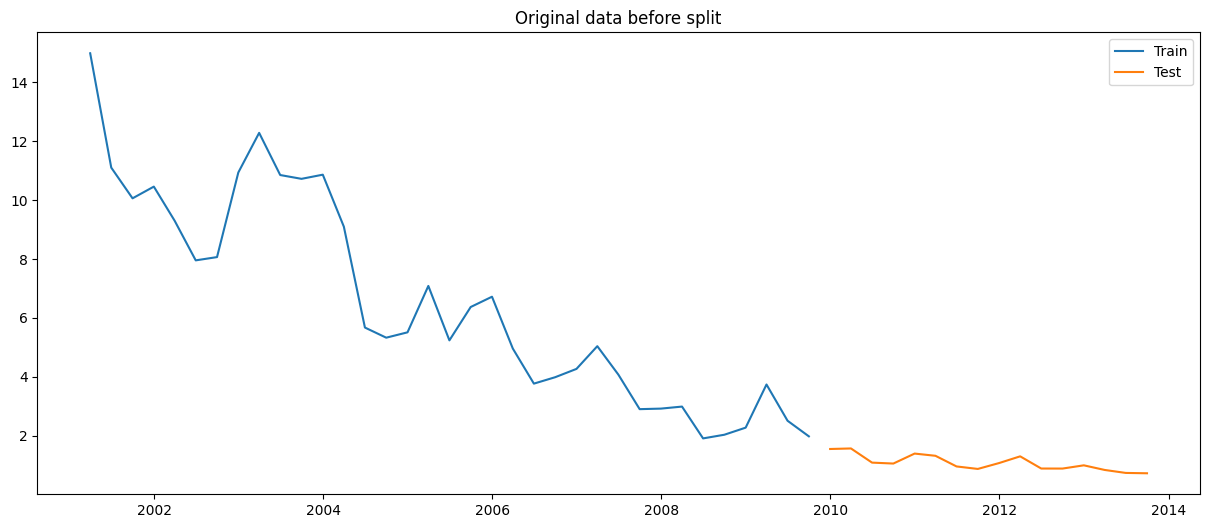

In [81]:
# creating train and test set

train = petrol_df[0:int(len(petrol_df)*0.7)]
test = petrol_df[int(len(petrol_df)*0.7):]

print("\n Training data start at \n")
print(train[train.TimeIndex == train.TimeIndex.min()], ['Year', 'Quarter'])
print("\n Training data ends at \n")
print(train[train.TimeIndex == train.TimeIndex.max()], ['Year', 'Quarter'])

print("\n Test data start at \n")
print(test[test.TimeIndex == test.TimeIndex.min()], ['Year', 'Quarter'])
print("\n Test data ends at \n")
print(test[test.TimeIndex == test.TimeIndex.max()], ['Year', 'Quarter'])

plt.plot(train.TimeIndex , train.Consumption, label = 'Train')
plt.plot(test.TimeIndex , test.Consumption, label = 'Test')
plt.legend(loc='best')
plt.title('Original data before split')
plt.show()


For Alpha  = 0.10, RMSE is 3.0712 MAPE is 283.19


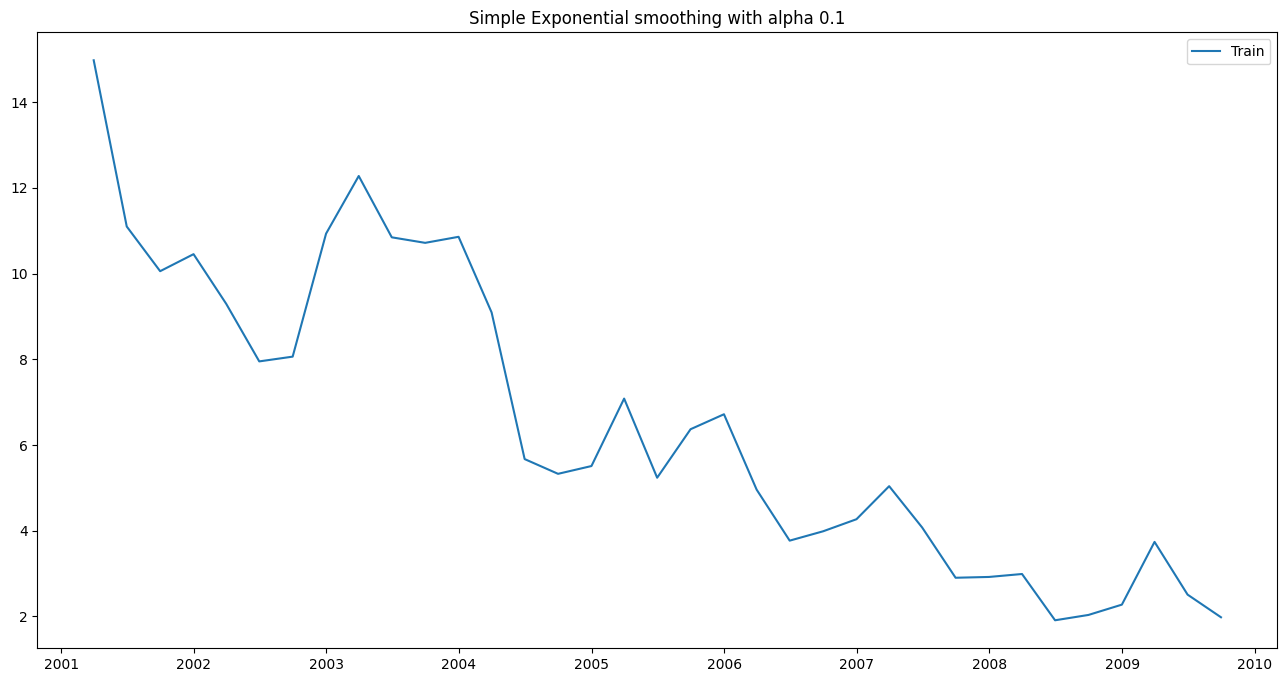

For Alpha  = 0.50, RMSE is 1.3166 MAPE is 119.40


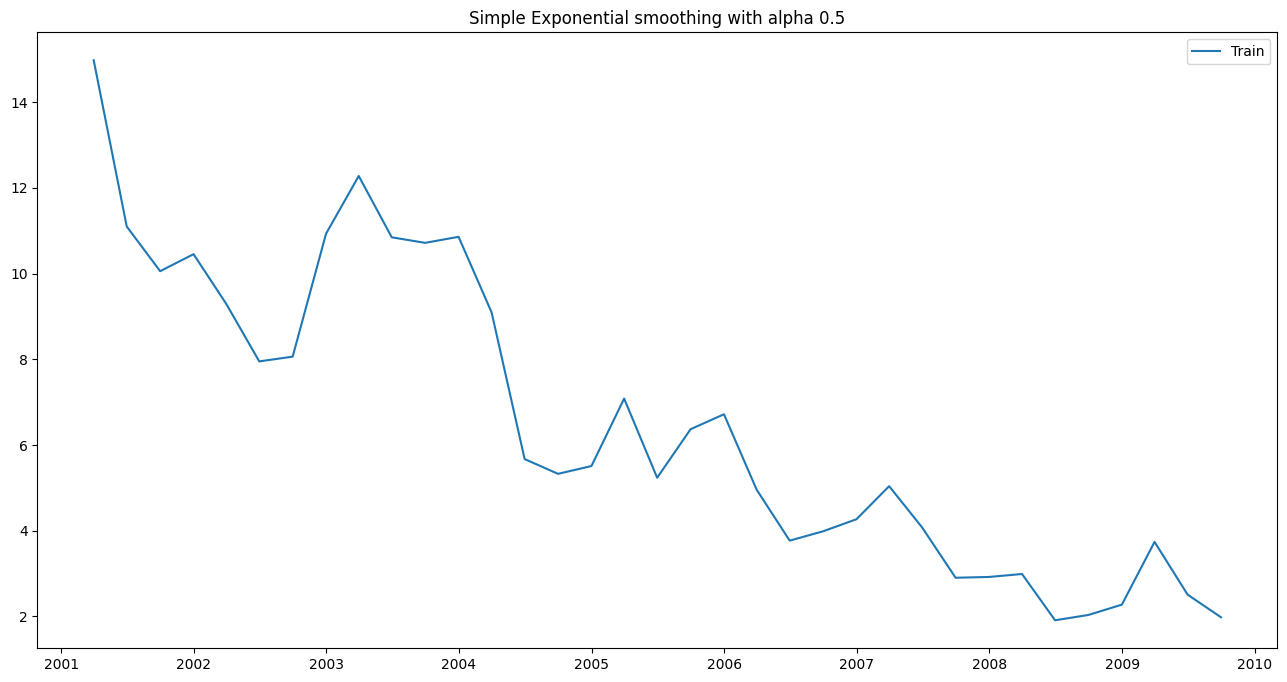

For Alpha  = 0.99, RMSE is 0.9438 MAPE is 83.89


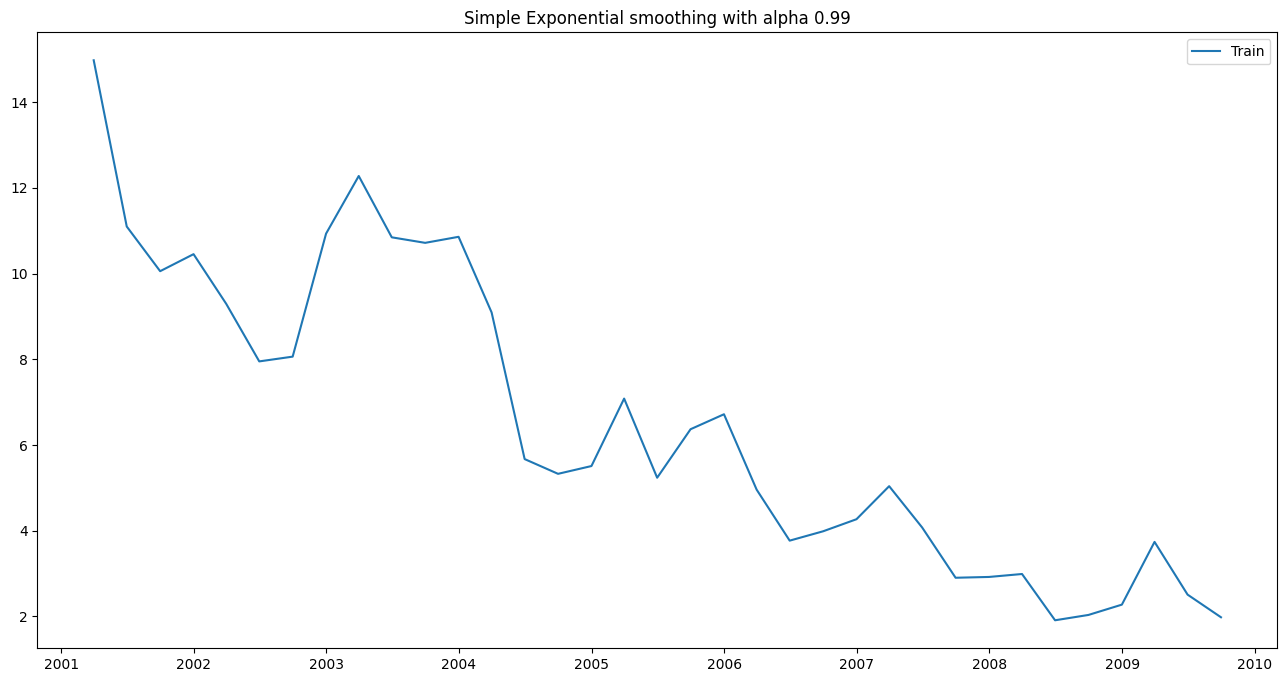

In [82]:
# create class
model = SimpleExpSmoothing(np.asarray(train['Consumption']))

# fit model

alpha_list = [0.1, 0.5 , 0.99]
pred_SES = test.copy()

for alpha in alpha_list:
    alpha_str = 'SES' + str(alpha)
    mode_fit_i = model.fit(smoothing_level = alpha, optimized = False)
    pred_SES[alpha_str] = mode_fit_i.forecast(len(test['Consumption']))
    rmse = np.sqrt(mean_squared_error(test['Consumption'], pred_SES[alpha_str]))
    mape = MAPE(test['Consumption'], pred_SES[alpha_str])
    
    print("For Alpha  = %.2f, RMSE is %3.4f MAPE is %3.2f" %(alpha, rmse, mape))
    
    plt.figure(figsize=(16, 8))
    plt.plot(train.TimeIndex, train['Consumption'], label = 'Train')
    plt.title('Simple Exponential smoothing with alpha ' + str(alpha))
    plt.legend(loc='best')
    plt.show()


 == Simple Exponential Smoothing 


 Smoothing level  1.0
Initial level 14.978

For alpha  = 1.00, RMSE is 0.9386 MAPE is 83.39


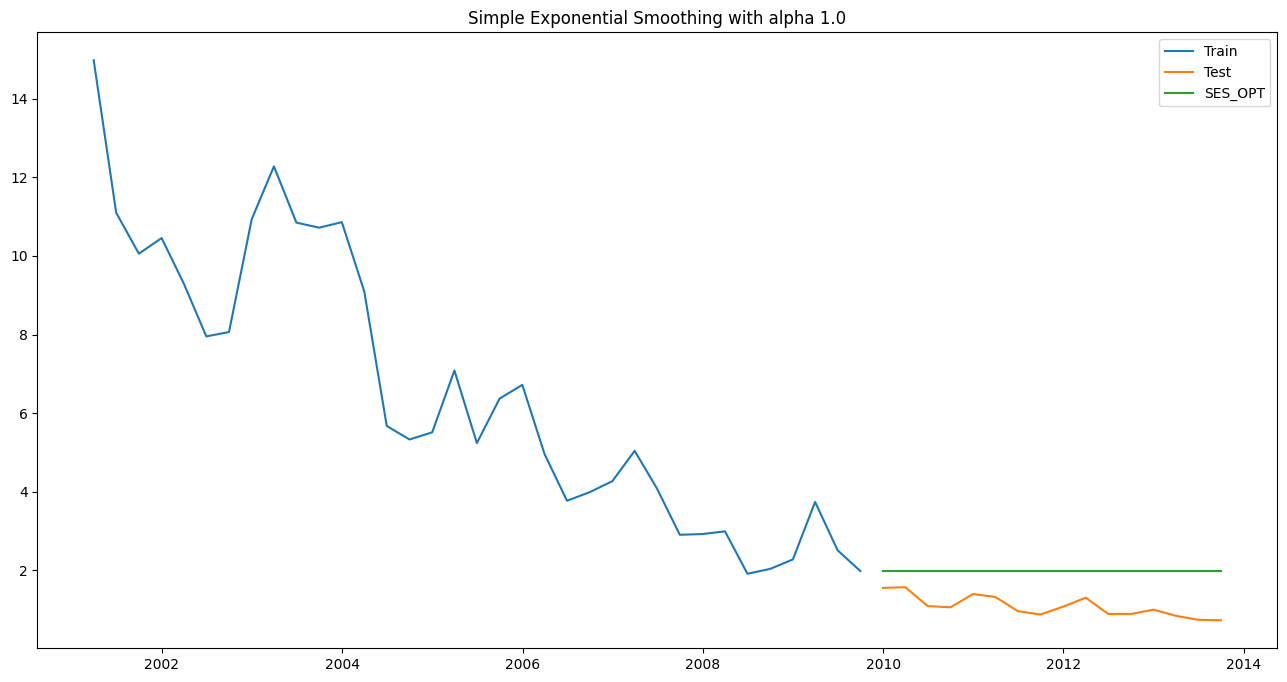

In [83]:
# let's get the optimum value and leave it for model to decide

pred_opt = SimpleExpSmoothing(train['Consumption']).fit(optimized = True)
print('\n == Simple Exponential Smoothing \n')

print('\n Smoothing level ' , np.round(pred_opt.params['smoothing_level'], 4))
print('Initial level', np.round(pred_opt.params['initial_level'], 4))
print()

y_pred_opt = pred_opt.forecast(steps = 16)
df_pred_opt = pd.DataFrame({'Y_hat' : y_pred_opt, 'Y': test['Consumption'].values})

rmse_opt = np.sqrt(mean_squared_error(test['Consumption'], y_pred_opt))
mape_opt = MAPE(test['Consumption'], y_pred_opt)

alpha_value = np.round(pred_opt.params['smoothing_level'], 4)

print("For alpha  = %1.2f, RMSE is %3.4f MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))

plt.figure(figsize=(16, 8))
plt.plot(train.TimeIndex, train['Consumption'], label = 'Train')
plt.plot(test.TimeIndex, test['Consumption'], label = 'Test')
plt.plot(test.TimeIndex, y_pred_opt, label = 'SES_OPT')
plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
plt.legend(loc = 'best')
plt.show()

In [84]:
df_pred_opt.head().T

35       36       37       38       39
Y_hat  1.98159  1.98159  1.98159  1.98159  1.98159
Y      1.55221  1.57034  1.08986  1.05821  1.39665

#### Holt - ETS ( A, A, N ) - Holt's linear method with additive erros

In [85]:
model = Holt(np.asarray(train['Consumption']))

model_fit = model.fit()

print("\n == Holt model Exponential Smoothing Paramters == \n")
alpha_value = np.round(model_fit.params['smoothing_level'], 4)
print('Smoothing level', alpha_value)
print('Smoothing Slope', np.round(model_fit.params['smoothing_trend'], 4))
print('Initial level', np.round(model_fit.params['initial_level'], 4))




 == Holt model Exponential Smoothing Paramters == 

Smoothing level 1.0
Smoothing Slope 0.3446
Initial level 14.978


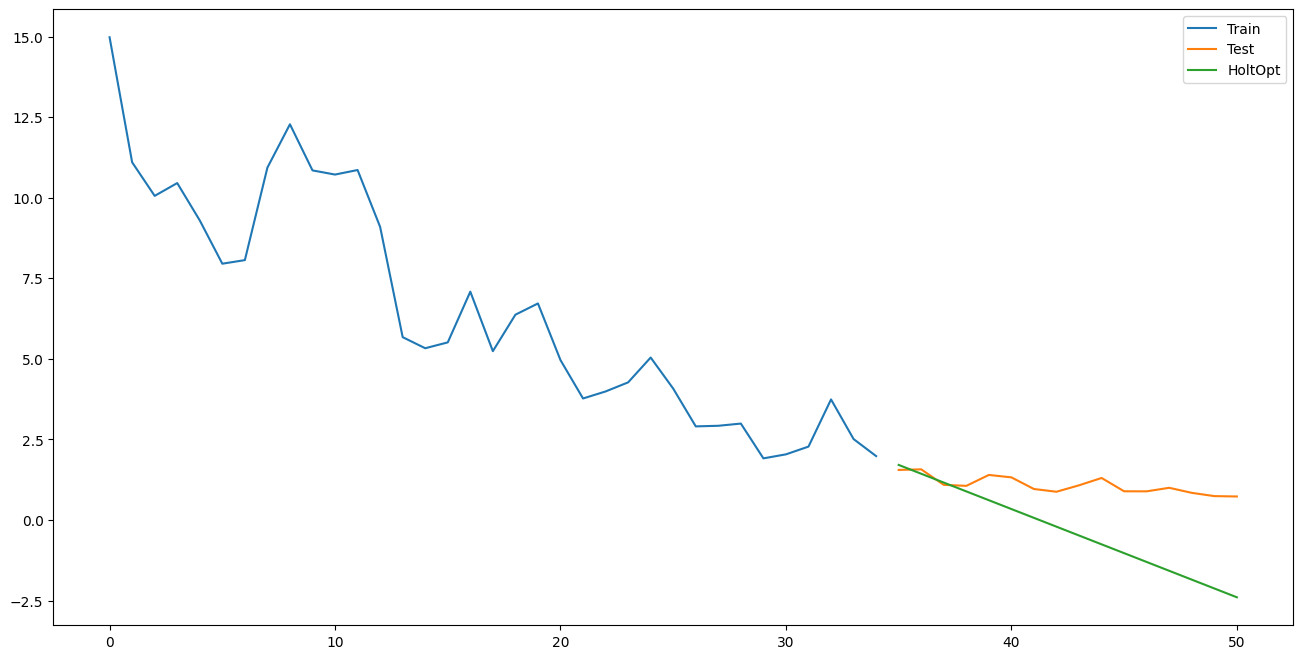

In [86]:
pred_Holt = test.copy()
pred_Holt['Opt'] = model_fit.forecast(len(test['Consumption']))

plt.figure(figsize=(16, 8))
plt.plot(train['Consumption'], label = 'Train')
plt.plot(test['Consumption'], label = 'Test')
plt.plot(pred_Holt['Opt'], label = 'HoltOpt')
plt.legend(loc = 'best')
plt.show()

In [87]:
df_pred_opt = pd.DataFrame({'Y_hat': pred_Holt['Opt'], 'Y' : test['Consumption'].values})
rmse_opt = np.sqrt(mean_squared_error(df_pred_opt.Y, df_pred_opt.Y_hat))

mape_opt = MAPE(df_pred_opt.Y, df_pred_opt.Y_hat)

print("For Alpha = %1.2f, RMSE is %3.4f, MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))


For Alpha = 1.00, RMSE is 1.7796, MAPE is 134.61


In [88]:
print(model_fit.params)

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.3445958044522474, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 14.978, 'initial_trend': -3.8789999999999996, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Holt-Winters - ETS( A, A, A)  - Holt Winters linear method with additive errors


Multi-Steps Forecast

In [89]:
pred_1 = ExponentialSmoothing(np.asarray(train['Consumption']), trend = 'additive', damped=False, seasonal='additive', seasonal_periods = 12).fit()
print('\n == Holt-Winters Additive ETS(A, A, A) Paramters == \n')
alpha_value = np.round(pred_1.params['smoothing_level'], 4)
print('Smoothing Level : ', alpha_value)
print('Smoothing Slope : ', np.round(pred_1.params['smoothing_trend'], 4))
print('Smoothing Seasonal : ', np.round(pred_1.params['smoothing_seasonal'], 4))

print('Initial Level : ', np.round(pred_1.params['initial_level']))
print('Initial Slope : ', np.round(pred_1.params['initial_trend'], 4))
print('Initial Seasonal : ', np.round(pred_1.params['initial_seasons'], 4))

y_pred_1 = pred_1.forecast(steps = 16)
df_pred_1 = pd.DataFrame({'Y_hat' : y_pred_1, 'Y': test['Consumption']})
print(df_pred_1)



 == Holt-Winters Additive ETS(A, A, A) Paramters == 

Smoothing Level :  1.0
Smoothing Slope :  0.0
Smoothing Seasonal :  0.0
Initial Level :  14.0
Initial Slope :  -0.369
Initial Seasonal :  [ 1.5517 -0.8344 -1.3178 -0.7499 -0.2197 -1.2738 -0.4491  1.0729  1.7918
  0.8771  1.0994  1.6797]
       Y_hat        Y
35  2.192938  1.55221
36  1.695979  1.57034
37 -1.059127  1.08986
38 -1.911562  1.05821
39 -1.712623  1.39665
40 -1.551390  1.32161
41 -2.974471  0.96034
42 -2.518719  0.87553
43 -1.365739  1.07530
44 -1.015791  1.30285
45 -2.299522  0.88939
46 -2.446216  0.88818
47 -2.234868  0.99804
48 -2.731827  0.84120
49 -5.486933  0.74032
50 -6.339369  0.72823


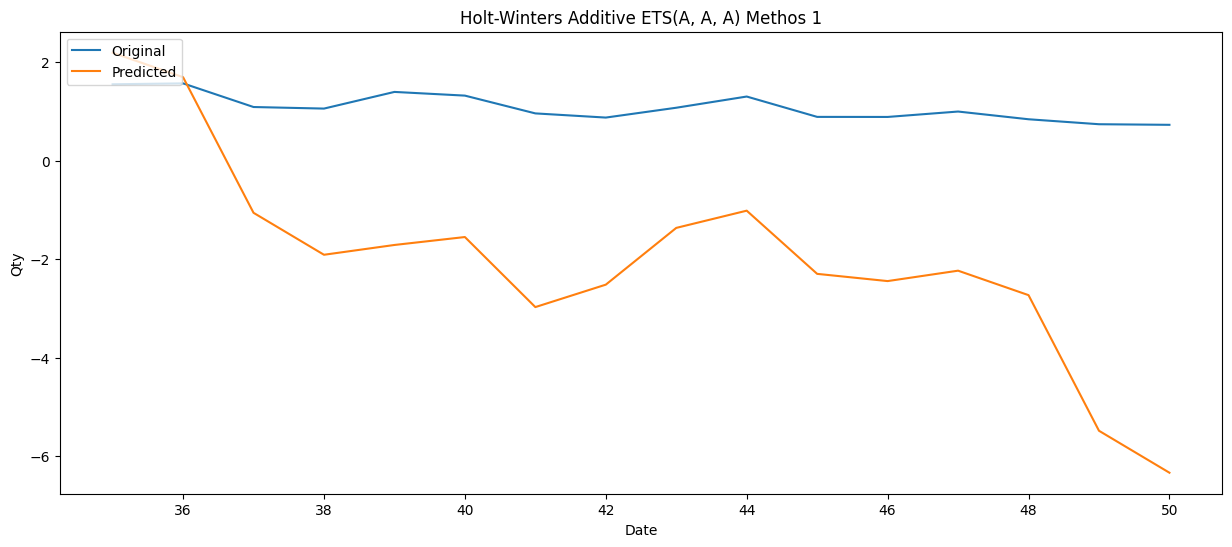

In [90]:
# Plot

fig_2, ax = plt.subplots()
ax.plot(df_pred_1.Y, label = 'Original')
ax.plot(df_pred_1.Y_hat, label = 'Predicted')

plt.legend(loc = 'upper left')
plt.title('Holt-Winters Additive ETS(A, A, A) Methos 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [91]:
rmse = np.sqrt(mean_squared_error(df_pred_1.Y, df_pred_1.Y_hat))
mape = MAPE(df_pred_1.Y, df_pred_1.Y_hat)

print("For alpha = %1.2f, RMSE is %3.4f and MAPE is %3.2f" %(alpha_value, rmse, mape))


For alpha = 1.00, RMSE is 3.5651 and MAPE is 292.57


In [92]:
print(pred_1.params)

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.0, 'smoothing_seasonal': 6.277064824929349e-10, 'damping_trend': nan, 'initial_level': 13.795005823931804, 'initial_trend': -0.36898385817204254, 'initial_seasons': array([ 1.55173062, -0.83439155, -1.31784308, -0.74992022, -0.21970306,
       -1.27380046, -0.4490641 ,  1.07289987,  1.79183097,  0.87708401,
        1.09937382,  1.67970592]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Lets try with passengers data

In [93]:
AirPax = pd.read_csv('/kaggle/input/time-series-data/AirPax.csv')
date_rng = pd.date_range(start = '1/1/1949', end = '31/12/1960', freq='M')
print(date_rng)

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='ME')


In [94]:
AirPax['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])
AirPax.head()

Year Month  Passenger  TimeIndex
0  1949   Jan        112 1949-01-31
1  1949   Feb        118 1949-02-28
2  1949   Mar        132 1949-03-31
3  1949   Apr        129 1949-04-30
4  1949   May        121 1949-05-31


 Training data starts at 

   Year Month  Passenger  TimeIndex
0  1949   Jan        112 1949-01-31 ['Year', 'Month']

 Training data ends at 

    Year Month  Passenger  TimeIndex
99  1957   Apr        348 1957-04-30 ['Year', 'Month']

Test data starts at 

     Year Month  Passenger  TimeIndex
100  1957   May        355 1957-05-31 ['Year', 'Month']

 Test data ends at 

     Year Month  Passenger  TimeIndex
143  1960   Dec        432 1960-12-31 ['Year', 'Month']


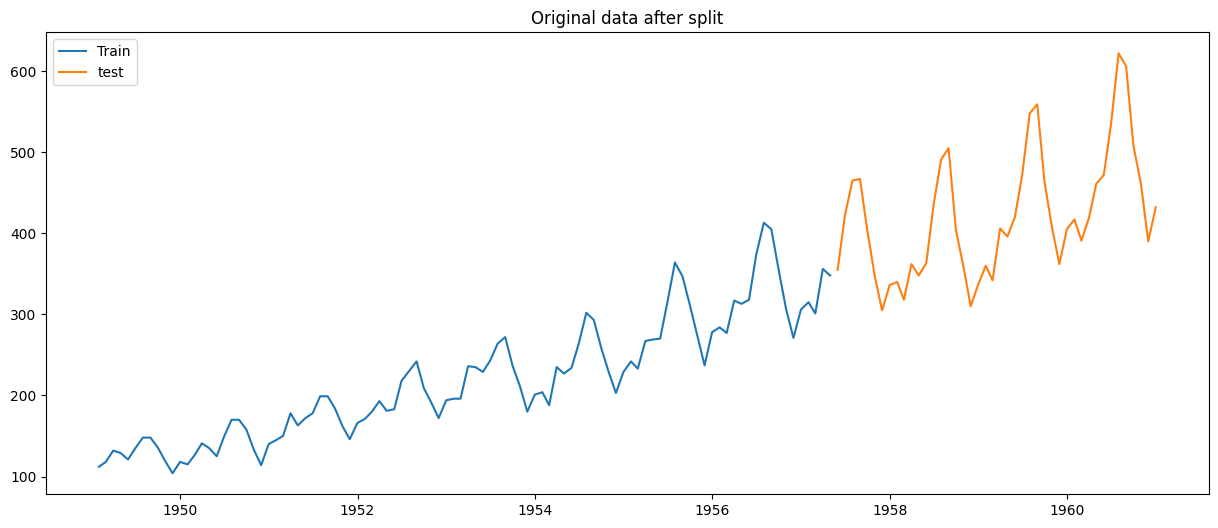

In [95]:
# Creating Train and test data
train = AirPax[0:int(len(AirPax)*0.7)]
test = AirPax[int(len(AirPax)* 0.7):]

print('\n Training data starts at \n')
print(train[train.TimeIndex == train.TimeIndex.min()], ['Year', 'Month'])
print('\n Training data ends at \n')
print(train[train.TimeIndex == train.TimeIndex.max()], ['Year', 'Month'])

print('\nTest data starts at \n')
print(test[test.TimeIndex == test.TimeIndex.min()], ['Year', 'Month'])
print('\n Test data ends at \n')
print(test[test.TimeIndex == test.TimeIndex.max()], ['Year', 'Month'])


plt.plot(train.TimeIndex, train.Passenger, label = 'Train')
plt.plot(test.TimeIndex, test.Passenger, label = 'test')
plt.legend(loc = 'best')
plt.title('Original data after split')
plt.show()

In [96]:
pred = ExponentialSmoothing(np.asarray(train['Passenger']), 
                           seasonal_periods = 12, seasonal = 'add').fit(optimized=True)
print(pred.params)
print('\n Holt-Winters additive ETS(A, A, A) Parameters \n')
alpha_value  = np.round(pred.params['smoothing_level'], 4)
print('Smoothing level : ', alpha_value)
print('Smoothing Slope : ', np.round(pred.params['smoothing_trend'], 4))
print('Smoothing Seasonal : ', np.round(pred.params['smoothing_seasonal'], 4))

print('Initial Level : ', np.round(pred.params['initial_level'], 4))
print('Initial Slope : ', np.round(pred.params['initial_trend'], 4))
print('Inital Seasons : ', np.round(pred.params['initial_seasons'], 4))



{'smoothing_level': 0.9999999850988388, 'smoothing_trend': nan, 'smoothing_seasonal': 1.4871342180899997e-08, 'damping_trend': nan, 'initial_level': 130.56392983762416, 'initial_trend': nan, 'initial_seasons': array([-18.56392409, -22.24964533,   7.50908895,  -0.62105779,
        -2.89249485,  22.83607142,  47.31464502,  43.29322054,
        12.77178596, -17.62464673, -44.6460729 , -21.29250265]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}

 Holt-Winters additive ETS(A, A, A) Parameters 

Smoothing level :  1.0
Smoothing Slope :  nan
Smoothing Seasonal :  0.0
Initial Level :  130.5639
Initial Slope :  nan
Inital Seasons :  [-18.5639 -22.2496   7.5091  -0.6211  -2.8925  22.8361  47.3146  43.2932
  12.7718 -17.6246 -44.6461 -21.2925]


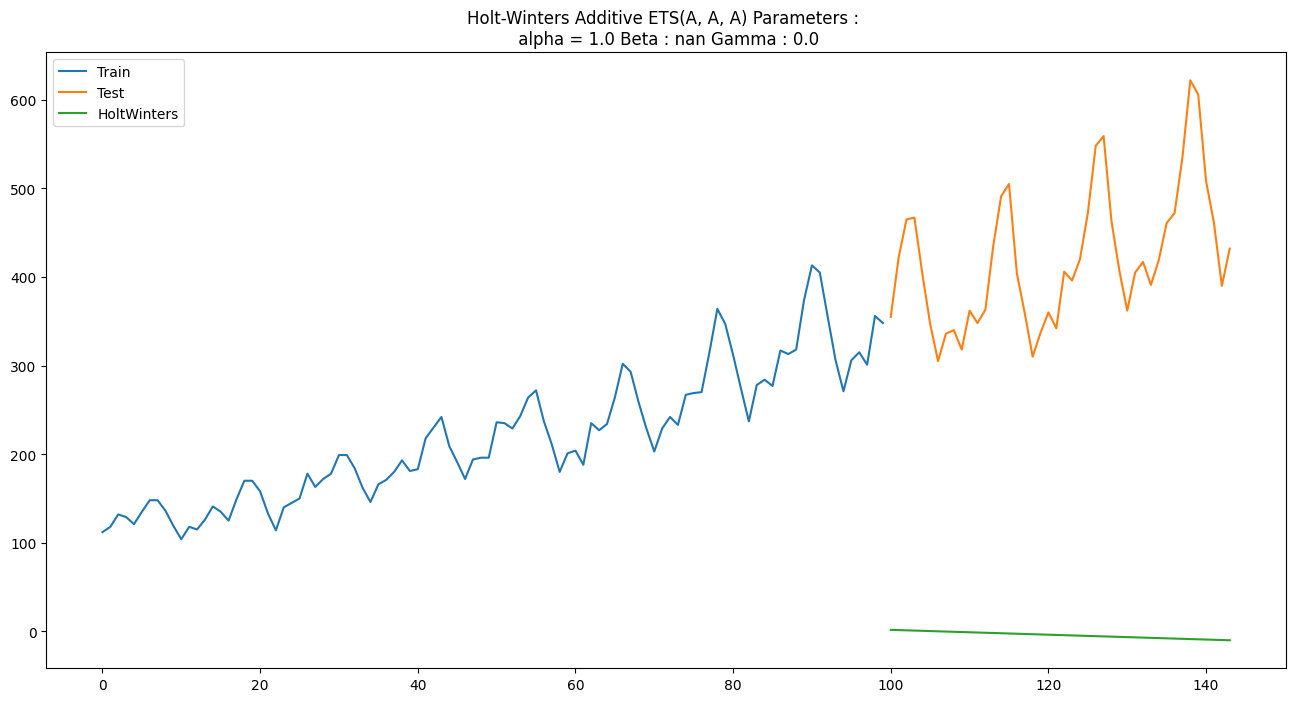

In [97]:
pred_HoltW = test.copy()
pred_HoltW['HoltW'] = model_fit.forecast(len(test['Passenger']))
plt.figure(figsize=(16, 8))
plt.plot(train['Passenger'], label = 'Train')
plt.plot(test['Passenger'], label = 'Test')
plt.plot(pred_HoltW['HoltW'], label = 'HoltWinters')
plt.title('Holt-Winters Additive ETS(A, A, A) Parameters : \n alpha = ' + str(alpha_value) + 
         ' Beta : ' + str(np.round(pred.params['smoothing_trend'], 4)) +
         ' Gamma : ' + str(np.round(pred.params['smoothing_seasonal'], 4))
         )
plt.legend(loc = 'best')
plt.show()

In [98]:
df_pred_opt = pd.DataFrame({'Y_hat': pred_HoltW['HoltW'], 'Y': test['Passenger'].values})

rmse_opt = np.sqrt(mean_squared_error(df_pred_opt.Y, df_pred_opt.Y_hat))
mape_opt = MAPE(df_pred_opt.Y, df_pred_opt.Y_hat)

print("For alpha = %1.2f, RMSE is %3.4f and MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))


For alpha = 1.00, RMSE is 432.3756 and MAPE is 100.99


#### Holt Winters - ETS(A, A, M) - Holt Winters linear method

Multi-steps Forecast on Air Passengers dataset

In [99]:
pred = ExponentialSmoothing(np.asarray(train['Passenger']), seasonal_periods = 12, seasonal = 'multiplicative').fit(optimized=True)

print(pred.params)

{'smoothing_level': 0.8806708730973173, 'smoothing_trend': nan, 'smoothing_seasonal': 0.0, 'damping_trend': nan, 'initial_level': 98.13898181887986, 'initial_trend': nan, 'initial_seasons': array([1.15164449, 1.11695894, 1.29037834, 1.24989228, 1.24025585,
       1.40187269, 1.55404587, 1.52466764, 1.34097695, 1.16264932,
       1.0050464 , 1.13472154]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [100]:
print('\n Holt Winters additive ETS(A, A, A) Parameters \n')
alpha_value = np.round(pred.params['smoothing_level'], 4)
print('Smoothing Level : ', alpha_value)
print('Smoothing Slope : ', np.round(pred.params['smoothing_trend'], 4))
print('Smoothing Seasonal : ', np.round(pred.params['smoothing_seasonal'], 4))

print('Inital Level : ', np.round(pred.params['initial_level'], 4))
print('Initial Slope : ', np.round(pred.params['initial_trend'], 4))
print('Initial Seasons : ', np.round(pred.params['initial_seasons'], 4))



 Holt Winters additive ETS(A, A, A) Parameters 

Smoothing Level :  0.8807
Smoothing Slope :  nan
Smoothing Seasonal :  0.0
Inital Level :  98.139
Initial Slope :  nan
Initial Seasons :  [1.1516 1.117  1.2904 1.2499 1.2403 1.4019 1.554  1.5247 1.341  1.1626
 1.005  1.1347]


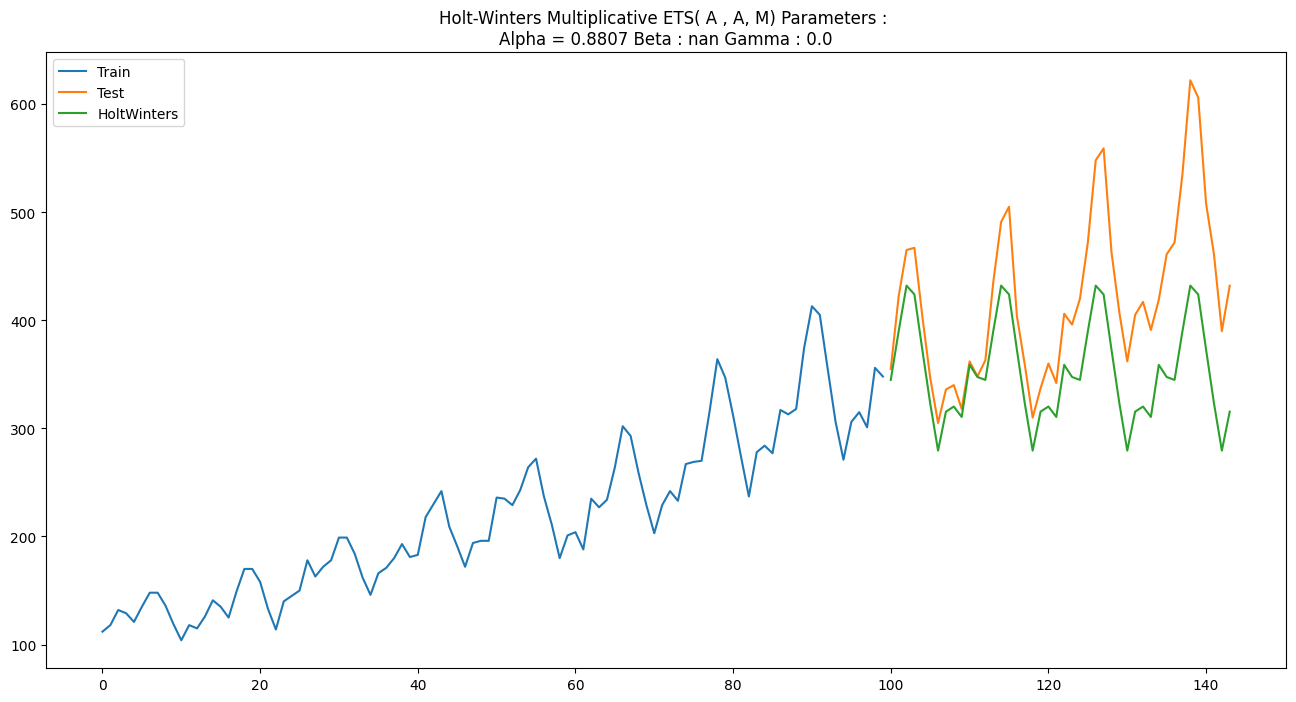

In [101]:
pred_HoltW = test.copy()

pred_HoltW['HoltWM'] = pred.forecast(len(test['Passenger']))
plt.figure(figsize=(16, 8))
plt.plot(train['Passenger'], label = 'Train')
plt.plot(test['Passenger'], label = 'Test')
plt.plot(pred_HoltW['HoltWM'], label = 'HoltWinters')
plt.title('Holt-Winters Multiplicative ETS( A , A, M) Parameters : \nAlpha = ' +
         str(alpha_value)+' Beta : ' +
         str(np.round(pred.params['smoothing_trend'], 4)) + 
          ' Gamma : ' + str(np.round(pred.params['smoothing_seasonal'], 4))
         )
plt.legend(loc = 'best')
plt.show()

In [102]:
df_pred_opt = pd.DataFrame({'Y_hat' : pred_HoltW['HoltWM'], 'Y': test['Passenger'].values})

rmse_opt = np.sqrt(mean_squared_error(df_pred_opt.Y, df_pred_opt.Y_hat))
mape_opt = MAPE(df_pred_opt.Y, df_pred_opt.Y_hat)

print("For alpha = %1.2f, RMSE is %3.4f and MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))

For alpha = 0.88, RMSE is 83.4360 and MAPE is 16.14


### Model Finalization

<Axes: >

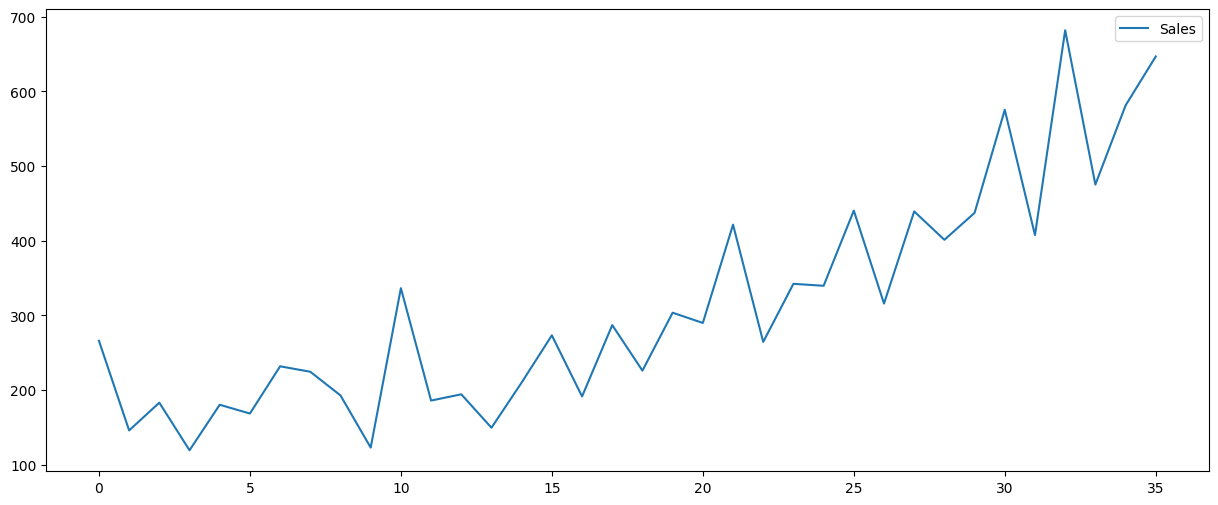

In [103]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

shampoo_df = pd.read_csv('/kaggle/input/time-series-data/shampoo.csv', header=0, parse_dates=True, date_parser=parse)

shampoo_df.head()
shampoo_df.plot()

<Axes: title={'center': 'Monthly Sales'}>

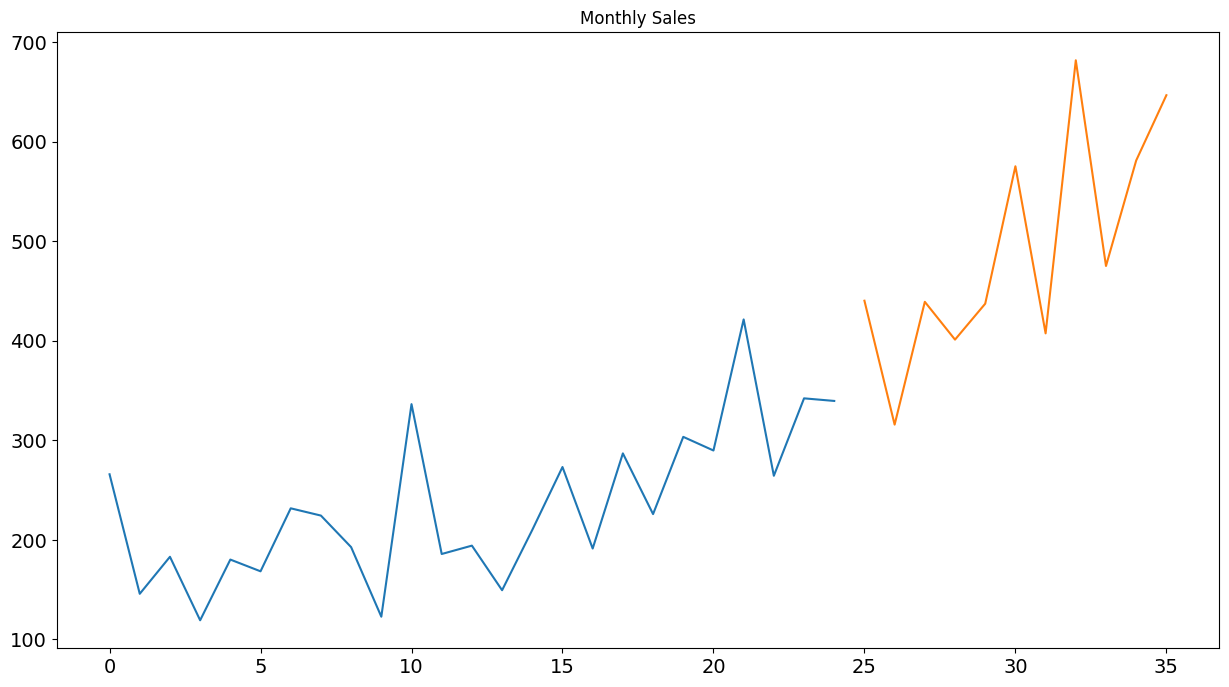

In [104]:
# creating train and test set
train = shampoo_df[0:int(len(shampoo_df)*0.7)]
test = shampoo_df[int(len(shampoo_df)*0.7):]

# Plot data

train['Sales'].plot(figsize=(15, 8), title='Monthly Sales', fontsize=14)
test['Sales'].plot(figsize=(15, 8), title='Monthly Sales', fontsize=14)

In [105]:
# Regression on time
shampoo_df_1 = shampoo_df.copy()
time = [i+1 for i in range(len(shampoo_df))]
shampoo_df_1['time'] = time
monthDf = shampoo_df_1[['Month']]

shampoo_df_1.drop('Month', axis = 1, inplace = True)
shampoo_df_1.head()

Sales  time
0  266.0     1
1  145.9     2
2  183.1     3
3  119.3     4
4  180.3     5

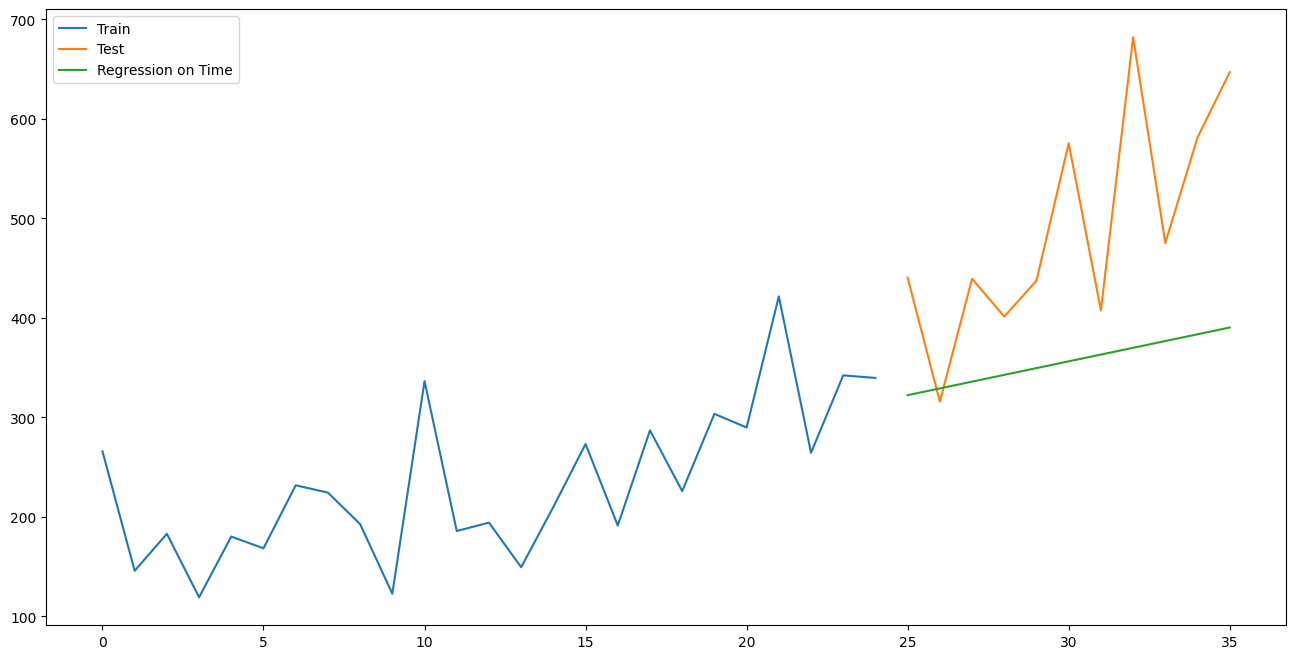

In [106]:
# creating train and test data
train = shampoo_df_1[0:int(len(shampoo_df_1)*0.7)]
test = shampoo_df_1[int(len(shampoo_df_1)*0.7):]

x_train = train.drop('Sales', axis = 1)
x_test = test.drop('Sales', axis = 1)
y_train = train[['Sales']]
y_test = test[['Sales']]

model = LinearRegression()
model.fit(x_train, y_train)

predictions = model.predict(x_test)
y_test['RegOnTime'] = predictions

plt.figure(figsize=(16, 8))
plt.plot(train['Sales'] , label = 'Train')
plt.plot(test['Sales'], label = 'Test')
plt.plot(y_test['RegOnTime'], label = 'Regression on Time')
plt.legend(loc = 'best')

In [107]:
rmse = sqrt(mean_squared_error(test.Sales, y_test.RegOnTime))
rmse = round(rmse, 3)
mape = MAPE(test.Sales, y_test.RegOnTime)
print("For Regression on Time , RMSE id %3.3f and MAPE is %3.2f" %(rmse, mape))

For Regression on Time , RMSE id 164.563 and MAPE is 27.94


In [108]:
results_df = pd.DataFrame({'Method': ['RegressionOnTime'], 'rmse': [rmse], 'mape': [mape]})
results_df

Method     rmse   mape
0  RegressionOnTime  164.563  27.94

### Regression on Time with seasonal components

In [109]:
time  = [i+1 for i in range(len(shampoo_df))]
shampoo_df_1 = shampoo_df.copy()
shampoo_df_1['time'] = time
print(shampoo_df_1.head())
print(shampoo_df_1.shape[0])
monthSeasonality = ['m1', 'm2', 'm3', 'm4' , 'm5', 'm6', 'm7'
                   , 'm8', 'm9', 'm10', 'm11', 'm12']

  Month  Sales  time
0  1-01  266.0     1
1  1-02  145.9     2
2  1-03  183.1     3
3  1-04  119.3     4
4  1-05  180.3     5
36


In [110]:
shampoo_df_1['monthSeasonality'] = monthSeasonality * 3
shampoo_df_1.head()

Month  Sales  time monthSeasonality
0  1-01  266.0     1               m1
1  1-02  145.9     2               m2
2  1-03  183.1     3               m3
3  1-04  119.3     4               m4
4  1-05  180.3     5               m5

In [111]:
month_df = shampoo_df_1[['Month']]
shampoo_df_1.drop('Month', axis = 1, inplace = True)
shampoo_df_1Complete = pd.get_dummies(shampoo_df_1, drop_first=True)
shampoo_df_1Complete.head().T

0      1      2      3      4
Sales                 266.0  145.9  183.1  119.3  180.3
time                      1      2      3      4      5
monthSeasonality_m10  False  False  False  False  False
monthSeasonality_m11  False  False  False  False  False
monthSeasonality_m12  False  False  False  False  False
monthSeasonality_m2   False   True  False  False  False
monthSeasonality_m3   False  False   True  False  False
monthSeasonality_m4   False  False  False   True  False
monthSeasonality_m5   False  False  False  False   True
monthSeasonality_m6   False  False  False  False  False
monthSeasonality_m7   False  False  False  False  False
monthSeasonality_m8   False  False  False  False  False
monthSeasonality_m9   False  False  False  False  False

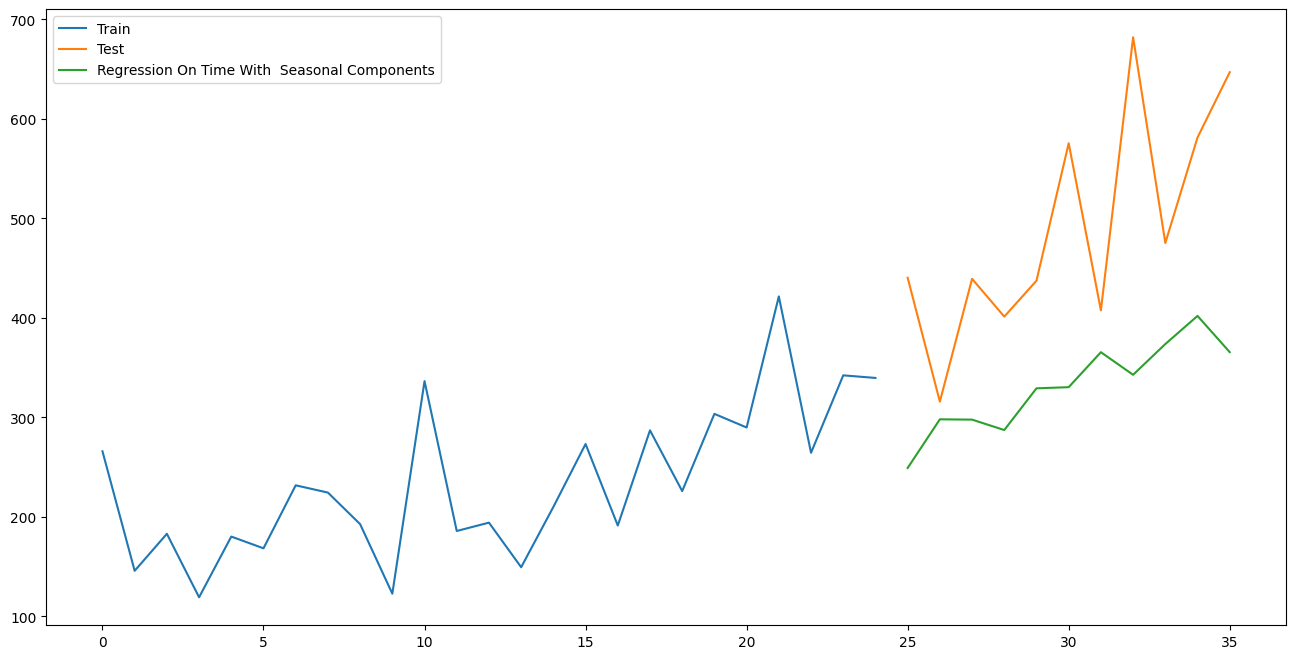

In [112]:
# Creating train and test data
train = shampoo_df_1Complete[0:int(len(shampoo_df_1Complete)*0.7)]
test = shampoo_df_1Complete[int(len(shampoo_df_1Complete)*0.7):]

x_train = train.drop('Sales', axis = 1)
x_test = test.drop('Sales', axis = 1)
y_train = train[['Sales']]
y_test = test[['Sales']]

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
y_test['RegOnTimeSeasonal'] = predictions


plt.figure(figsize=(16, 8))
plt.plot(train['Sales'], label = 'Train')
plt.plot(test['Sales'], label = 'Test')
plt.plot(y_test['RegOnTimeSeasonal'], label = 'Regression On Time With  Seasonal Components')
plt.legend(loc = 'best')

In [113]:
rmse = sqrt(mean_squared_error(test.Sales, y_test.RegOnTimeSeasonal))
rmse = round(rmse, 3)
mape = MAPE(test.Sales, y_test.RegOnTimeSeasonal)
print("For RegOnTimeSeasonal, RMSE is %3.3f MAPE is %3.2f" %(rmse, mape))

For RegOnTimeSeasonal, RMSE is 185.864 MAPE is 32.59


In [114]:
tempResults_df= pd.DataFrame({'Method': ['RegressionOnTimeSeasonal'], 'rmse': [rmse], 'mape': [mape]})
results_df = pd.concat([results_df, tempResults_df])
results_df

Method     rmse   mape
0          RegressionOnTime  164.563  27.94
0  RegressionOnTimeSeasonal  185.864  32.59

#### Naive Approach 

Text(0.5, 1.0, 'Naive Forecast')

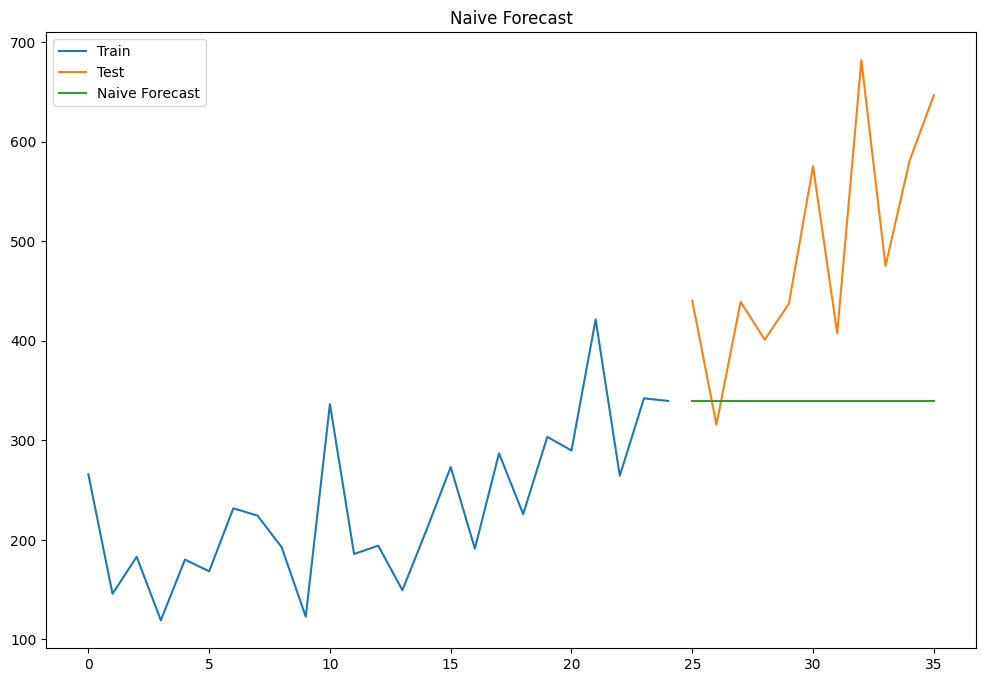

In [115]:
dd = np.asarray(train.Sales)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Sales'], label = 'Train')
plt.plot(test.index, test['Sales'], label = 'Test')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title("Naive Forecast")

In [116]:
rmse = sqrt(mean_squared_error(test.Sales, y_hat.naive))
rmse = round(rmse, 3)
mape = MAPE(test.Sales, y_hat.naive)
print("For Naive model, RMSE is %3.3f and MAPE if %3.2f" %(rmse , mape))


For Naive model, RMSE is 186.469 and MAPE if 31.72


In [117]:
tempResults_df = pd.DataFrame({'Method': ['Naive Method'], 'rmse': [rmse], 'mape': [mape]})
results_df = pd.concat([results_df, tempResults_df])
results_df

Method     rmse   mape
0          RegressionOnTime  164.563  27.94
0  RegressionOnTimeSeasonal  185.864  32.59
0              Naive Method  186.469  31.72

#### Simple Average

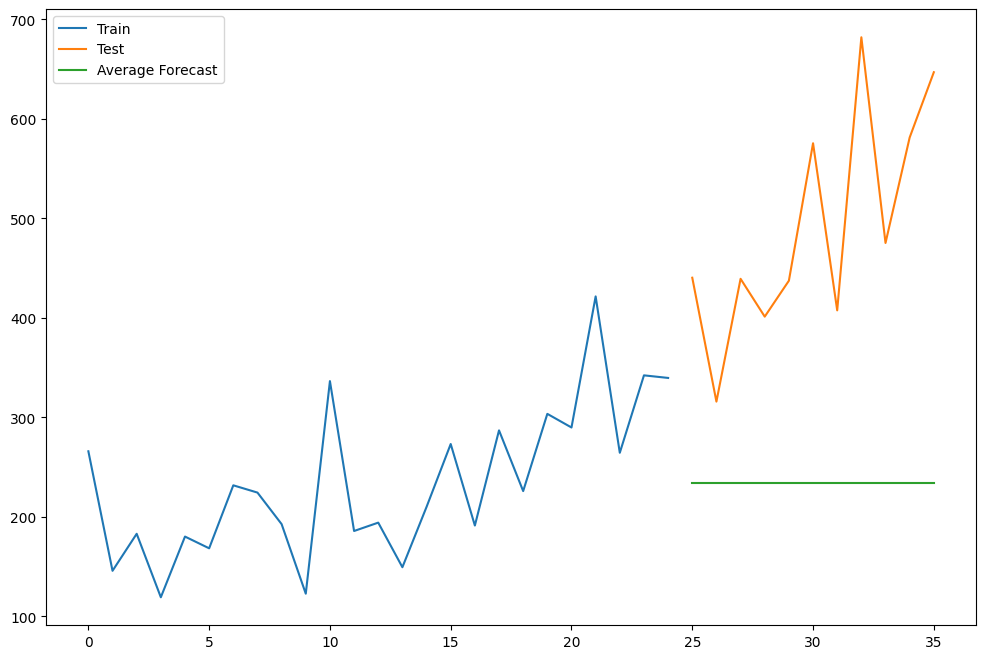

In [118]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()

plt.figure(figsize=(12, 8))
plt.plot(train['Sales'], label = 'Train')
plt.plot(test['Sales'], label = 'Test')
plt.plot(y_hat_avg['avg_forecast'], label = 'Average Forecast' )
plt.legend(loc = 'best')

In [119]:
rmse = sqrt(mean_squared_error(test.Sales, y_hat_avg.avg_forecast))
rmse = round(rmse, 3)

mape = MAPE(test.Sales, y_hat_avg.avg_forecast)
print("For Simple Average model, RMSE is %3.3f MAPE is %3.2f" %(rmse, mape))


tempResults_df = pd.DataFrame({'Method' : ['Simple Average'], 'rmse' : [rmse], 'mape' : [mape]})
results_df = pd.concat([results_df, tempResults_df])
results_df

For Simple Average model, RMSE is 279.196 MAPE is 52.35


Method     rmse   mape
0          RegressionOnTime  164.563  27.94
0  RegressionOnTimeSeasonal  185.864  32.59
0              Naive Method  186.469  31.72
0            Simple Average  279.196  52.35

#### Moving Average

For Simple Average model, moving_avg_forecast_4 RMSE is 75.514 MAPE is 13.05
For Simple Average model, moving_avg_forecast_6 RMSE is 88.576 MAPE is 14.62
For Simple Average model, moving_avg_forecast_8 RMSE is 105.158 MAPE is 17.03
For Simple Average model, moving_avg_forecast_12 RMSE is 134.071 MAPE is 22.79


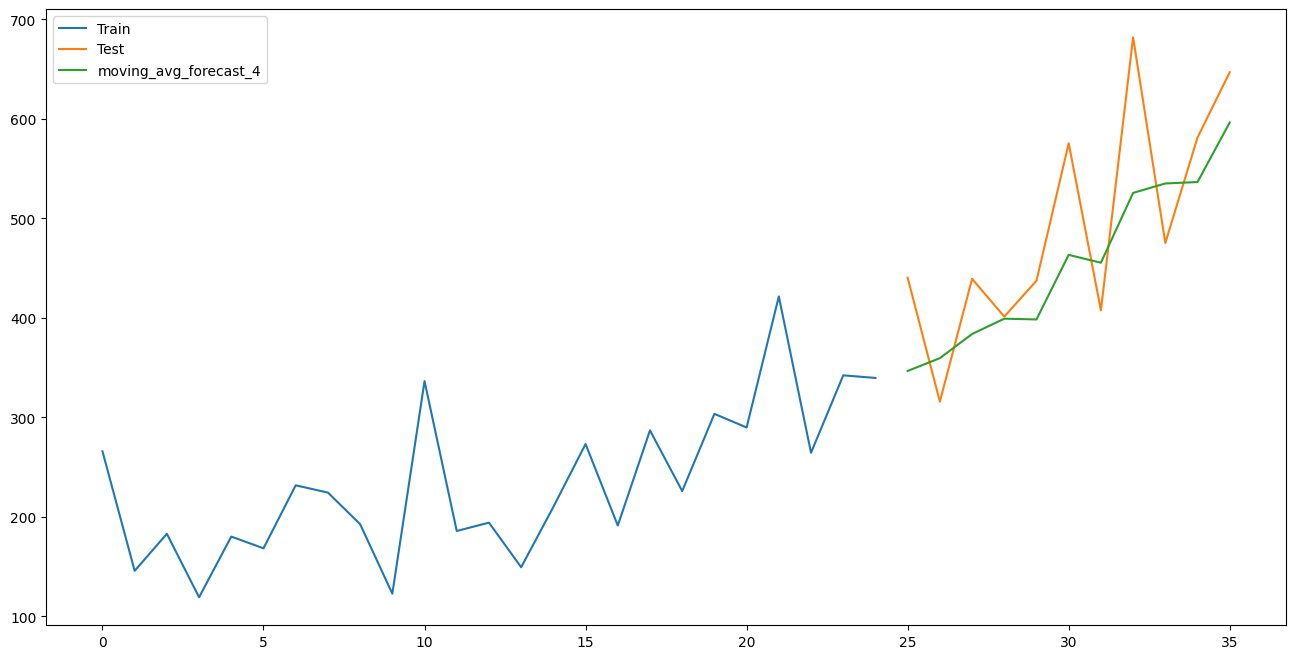

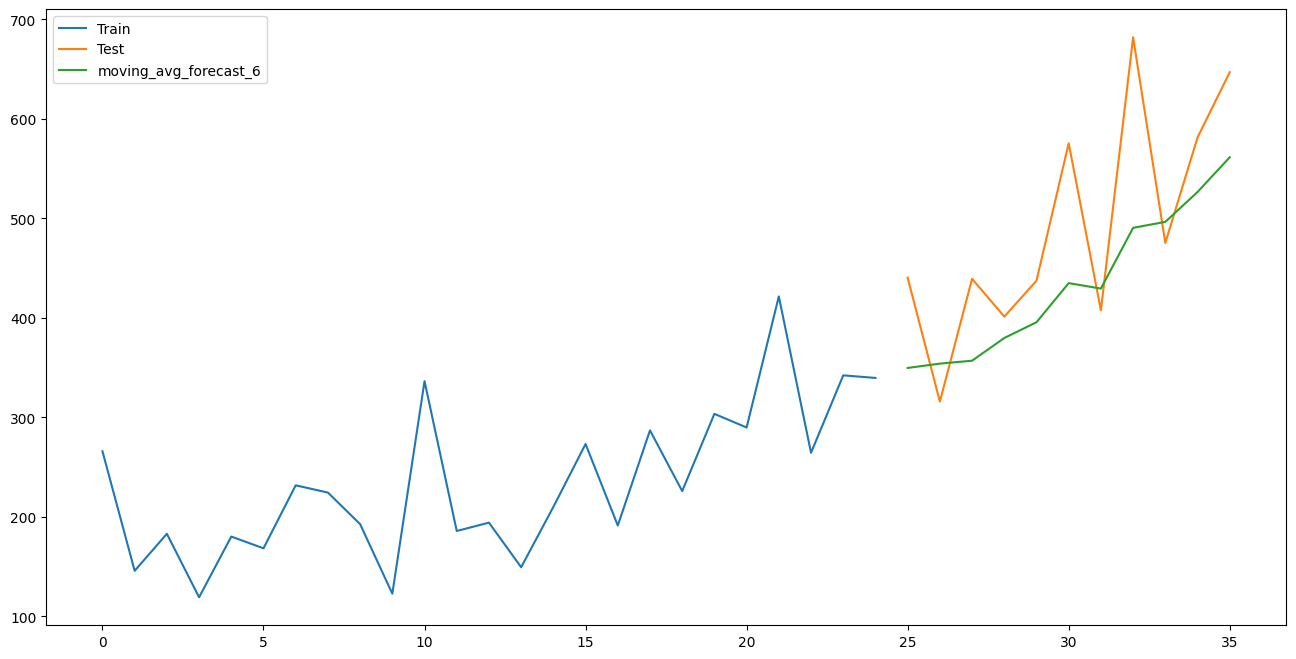

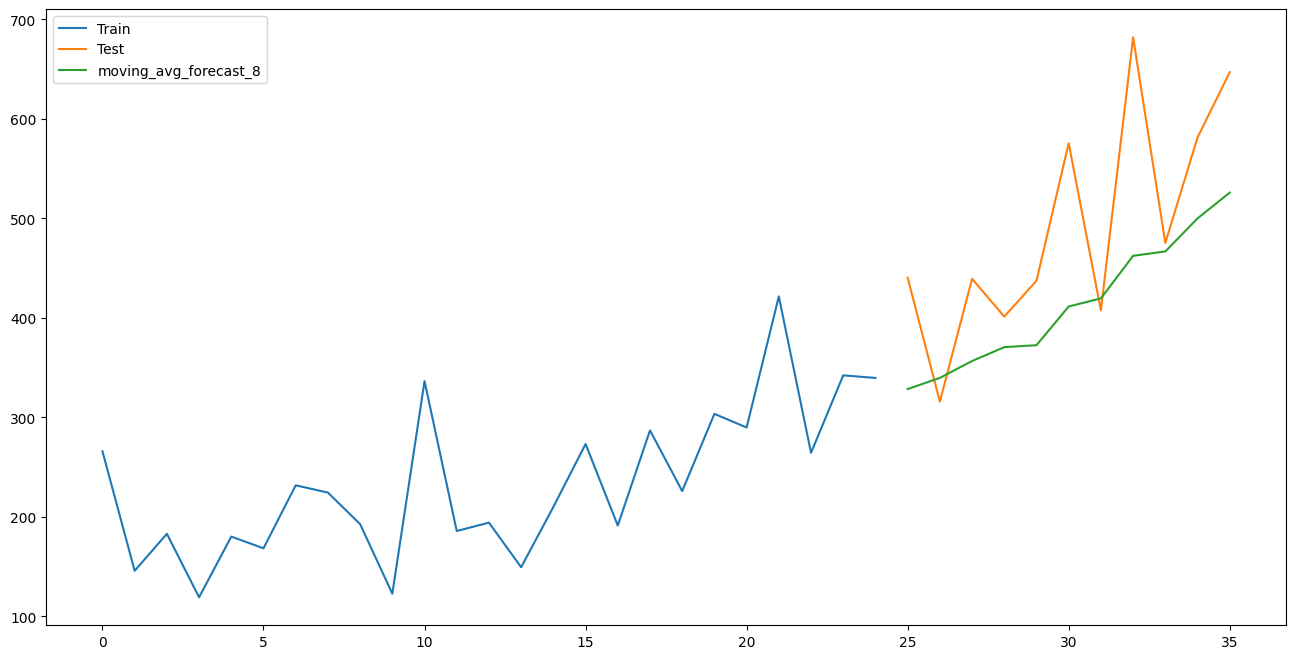

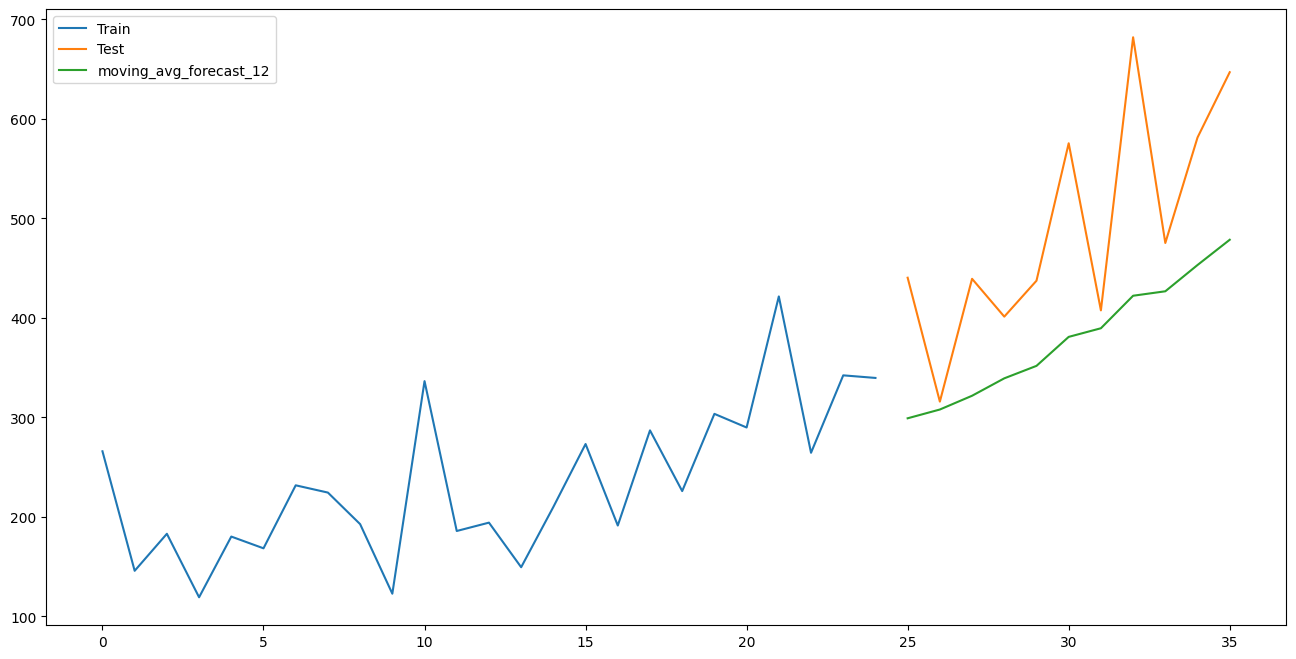

In [120]:
shampoo_df_1 = shampoo_df.copy()

shampoo_df_1['moving_avg_forecast_4'] = shampoo_df['Sales'].rolling(4).mean()
shampoo_df_1['moving_avg_forecast_6'] = shampoo_df['Sales'].rolling(6).mean()
shampoo_df_1['moving_avg_forecast_8'] = shampoo_df['Sales'].rolling(8).mean()
shampoo_df_1['moving_avg_forecast_12'] = shampoo_df['Sales'].rolling(12).mean()

cols = ['moving_avg_forecast_4', 'moving_avg_forecast_6' , 'moving_avg_forecast_8', 'moving_avg_forecast_12']

# Creating train and test set
train = shampoo_df_1[0:int(len(shampoo_df_1)*0.7)]
test = shampoo_df_1[int(len(shampoo_df_1)*0.7):]

y_hat_avg = test.copy()

for col_name in cols:
    plt.figure(figsize=(16, 8))
    plt.plot(train['Sales'], label = 'Train')
    plt.plot(test['Sales'], label = 'Test')
    plt.plot(y_hat_avg[col_name], label = col_name)
    plt.legend(loc = 'best')
    
    rmse = sqrt(mean_squared_error(test.Sales, y_hat_avg[col_name]))
    rmse = round(rmse, 3)
    mape = MAPE(test.Sales, y_hat_avg[col_name])
    print("For Simple Average model, %s RMSE is %3.3f MAPE is %3.2f" %(col_name, rmse, mape))
    
    tempResults_df = pd.DataFrame({'Method': [col_name], 'rmse': [rmse], 'mape': [mape]})
    results_df = pd.concat([results_df, tempResults_df])

In [121]:
results_df

Method     rmse   mape
0          RegressionOnTime  164.563  27.94
0  RegressionOnTimeSeasonal  185.864  32.59
0              Naive Method  186.469  31.72
0            Simple Average  279.196  52.35
0     moving_avg_forecast_4   75.514  13.05
0     moving_avg_forecast_6   88.576  14.62
0     moving_avg_forecast_8  105.158  17.03
0    moving_avg_forecast_12  134.071  22.79

#### Simple  Exponential smoothing

In [122]:
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized = True)
print("\n Simple Exponential Smoothing \n")
print("Smoothing Level : ", np.round(model_fit.params['smoothing_level'], 4))
print('Initial Level : ', np.round(model_fit.params['initial_level']))



 Simple Exponential Smoothing 

Smoothing Level :  0.3581
Initial Level :  266.0


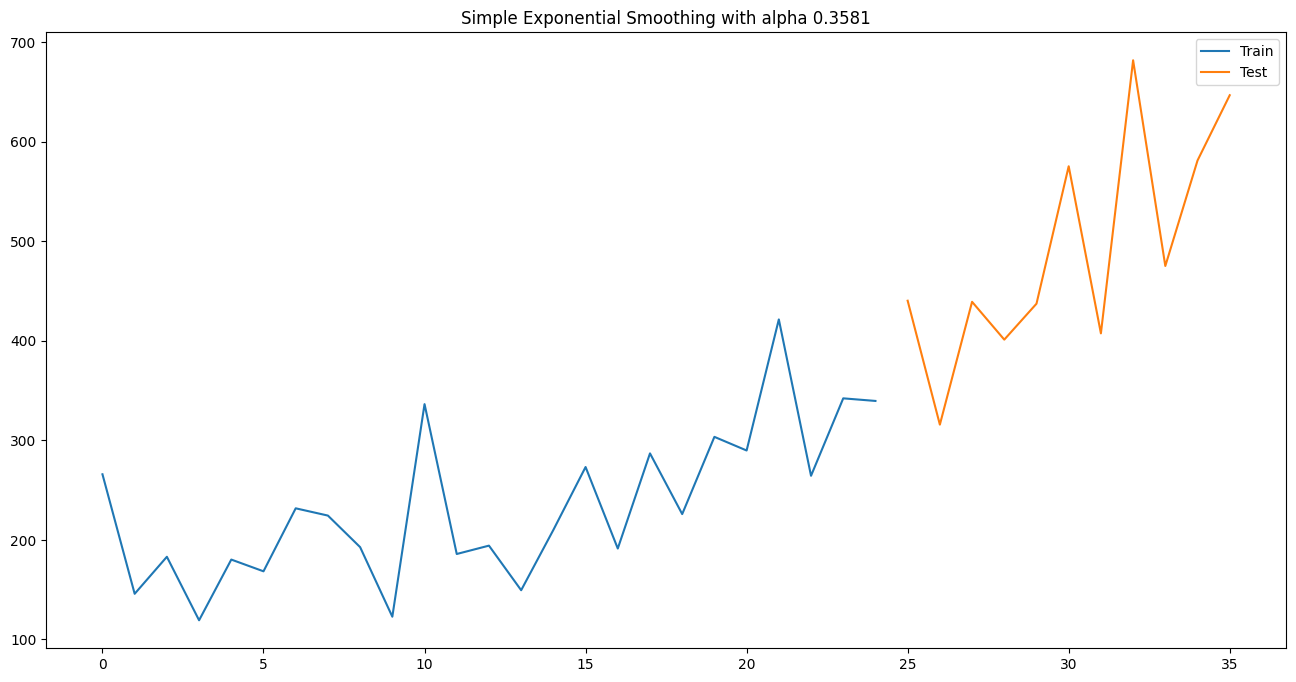

In [123]:
y_hat_avg['SES'] = model_fit.forecast(len(test['Sales']))
alpha_value = np.round(model_fit.params['smoothing_level'], 4)

plt.figure(figsize=(16, 8))
plt.plot(train.index, train['Sales'], label = 'Train')
plt.plot(test.index, test['Sales'], label = 'Test')
plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
plt.legend(loc = 'best')
plt.show()

In [124]:
rmse_opt = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg.SES))
mape_opt = MAPE(test['Sales'], y_hat_avg.SES)

print("For alpha = %1.2f, RMSE is %3.4f MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))


For alpha = 0.36, RMSE is 198.4790 MAPE is 34.15


In [125]:
tempResults_df = pd.DataFrame({'Method' : 'SES', 'rmse': [rmse_opt], 'mape' : [mape_opt]}
                             )
results_df = pd.concat([results_df, tempResults_df])
results_df

Method        rmse   mape
0          RegressionOnTime  164.563000  27.94
0  RegressionOnTimeSeasonal  185.864000  32.59
0              Naive Method  186.469000  31.72
0            Simple Average  279.196000  52.35
0     moving_avg_forecast_4   75.514000  13.05
0     moving_avg_forecast_6   88.576000  14.62
0     moving_avg_forecast_8  105.158000  17.03
0    moving_avg_forecast_12  134.071000  22.79
0                       SES  198.478952  34.15

#### Holt's Linear Trend Method ( Double Exponential Smoothing )

In [126]:
y_hat_avg = test.copy()
model_fit = Holt(np.asarray(train['Sales'])).fit()
y_hat_avg['Holt_linear'] = model_fit.forecast(len(test))

print('\n Holt model Exponential Smoothing Parameters \n')
alpha_value = np.round(model_fit.params['smoothing_level'], 4)
beta_value = np.round(model_fit.params['smoothing_trend'], 4)

print('Smoothing Level : ', alpha_value)
print('Smoothing Slope : ', beta_value)
print('Initial level : ', np.round(model_fit.params['initial_level'], 4))



 Holt model Exponential Smoothing Parameters 

Smoothing Level :  0.5305
Smoothing Slope :  0.5305
Initial level :  266.0


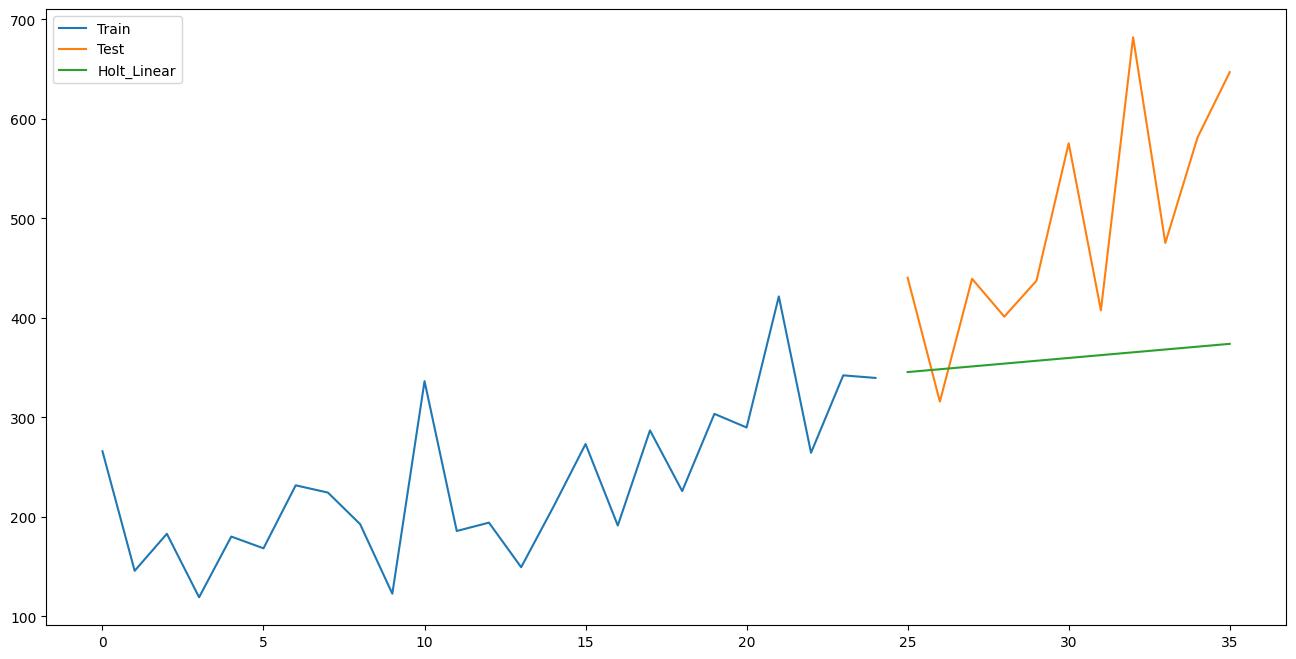

In [127]:
plt.figure(figsize=(16, 8))
plt.plot(train['Sales'], label = 'Train')
plt.plot(test['Sales'], label = 'Test')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_Linear')
plt.legend(loc = 'best')
plt.show()

In [128]:
rmse_opt = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['Holt_linear']))
mape_opt = MAPE(test['Sales'], y_hat_avg['Holt_linear'])

print("For Alpha = %1.2f RMSE is %3.4f, and MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))

For Alpha = 0.53 RMSE is 166.6218, and MAPE is 27.96


In [129]:
temResults_df = pd.DataFrame({'Method' : 'Holt_linear', 'rmse' : [rmse], 'mape': [mape]})
results_df = pd.concat([results_df, tempResults_df])
results_df

Method        rmse   mape
0          RegressionOnTime  164.563000  27.94
0  RegressionOnTimeSeasonal  185.864000  32.59
0              Naive Method  186.469000  31.72
0            Simple Average  279.196000  52.35
0     moving_avg_forecast_4   75.514000  13.05
0     moving_avg_forecast_6   88.576000  14.62
0     moving_avg_forecast_8  105.158000  17.03
0    moving_avg_forecast_12  134.071000  22.79
0                       SES  198.478952  34.15
0                       SES  198.478952  34.15

Holt-Winters Method - Additive Seasonality

In [130]:
y_hat_avg = test.copy()
model_fit = ExponentialSmoothing(np.asarray(train['Sales']), seasonal_periods = 12, trend = 'add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = model_fit.forecast(len(test))

print('\n Holt-Winters Additive ETS( A, A, A) Parameters \n')
alpha_value = np.round(pred.params['smoothing_level'], 4)
beta_value = np.round(model_fit.params['smoothing_trend'], 4)
gamma_value = np.round(model_fit.params['smoothing_seasonal'], 4)

print('Smoothing level    : ', alpha_value)
print('Smoothing Slope    : ', beta_value)
print('Smoothing Seasonal : ', gamma_value)
print('Initial Level      : ', np.round(model_fit.params['initial_level'], 4))
print('Initial Slope      : ', np.round(model_fit.params['initial_trend'], 4))
print('Initial Seasons    : ', np.round(model_fit.params['initial_seasons'], 4))


 Holt-Winters Additive ETS( A, A, A) Parameters 

Smoothing level    :  0.8807
Smoothing Slope    :  0.0
Smoothing Seasonal :  0.0263
Initial Level      :  160.1167
Initial Slope      :  5.6946
Initial Seasons    :  [ 32.6233 -59.155  -15.6309 -20.8912 -37.7435  -0.7398  -4.9117  24.2654
  -4.0602  19.8382  44.9393   1.5068]


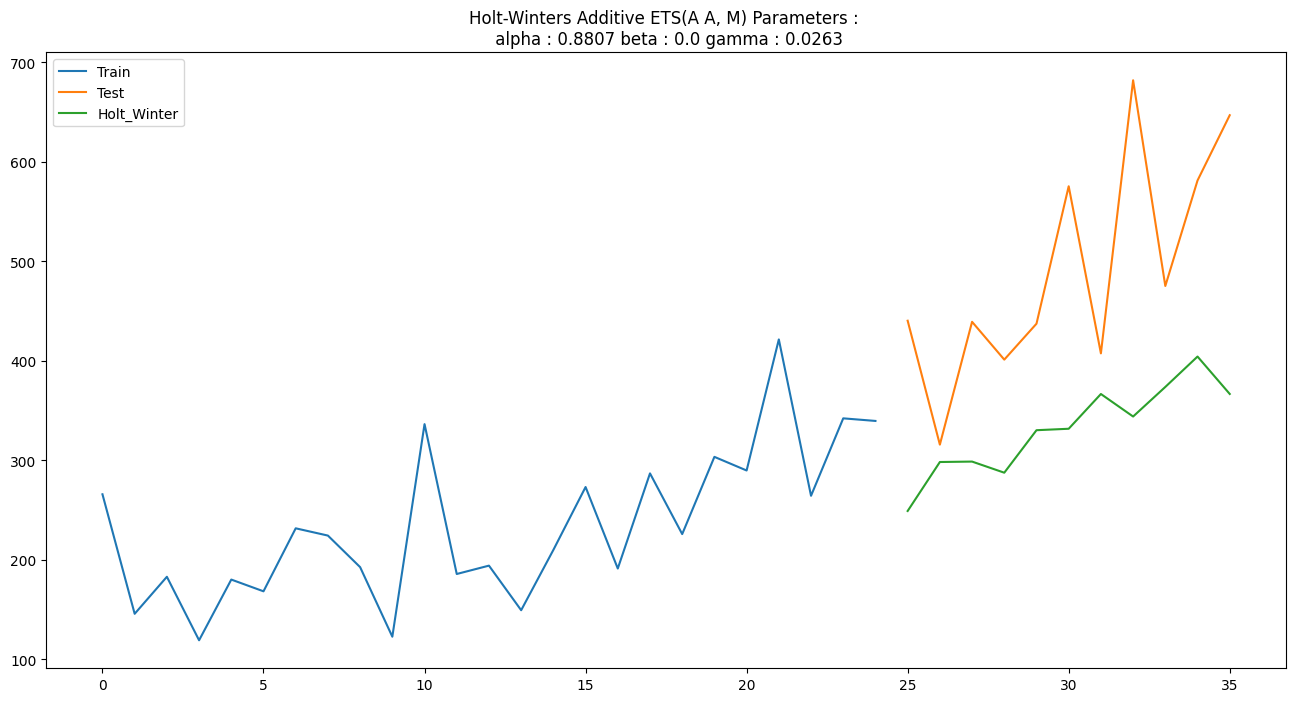

In [131]:
plt.figure(figsize=(16, 8))
plt.plot(train['Sales'], label = 'Train')
plt.plot( test['Sales'], label = 'Test')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
plt.title('Holt-Winters Additive ETS(A A, M) Parameters : \n'
         + ' alpha : ' + str(alpha_value) + ' beta : ' + str(beta_value) +
         ' gamma : ' + str(gamma_value)
         )
plt.legend(loc='best')
plt.show()


In [132]:
rmse_opt = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['Holt_Winter']))
mape_opt = MAPE(test['Sales'] , y_hat_avg['Holt_Winter'])

print('For Alpha : %1.2f beta : %1.2f, gamma : %1.2f, RMSE : %3.4f and MAPE is %3.2f' 
      %(alpha_value, beta_value, gamma_value, rmse_opt, mape_opt))

For Alpha : 0.88 beta : 0.00, gamma : 0.03, RMSE : 184.9251 and MAPE is 32.40


In [133]:
tempResults_df = pd.DataFrame({'Method' : 'Holt_Winter' , 'rmse': [rmse_opt] , 'mape': [mape_opt]})
results_df = pd.concat([results_df, tempResults_df])
results_df

Method        rmse   mape
0          RegressionOnTime  164.563000  27.94
0  RegressionOnTimeSeasonal  185.864000  32.59
0              Naive Method  186.469000  31.72
0            Simple Average  279.196000  52.35
0     moving_avg_forecast_4   75.514000  13.05
0     moving_avg_forecast_6   88.576000  14.62
0     moving_avg_forecast_8  105.158000  17.03
0    moving_avg_forecast_12  134.071000  22.79
0                       SES  198.478952  34.15
0                       SES  198.478952  34.15
0               Holt_Winter  184.925089  32.40

Holt-Winters Method - Multiplicative Model

In [134]:
y_hat_avg = test.copy()
model_fit = ExponentialSmoothing(np.asarray(train['Sales']), seasonal_periods = 12, trend = 'add', seasonal ='Multiplicative').fit()
y_hat_avg['Holt_Winter_M'] = model_fit.forecast(len(test))

print('\n Holt Winters Multiplicative ETS(A, A , M) Parameters\n')
alpha_value = np.round(pred.params['smoothing_level'], 4)
beta_value = np.round(model_fit.params['smoothing_trend'], 4)
gamma_value = np.round(model_fit.params['smoothing_seasonal'], 4)

print('Smoothing level       : ', alpha_value)
print('Smoothing Slope/Trend : ', beta_value)
print('Smoothing Seasonal    : ', gamma_value)
print('Initial level         : ', np.round(model_fit.params['initial_level'],4))
print('Initial Slope/Trend   : ', np.round(model_fit.params['initial_trend'],4))
print('Initial Seasons       : ', np.round(model_fit.params['initial_seasons'], 4))



 Holt Winters Multiplicative ETS(A, A , M) Parameters

Smoothing level       :  0.8807
Smoothing Slope/Trend :  0.0
Smoothing Seasonal    :  0.0
Initial level         :  112.684
Initial Slope/Trend   :  3.9155
Initial Seasons       :  [1.5859 1.001  1.3105 1.3396 1.1719 1.4497 1.3686 1.5784 1.42   1.6375
 1.6222 1.4724]


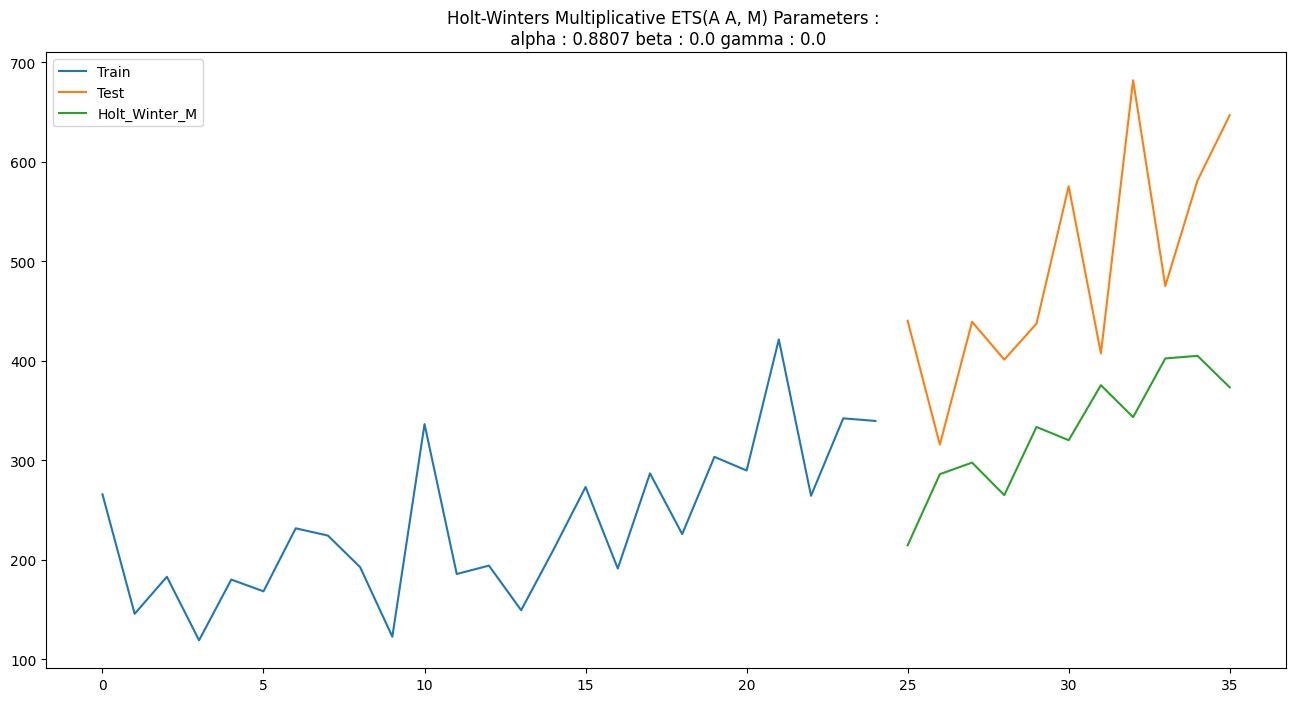

In [135]:
plt.figure(figsize=(16, 8))
plt.plot(train['Sales'], label = 'Train')
plt.plot( test['Sales'], label = 'Test')
plt.plot(y_hat_avg['Holt_Winter_M'], label = 'Holt_Winter_M')
plt.title('Holt-Winters Multiplicative ETS(A A, M) Parameters : \n'
         + ' alpha : ' + str(alpha_value) + ' beta : ' + str(beta_value) +
         ' gamma : ' + str(gamma_value)
         )
plt.legend(loc='best')
plt.show()


In [136]:
rmse_opt = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['Holt_Winter_M']))
mape_opt = MAPE(test['Sales'] , y_hat_avg['Holt_Winter_M'])

print('For Alpha : %1.2f beta : %1.2f, gamma : %1.2f, RMSE : %3.4f and MAPE is %3.2f' 
      %(alpha_value, beta_value, gamma_value, rmse_opt, mape_opt))

For Alpha : 0.88 beta : 0.00, gamma : 0.00, RMSE : 189.0133 and MAPE is 33.04


In [137]:
tempResults_df = pd.DataFrame({'Method' : 'Holt_Winter_M' , 'rmse': [rmse_opt] , 'mape': [mape_opt]})
results_df = pd.concat([results_df, tempResults_df])
results_df

Method        rmse   mape
0          RegressionOnTime  164.563000  27.94
0  RegressionOnTimeSeasonal  185.864000  32.59
0              Naive Method  186.469000  31.72
0            Simple Average  279.196000  52.35
0     moving_avg_forecast_4   75.514000  13.05
0     moving_avg_forecast_6   88.576000  14.62
0     moving_avg_forecast_8  105.158000  17.03
0    moving_avg_forecast_12  134.071000  22.79
0                       SES  198.478952  34.15
0                       SES  198.478952  34.15
0               Holt_Winter  184.925089  32.40
0             Holt_Winter_M  189.013327  33.04

# Auto Regressive Models

In [138]:
data = pd.read_csv('/kaggle/input/time-series-data/TractorSales.csv', header=0, parse_dates=[0]).squeeze()
dates = pd.date_range(start = '2003-01-01', freq = 'MS', periods = len(data))

data['Month'] = dates.month
data['Month'] = data['Month'].apply(lambda x : calendar.month_abbr[x])
data['Year'] = dates.year

data.drop(['Month-Year'], axis=1, inplace = True)
data.rename(columns = {'Number of Tractor Sold' : 'Tractor-Sales'}, inplace = True)

data = data[['Month', 'Year', 'Tractor-Sales']]
data.set_index(dates, inplace = True)

sales_ts = data['Tractor-Sales']

result = adfuller(sales_ts)

print('ADF Statistic : %f' %result[0])
print('p-value  : %f' %result[1])


ADF Statistic : 1.108825
p-value  : 0.995291


In [139]:
sales_ts_diff = sales_ts  - sales_ts.shift(periods=1)
sales_ts_diff.dropna(inplace=True)

result = adfuller(sales_ts_diff)
pval = result[1]
print('Statistics : %f' %result[0])
print('p-value : %f' %result[1])

if pval < 0.05:
    print('Data is stationary')
else:
    print('Data after differencing is not stationary')
    
    sales_ts_log = np.log10(sales_ts)
    sales_ts_log.dropna(inplace = True)
    sales_ts_log_diff = sales_ts_log.diff(periods=1)
    sales_ts_log_diff.dropna(inplace = True)
    result = adfuller(sales_ts_log_diff)
    pval = result[1]
    
    if pval < 0.05:
        print('Data after log differencing is stationary')
    else:
        print('Data after log differencing is not stationary, try second order differencing')
        
        sales_ts_log_diff_2 = sales_ts_log.diff(periods=2)
        sales_ts_log_diff_2.dropna(inplace = True)
        result = adfuller(sales_ts_log_diff_2)
        pval = result[1]
        print('ADF Statistic : %f' %result[0])
        print('pval : %f' %result[1])
        
        if pval < 0.05:
            print('Data after log differencing 2nd order is stationary')
        else:
            print('Data after log differencing 2nd order is not stationary')

Statistics : -2.543481
p-value : 0.105250
Data after differencing is not stationary
Data after log differencing is not stationary, try second order differencing
ADF Statistic : -3.200722
pval : 0.019943
Data after log differencing 2nd order is stationary


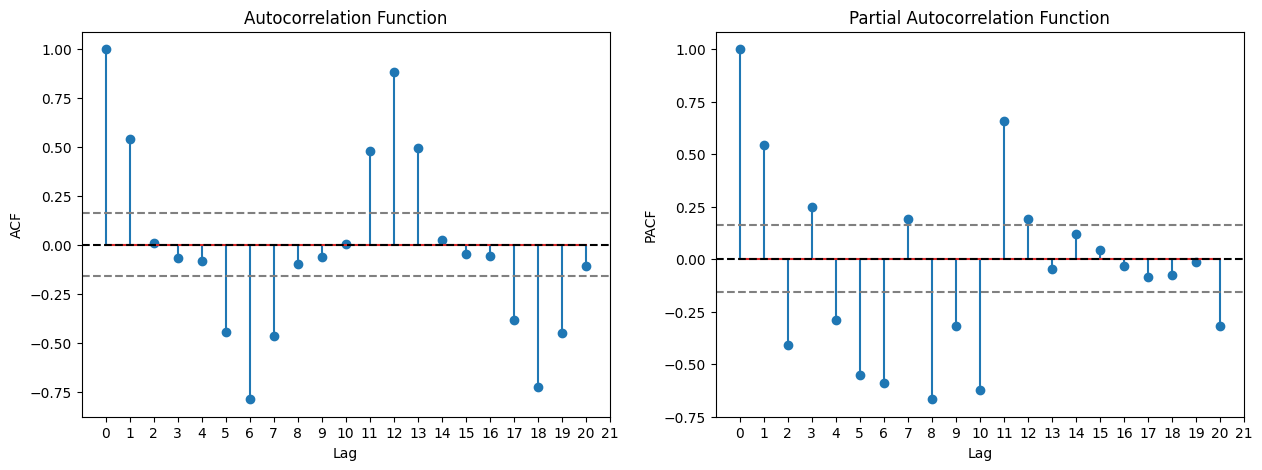

In [140]:
# ACF ( Autocorrelation Function ) 
# and PACF (Partil AutoCorrelation Function ) plots

lag_acf = acf(sales_ts_log_diff_2, nlags = 20)
lag_pacf = pacf(sales_ts_log_diff_2, nlags = 20, method = 'ols')

#Plot ACF

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = -1.86 / np.sqrt(len(sales_ts_log_diff_2)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(sales_ts_log_diff_2)), linestyle='--', color='gray')
plt.xticks(range(0, 22, 1))
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')

#Plot PACF

plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = -1.86 / np.sqrt(len(sales_ts_log_diff_2)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(sales_ts_log_diff_2)), linestyle='--', color='gray')
plt.xticks(range(0, 22, 1))
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')

plt.show()

## Random Walk

A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. 

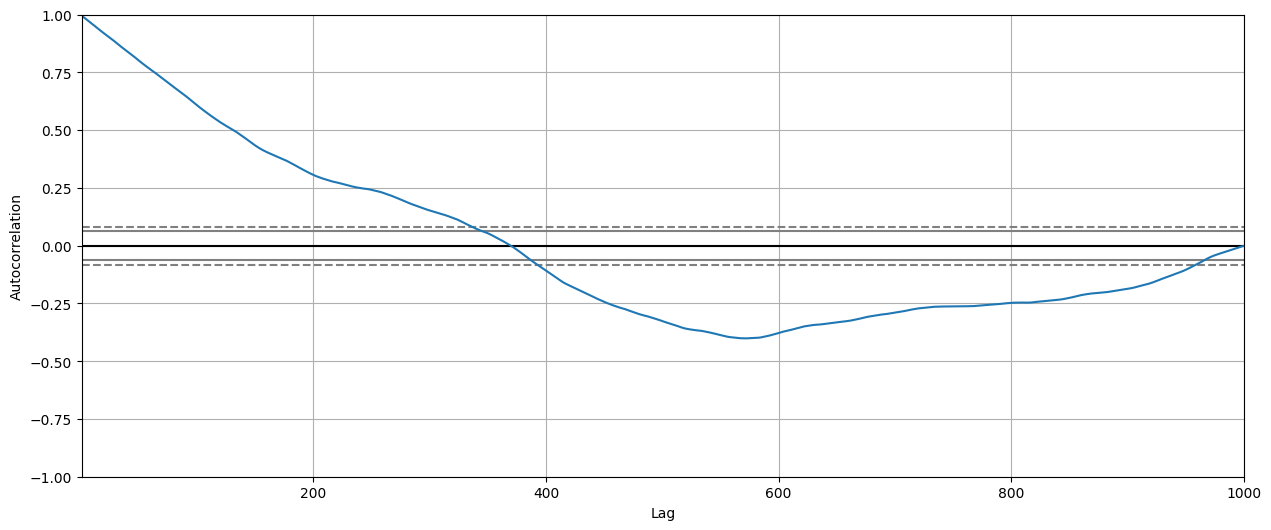

In [141]:
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
pd.plotting.autocorrelation_plot(random_walk)
plt.show()

In [142]:
# Check stationary property
result = adfuller(random_walk)
print('ADF Stats : %f' %result[0])
print('p value : %f' %result[1])
print('Critical Values : ')
for key, value in result[4].items():
    print('\t%s : %.3f' % (key, value))
    

ADF Stats : 0.341605
p value : 0.979175
Critical Values : 
	1% : -3.437
	5% : -2.864
	10% : -2.568


In [143]:
# prepare dataset for predicting a random walk

training_size = int(len(random_walk)*0.7)
training, test = random_walk[0 : training_size], random_walk[training_size: ]

predictions = list()
hist = training[-1]

for i in range(len(test)):
    yhat = hist
    predictions.append(yhat)
    hist = test[i]
    
rmse = np.sqrt(mean_squared_error(test, predictions))
print('\n\n Predictiing a random walk \n RMSE : %.3f' %rmse)



 Predictiing a random walk 
 RMSE : 1.000


## Random walk with drift

stimulate stock returns using a random walk with drift

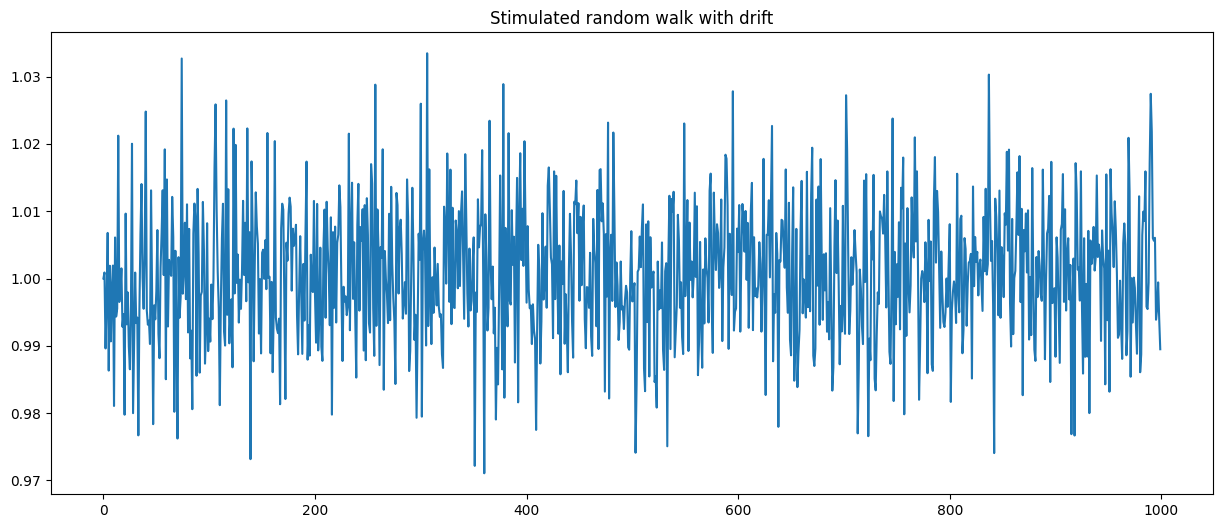

In [144]:
# generate
seed(1234)
rw_steps = np.random.normal(loc = 0.001, scale = 0.01, size = 1000) + 1

# Initialize first element to 1
rw_steps[0] = 1

# stimulate the stock price

Price = rw_steps * np.cumprod(rw_steps)
Price = Price * 100

# plot
plt.plot(rw_steps)
plt.title('Stimulated random walk with drift')
plt.show()

In [145]:
# Stationary property check
result = adfuller(Price)
print('ADF Stats : %f' %result[0])
print('p value : %f' %result[1])
print('Critica Values : ')

for key, value in result[4].items():
    print('\t %s : %.3f' %(key, value))

ADF Stats : 0.795470
p value : 0.991563
Critica Values : 
	 1% : -3.437
	 5% : -2.864
	 10% : -2.568


In [146]:
# Prediction

training_size = int(len(Price) * 0.7)

training, test = Price[0:training_size], Price[training_size:]

predictions = list()
hist = training[-1]

for i in range(len(test)):
    yhat = hist
    predictions.append(yhat)
    hist = test[i]
    
rmse = np.sqrt(mean_squared_error(test, predictions))
print('\n\n Predicting a Random Walk with drift \n RMSE  : %.3f' %rmse)



 Predicting a Random Walk with drift 
 RMSE  : 3.497


#### ARIMA Model

Auto Regressive Integrated Moving Average

In [147]:
bank_df = pd.read_csv('/kaggle/input/time-series-data/BOE-XUDLERD.csv')
bank_df.head()

Date   Value
0  2017-11-09  0.8603
1  2017-11-08  0.8631
2  2017-11-07  0.8639
3  2017-11-06  0.8631
4  2017-11-03  0.8608

In [148]:
# converting to time series data
bank_df['Date'] = pd.to_datetime(bank_df['Date'])
indexed_df = bank_df.set_index('Date')
ts = indexed_df['Value']
ts.head()

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

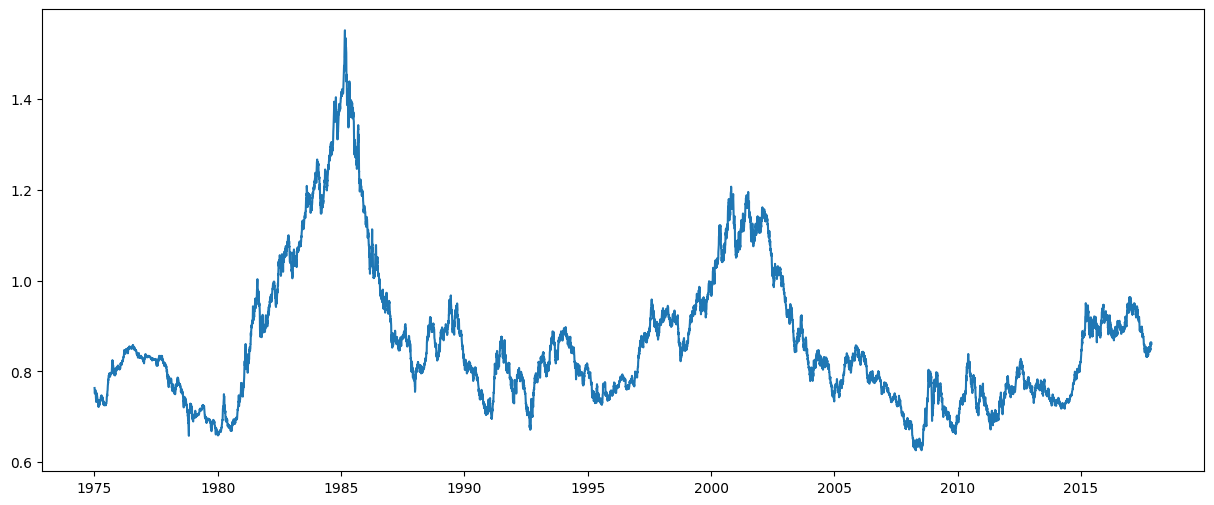

In [149]:
# visualize raw data
plt.plot(ts)

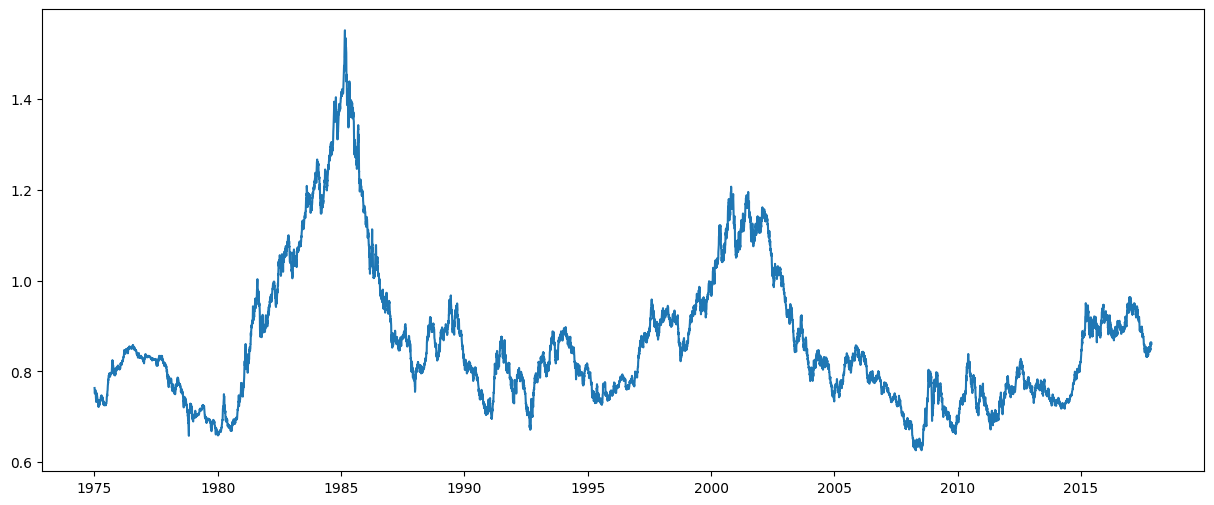

In [150]:
# resample the data as it cotains too much variations

ts_week = ts.resample('W').mean()
plt.plot(ts)

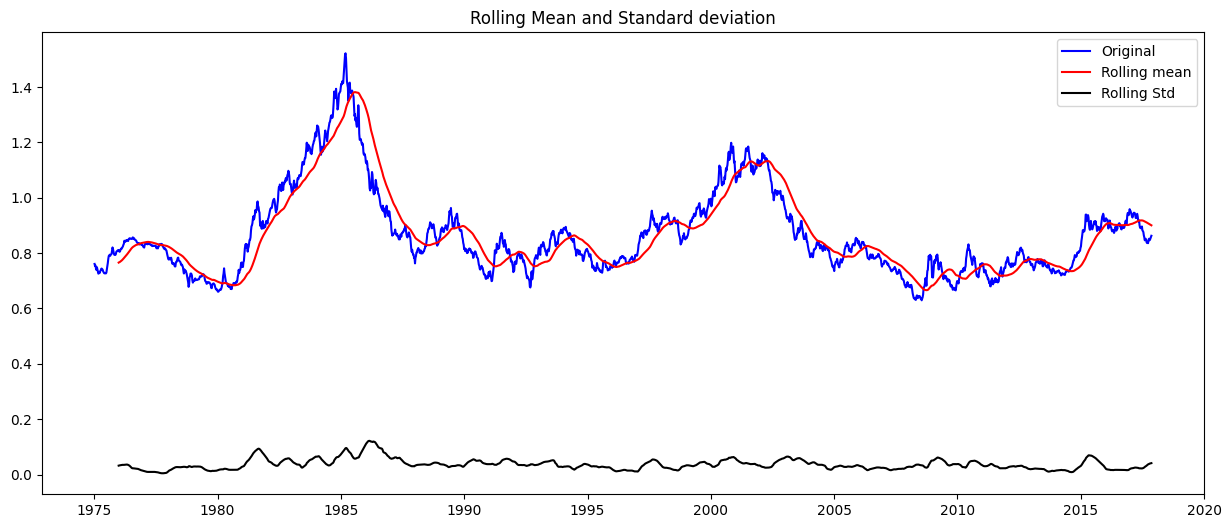

Results of Dickey-Fuller Test : 
Test Stats                  -2.076341
pvalue                       0.254134
No of lags used              2.000000
No of Observation Used    2234.000000
Critical Values (1%)        -3.433281
Critical Values (5%)        -2.862835
Critical Values (10%)       -2.567459
dtype: float64


In [151]:
def test_stationarity(timeseries):
    # determine rolling stats
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center = False).std()
    
    # Plot rolling stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling mean')
    std = plt.plot(rolstd, color  ='black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard deviation')
    plt.show(block = False)
    
    #Perform Dickey-Fuller test
    
    print('Results of Dickey-Fuller Test : ')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stats', 'pvalue', 'No of lags used', 'No of Observation Used'])
    for key , value in dftest[4].items():
        dfoutput['Critical Values (%s)' %key] = value
    print(dfoutput)
    
test_stationarity(ts_week)
    

#### Differencing


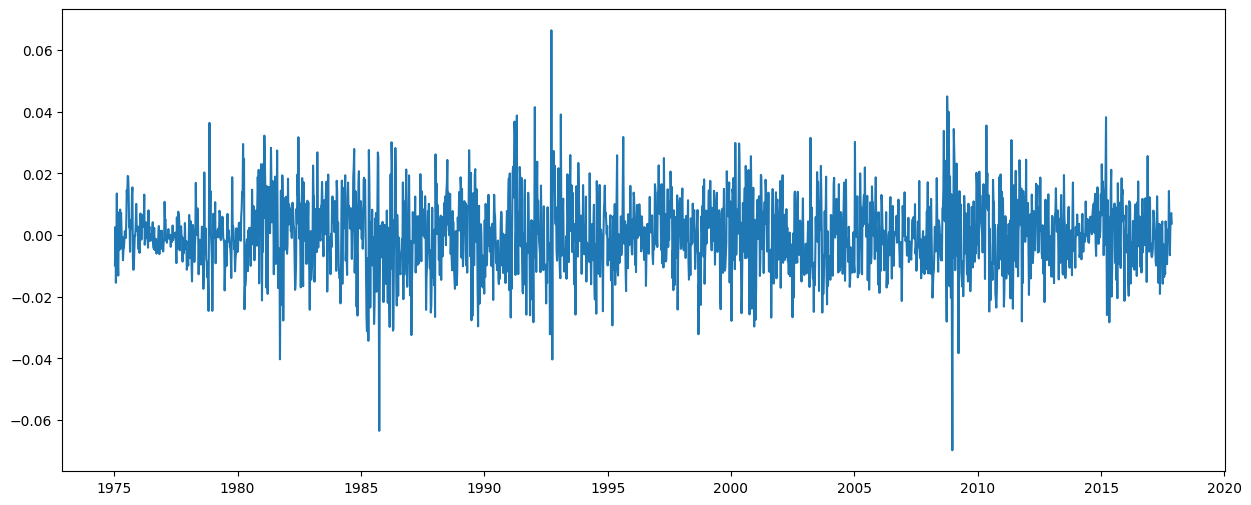

In [152]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

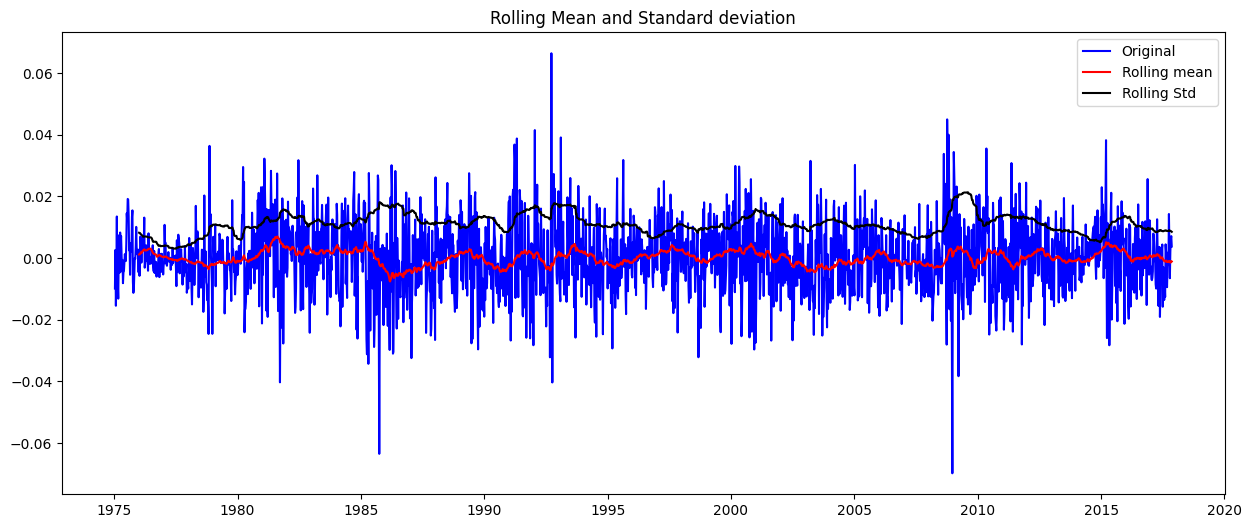

Results of Dickey-Fuller Test : 
Test Stats                 -36.590004
pvalue                       0.000000
No of lags used              0.000000
No of Observation Used    2235.000000
Critical Values (1%)        -3.433279
Critical Values (5%)        -2.862834
Critical Values (10%)       -2.567459
dtype: float64


In [153]:
# Again confirming with the dickey-fuller test
ts_week_log_diff.dropna(inplace = True)
test_stationarity(ts_week_log_diff)

The test statistic is less than 1% of the critical value, shows that the time series is stationary with 99% confidence. 
Now we can apply the statistical models like ARIMA to forecast the future values

In [154]:
# ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags = 10)
lag_pacf = pacf(ts_week_log_diff, nlags = 10, method = 'ols')

Text(0.5, 1.0, 'Autocorrelation Function')

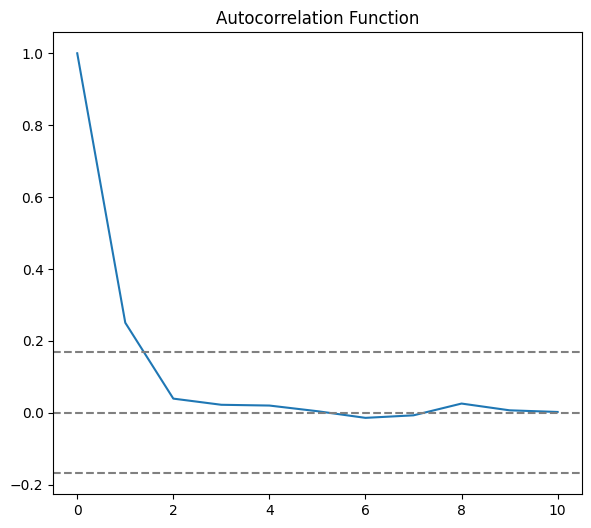

In [155]:
# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-7.96 / np.sqrt(len(ts_week_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y=7.96 / np.sqrt(len(ts_week_log_diff)), linestyle='--', color = 'gray')
plt.title('Autocorrelation Function')

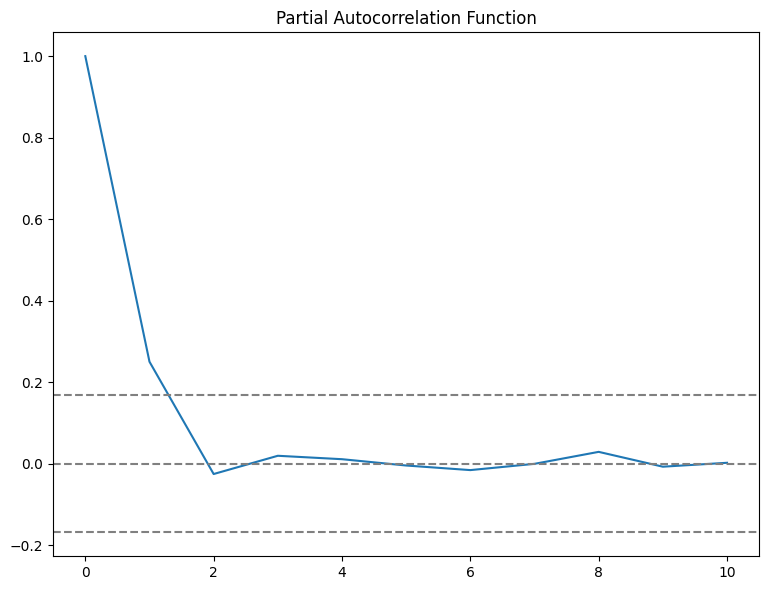

In [156]:
# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle='--', color='gray')
plt.axhline(y=-7.96 / np.sqrt(len(ts_week_log_diff)), linestyle='--', color ='gray')
plt.axhline(y=7.96 / np.sqrt(len(ts_week_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

looking at the plot we can see the lag where it drops to 0 is 2 , so p = 2 and point where lag crosses upper confidence is 1 so q = 1

Text(0.5, 1.0, 'RSS : nan')

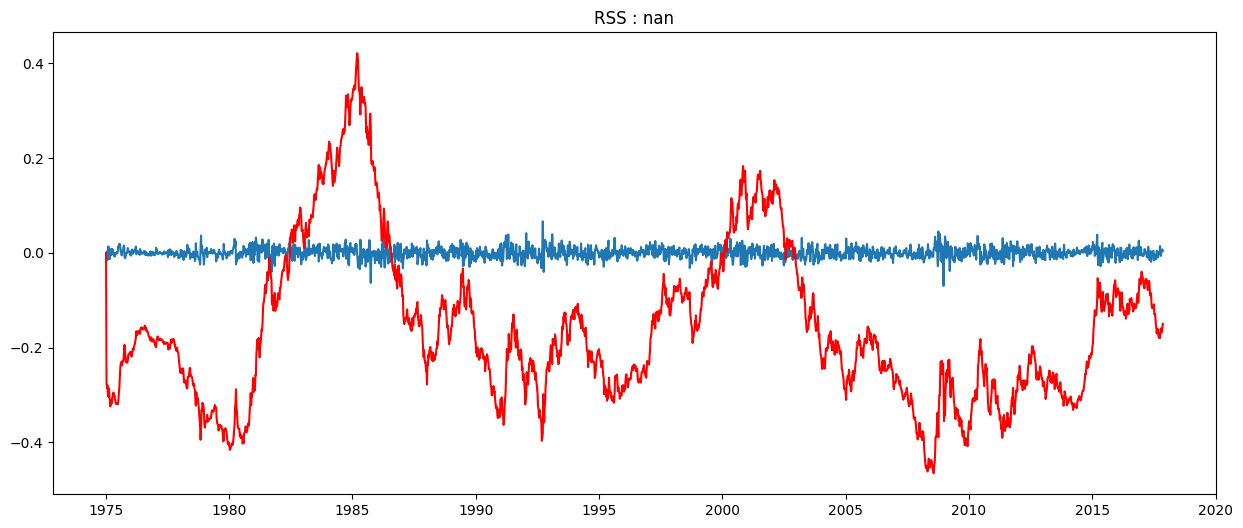

In [157]:
# Optimal vaules for ARIMa(p, d, q) are (2, 1, 1)
# Hence plot the ARIMA model w=using th value (2, 1, 1)

model = ARIMA(ts_week_log, order = (2, 1, 1))
results_ARIMA = model.fit()
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS : %.4f' %sum((results_ARIMA.fittedvalues - ts_week_log_diff)**2))


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 2237
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6869.699
Date:                Thu, 15 Aug 2024   AIC                         -13731.397
Time:                        07:12:02   BIC                         -13708.547
Sample:                    01-05-1975   HQIC                        -13723.055
                         - 11-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5344      0.164     -3.257      0.001      -0.856      -0.213
ar.L2          0.1729      0.053      3.258      0.001       0.069       0.277
ma.L1          0.7921      0.163      4.874      0.0

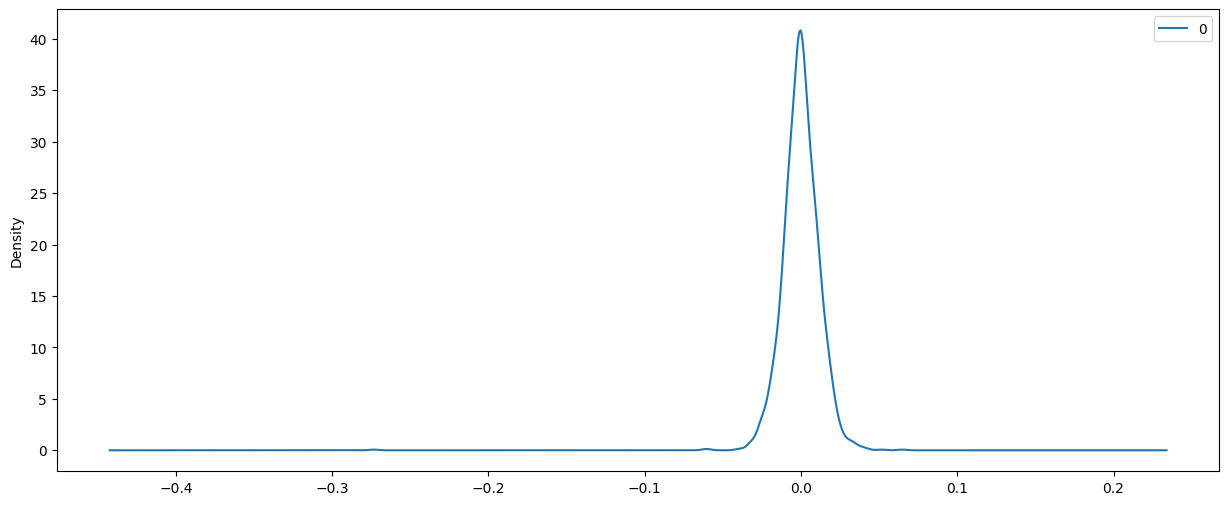

In [158]:
# print the results of the ARIMA model and plot  the residuals

print(results_ARIMA.summary())

#plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind = 'kde')
print(residuals.describe())

In [159]:
# predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
print(predictions_ARIMA_diff.head())

Date
1975-01-05    0.000000
1975-01-12   -0.273253
1975-01-19   -0.285537
1975-01-26   -0.279503
1975-02-02   -0.300117
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE : 0.8776')

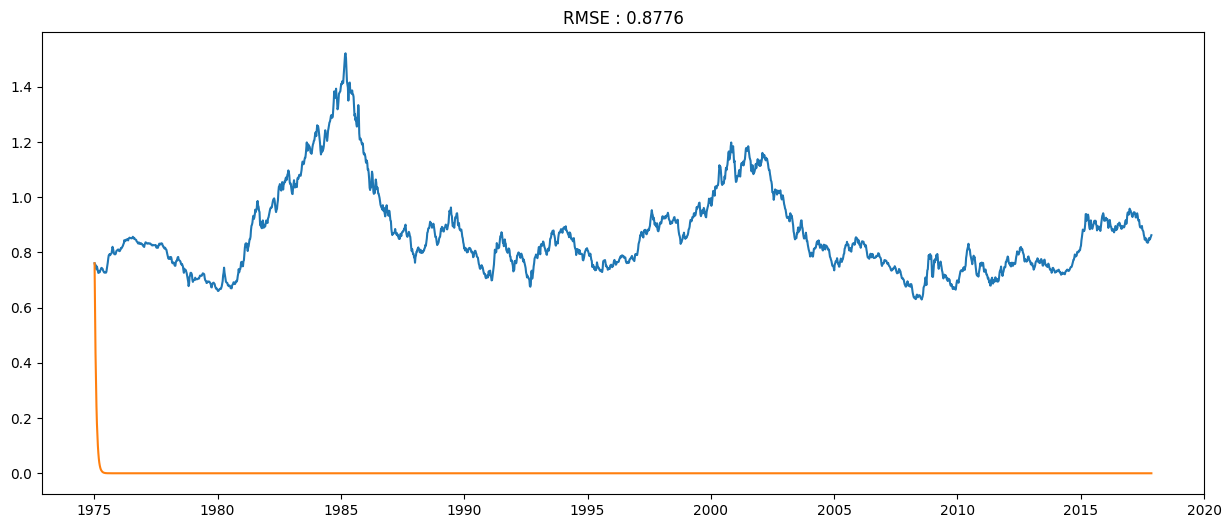

In [160]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index = ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE : %.4f' %np.sqrt(sum((predictions_ARIMA - ts_week)**2)/ len(ts_week)))

In [161]:
# training and test datasets
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

# training the model and forecasting
print('Printing Predicted vs Expected Values ...\n')
for t in range(len(test)):
    model = ARIMA(history, order = (2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)

print('predicted = %f , expected = %f' %(np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values ...

predicted = 0.860825 , expected = 0.862600


In [162]:
# Validating the model
error = mean_squared_error(test, predictions)
print('Printing mean squared Error of predictions \n')
print('Test MSE  %.6f' %error)
predictions_series = pd.Series(predictions, index = test.index)


Printing mean squared Error of predictions 

Test MSE  0.000042


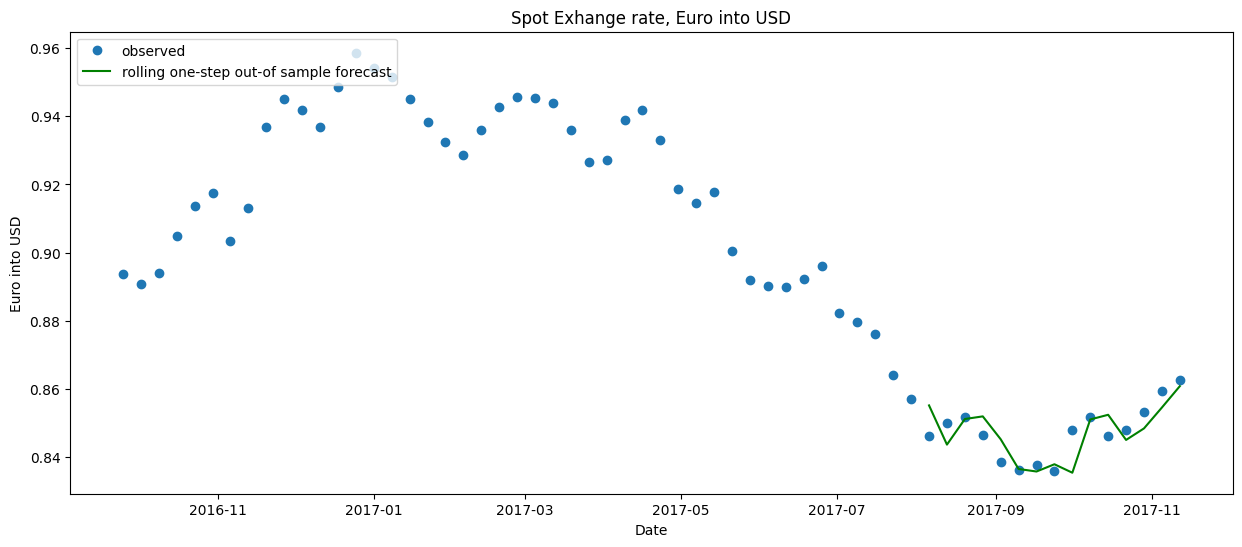

In [163]:
# Plotting the forecasted vs Observed values

fig, ax = plt.subplots()
ax.set(title = 'Spot Exhange rate, Euro into USD', xlabel = 'Date', ylabel= 'Euro into USD')
ax.plot(ts_week[-60:], 'o', label = 'observed')
ax.plot(np.exp(predictions_series), 'g', label = 'rolling one-step out-of sample forecast')
legend = ax.legend(loc = 'upper left')
legend.get_frame().set_facecolor('w')


## Auto ARIMA


In [164]:
tractor_sales_df = pd.read_csv('/kaggle/input/time-series-data/TractorSales.csv')
tractor_sales_df.head()

Month-Year  Number of Tractor Sold
0      3-Jan                     141
1      3-Feb                     157
2      3-Mar                     185
3      3-Apr                     199
4      3-May                     203

In [165]:
dates = pd.date_range(start ='2003-01-01', freq = 'MS' , periods= len(tractor_sales_df))

tractor_sales_df['Month'] = dates.month
tractor_sales_df['Month'] = tractor_sales_df['Month'].apply(lambda x: calendar.month_abbr[x])
tractor_sales_df['Year'] = dates.year

tractor_sales_df.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace = True)
tractor_sales_df = tractor_sales_df[['Month', 'Year', 'Tractor-Sales']]

tractor_sales_df.set_index(dates, inplace = True)
tractor_sales_df.head()

Month  Year  Tractor-Sales
2003-01-01   Jan  2003            141
2003-02-01   Feb  2003            157
2003-03-01   Mar  2003            185
2003-04-01   Apr  2003            199
2003-05-01   May  2003            203

Text(0, 0.5, 'Tractor Sales')

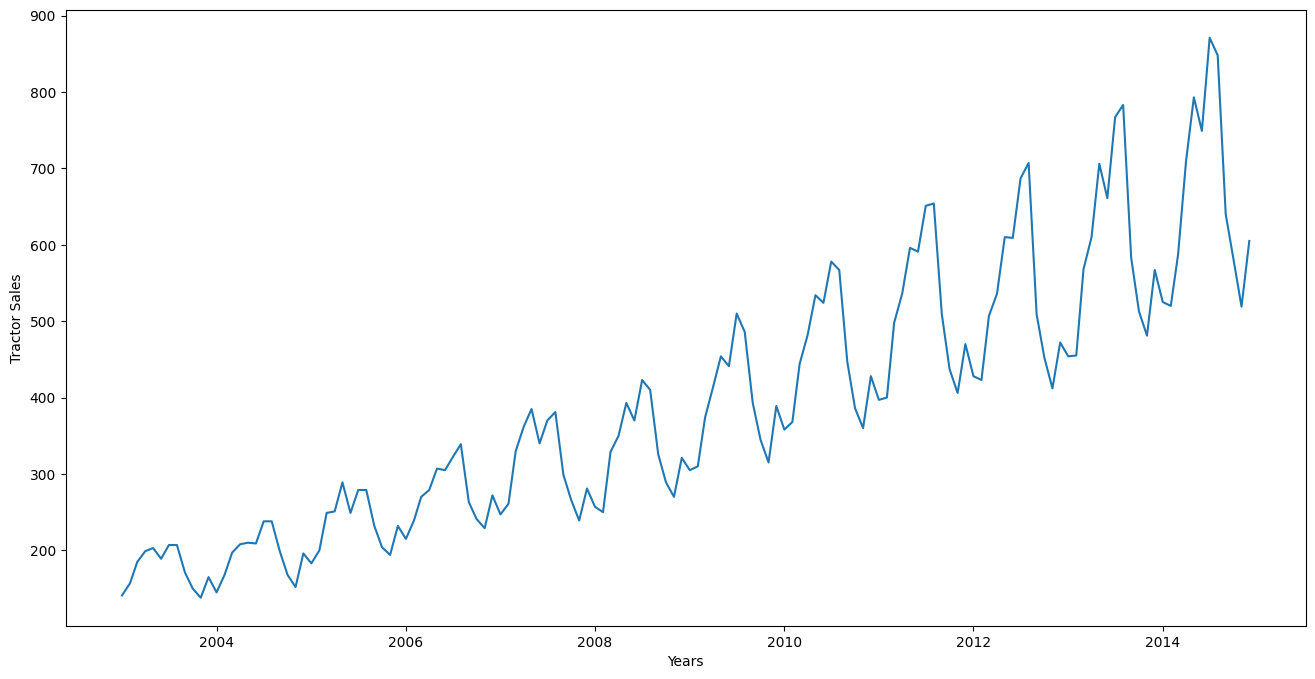

In [166]:
sales_ts = tractor_sales_df['Tractor-Sales']
plt.figure(figsize=(16, 8))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')


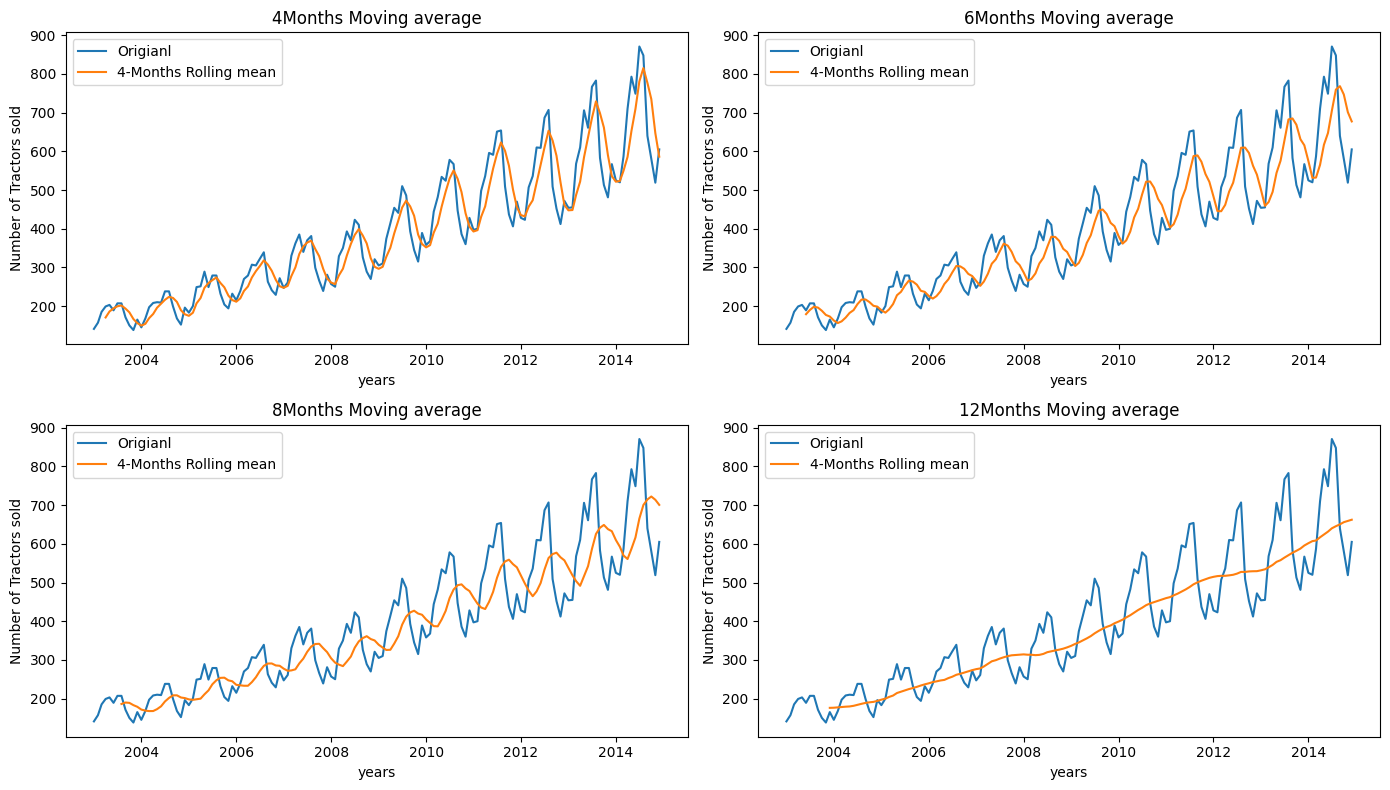

In [167]:
fig, axes = plt.subplots(2, 2, sharey = False, sharex = False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label = 'Origianl')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label = '4-Months Rolling mean')
axes[0][0].set_xlabel("years")
axes[0][0].set_ylabel('Number of Tractors sold')
axes[0][0].set_title("4Months Moving average")
axes[0][0].legend(loc = 'best')


axes[0][1].plot(sales_ts.index, sales_ts, label = 'Origianl')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label = '4-Months Rolling mean')
axes[0][1].set_xlabel("years")
axes[0][1].set_ylabel('Number of Tractors sold')
axes[0][1].set_title("6Months Moving average")
axes[0][1].legend(loc = 'best')

axes[1][0].plot(sales_ts.index, sales_ts, label = 'Origianl')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label = '4-Months Rolling mean')
axes[1][0].set_xlabel("years")
axes[1][0].set_ylabel('Number of Tractors sold')
axes[1][0].set_title("8Months Moving average")
axes[1][0].legend(loc = 'best')

axes[1][1].plot(sales_ts.index, sales_ts, label = 'Origianl')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label = '4-Months Rolling mean')
axes[1][1].set_xlabel("years")
axes[1][1].set_ylabel('Number of Tractors sold')
axes[1][1].set_title("12Months Moving average")
axes[1][1].legend(loc = 'best')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Rolling Mean and Standar Deviation')

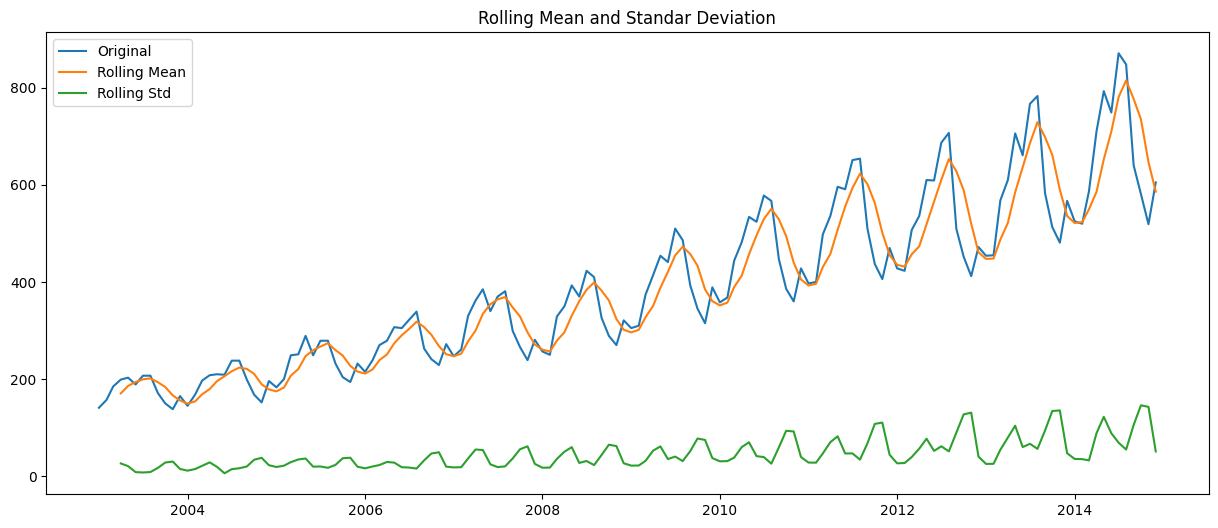

In [168]:
rollmean = sales_ts.rolling(window = 4).mean()
rollstd = sales_ts.rolling(window = 4).std()

orig = plt.plot(sales_ts, label = 'Original')
mean = plt.plot(rollmean, label = 'Rolling Mean')
std = plt.plot(rollstd, label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Standar Deviation')

In [169]:
# Dickey  - Fuller test to check for stationarity

df_test = adfuller(sales_ts)
print('DF test Stats id %3.3f' %df_test[0])
print('DF test p-value is %1.4f' %df_test[1])

DF test Stats id 1.109
DF test p-value is 0.9953


#### Seasonality - Time Series Decomposition

In [170]:
monthly_sales_data = pd.pivot_table(tractor_sales_df, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data

Year    2003   2004   2005   2006   2007   2008   2009   2010   2011   2012  \
Month                                                                         
Apr    199.0  208.0  251.0  279.0  362.0  350.0  414.0  482.0  536.0  536.0   
Aug    207.0  238.0  279.0  339.0  381.0  410.0  486.0  567.0  654.0  707.0   
Dec    165.0  196.0  232.0  272.0  281.0  321.0  389.0  428.0  470.0  472.0   
Feb    157.0  168.0  200.0  239.0  261.0  250.0  310.0  368.0  400.0  423.0   
Jan    141.0  145.0  183.0  215.0  247.0  257.0  305.0  358.0  397.0  428.0   
Jul    207.0  238.0  279.0  322.0  370.0  423.0  510.0  578.0  651.0  687.0   
Jun    189.0  209.0  249.0  305.0  340.0  370.0  441.0  524.0  591.0  609.0   
Mar    185.0  197.0  249.0  270.0  330.0  329.0  374.0  444.0  498.0  507.0   
May    203.0  210.0  289.0  307.0  385.0  393.0  454.0  534.0  596.0  610.0   
Nov    138.0  152.0  194.0  229.0  239.0  270.0  315.0  360.0  406.0  412.0   
Oct    150.0  168.0  204.0  241.0  266.0  289.0  345.0  386.0  437.0  452.0   
Sep    171.0  199.0  232.0  263.0  299.0  326.0  393.0  447.0  509.0  509.0   

Year    2013   2014  
Month                
Apr    610.0  710.0  
Aug    783.0  848.0  
Dec    567.0  605.0  
Feb    455.0  520.0  
Jan    454.0  525.0  
Jul    767.0  871.0  
Jun    661.0  749.0  
Mar    568.0  587.0  
May    706.0  793.0  
Nov    481.0  519.0  
Oct    513.0  581.0  
Sep    583.0  640.0

In [171]:
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year    2003   2004   2005   2006   2007   2008   2009   2010   2011   2012  \
Month                                                                         
Jan    141.0  145.0  183.0  215.0  247.0  257.0  305.0  358.0  397.0  428.0   
Feb    157.0  168.0  200.0  239.0  261.0  250.0  310.0  368.0  400.0  423.0   
Mar    185.0  197.0  249.0  270.0  330.0  329.0  374.0  444.0  498.0  507.0   
Apr    199.0  208.0  251.0  279.0  362.0  350.0  414.0  482.0  536.0  536.0   
May    203.0  210.0  289.0  307.0  385.0  393.0  454.0  534.0  596.0  610.0   
Jun    189.0  209.0  249.0  305.0  340.0  370.0  441.0  524.0  591.0  609.0   
Jul    207.0  238.0  279.0  322.0  370.0  423.0  510.0  578.0  651.0  687.0   
Aug    207.0  238.0  279.0  339.0  381.0  410.0  486.0  567.0  654.0  707.0   
Sep    171.0  199.0  232.0  263.0  299.0  326.0  393.0  447.0  509.0  509.0   
Oct    150.0  168.0  204.0  241.0  266.0  289.0  345.0  386.0  437.0  452.0   
Nov    138.0  152.0  194.0  229.0  239.0  270.0  315.0  360.0  406.0  412.0   
Dec    165.0  196.0  232.0  272.0  281.0  321.0  389.0  428.0  470.0  472.0   

Year    2013   2014  
Month                
Jan    454.0  525.0  
Feb    455.0  520.0  
Mar    568.0  587.0  
Apr    610.0  710.0  
May    706.0  793.0  
Jun    661.0  749.0  
Jul    767.0  871.0  
Aug    783.0  848.0  
Sep    583.0  640.0  
Oct    513.0  581.0  
Nov    481.0  519.0  
Dec    567.0  605.0

<Axes: xlabel='Month'>

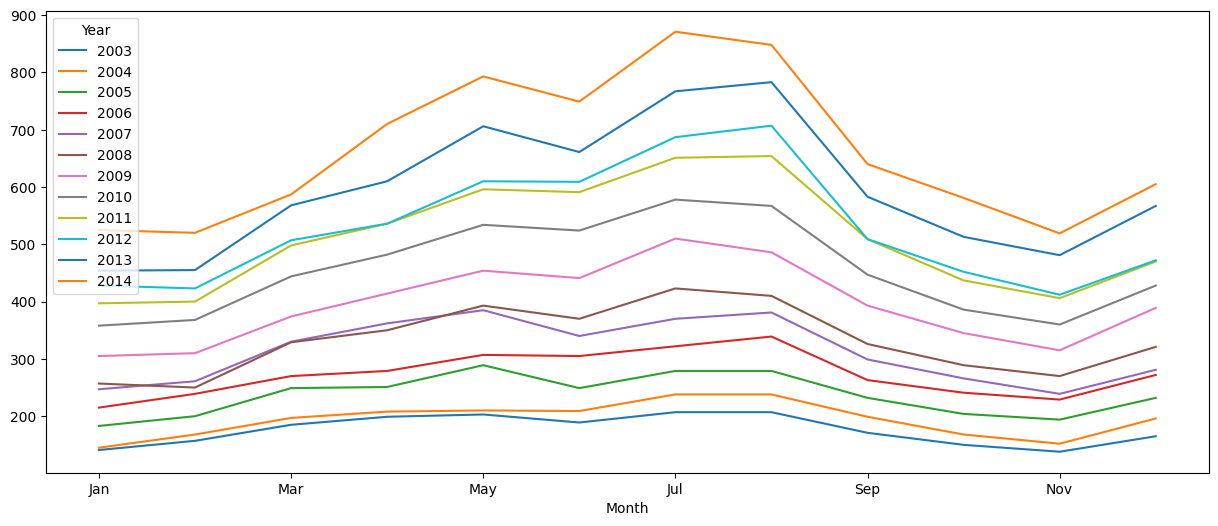

In [172]:
monthly_sales_data.plot()

In [173]:
yearly_sales_data = pd.pivot_table(tractor_sales_df, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Year                                                                          
2003   141.0  157.0  185.0  199.0  203.0  189.0  207.0  207.0  171.0  150.0   
2004   145.0  168.0  197.0  208.0  210.0  209.0  238.0  238.0  199.0  168.0   
2005   183.0  200.0  249.0  251.0  289.0  249.0  279.0  279.0  232.0  204.0   
2006   215.0  239.0  270.0  279.0  307.0  305.0  322.0  339.0  263.0  241.0   
2007   247.0  261.0  330.0  362.0  385.0  340.0  370.0  381.0  299.0  266.0   
2008   257.0  250.0  329.0  350.0  393.0  370.0  423.0  410.0  326.0  289.0   
2009   305.0  310.0  374.0  414.0  454.0  441.0  510.0  486.0  393.0  345.0   
2010   358.0  368.0  444.0  482.0  534.0  524.0  578.0  567.0  447.0  386.0   
2011   397.0  400.0  498.0  536.0  596.0  591.0  651.0  654.0  509.0  437.0   
2012   428.0  423.0  507.0  536.0  610.0  609.0  687.0  707.0  509.0  452.0   
2013   454.0  455.0  568.0  610.0  706.0  661.0  767.0  783.0  583.0  513.0   
2014   525.0  520.0  587.0  710.0  793.0  749.0  871.0  848.0  640.0  581.0   

Month    Nov    Dec  
Year                 
2003   138.0  165.0  
2004   152.0  196.0  
2005   194.0  232.0  
2006   229.0  272.0  
2007   239.0  281.0  
2008   270.0  321.0  
2009   315.0  389.0  
2010   360.0  428.0  
2011   406.0  470.0  
2012   412.0  472.0  
2013   481.0  567.0  
2014   519.0  605.0

<Axes: xlabel='Year'>

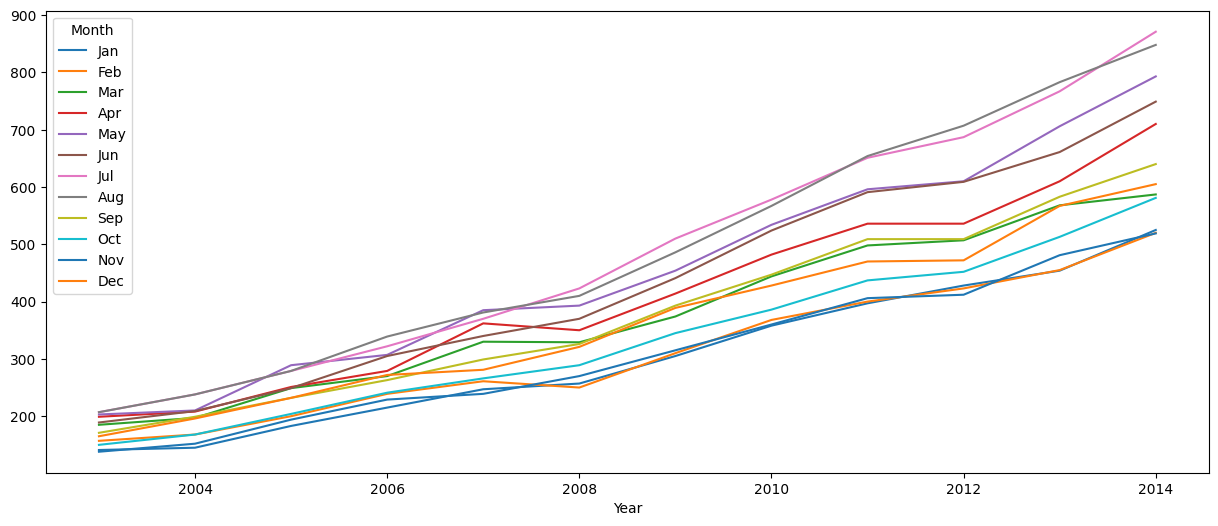

In [174]:
yearly_sales_data.plot()

<Axes: >

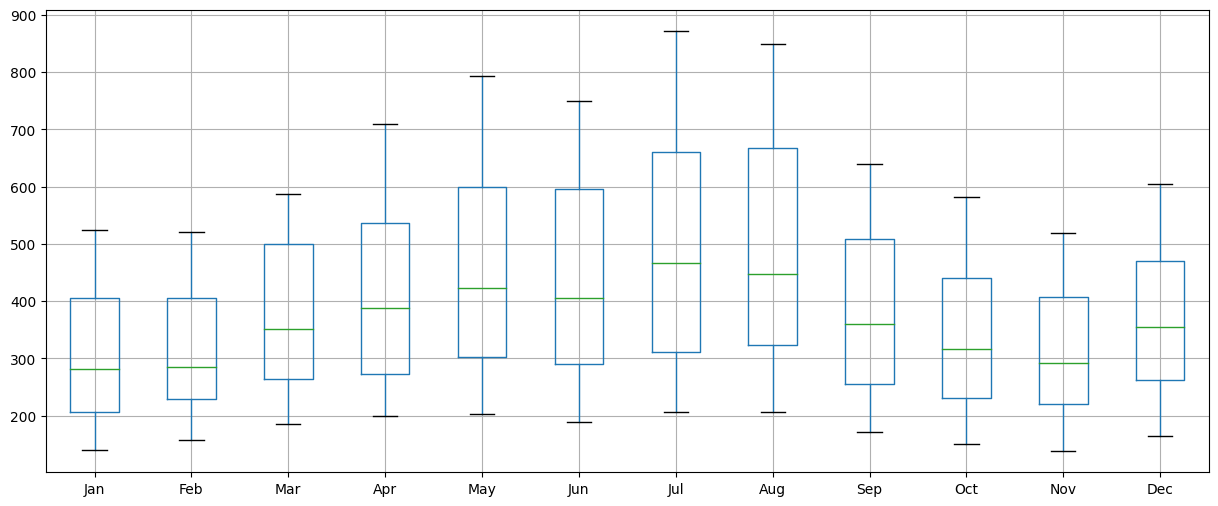

In [175]:
yearly_sales_data.boxplot()

#### Time Series Decomposition

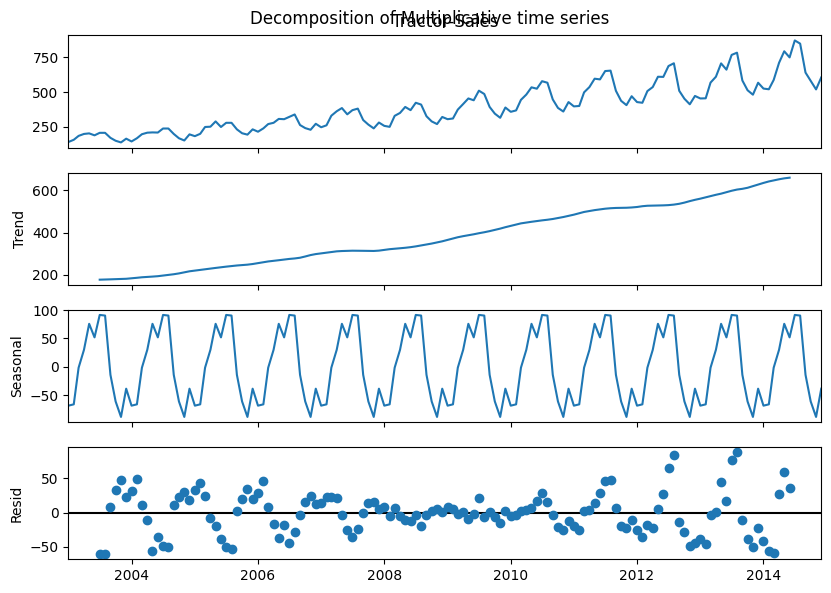

In [176]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model = 'ultiplicative')

fig = decomposition.plot()
fig.set_figwidth(8)
fig.set_figheight(6)
fig.suptitle('Decomposition of Multiplicative time series')
plt.show()

Text(0, 0.5, 'Tractor Sales')

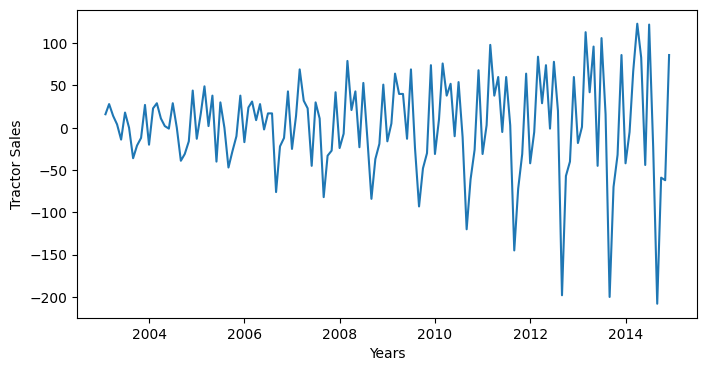

In [177]:
plt.figure(figsize=(8, 4))
plt.plot(sales_ts.diff(periods = 1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Text(0, 0.5, 'Log(Tractor Sales)')

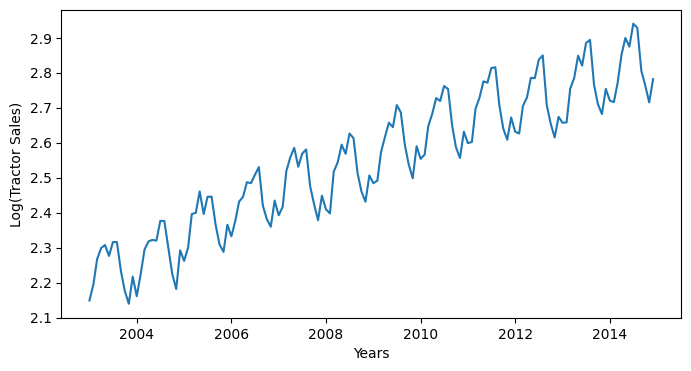

In [178]:
plt.figure(figsize=(8, 4))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log(Tractor Sales)')

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

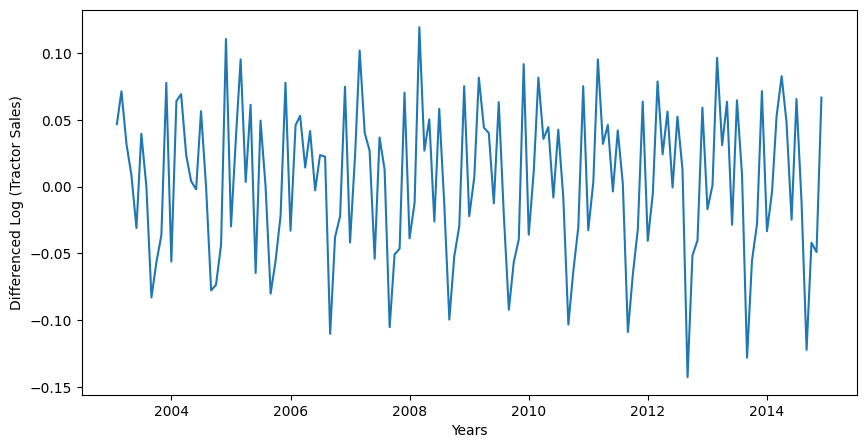

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

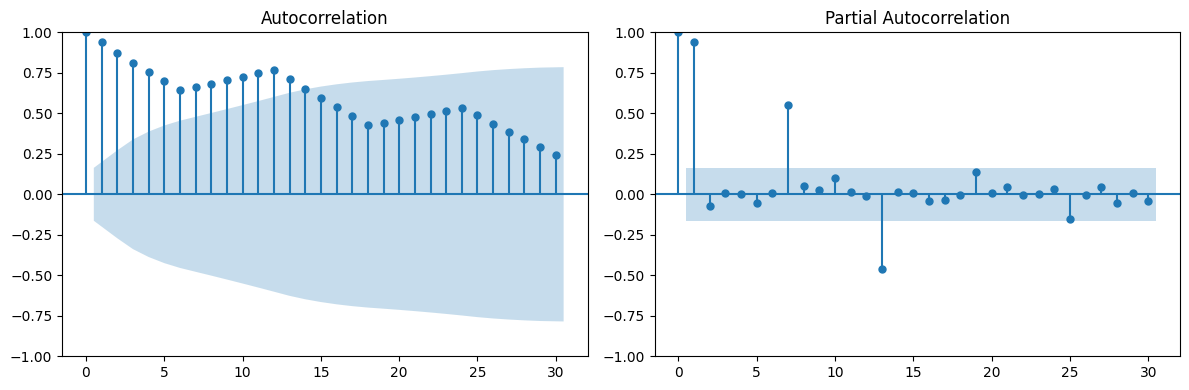

In [180]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_ts_log, lags=30, ax=axes[1])
plt.tight_layout()

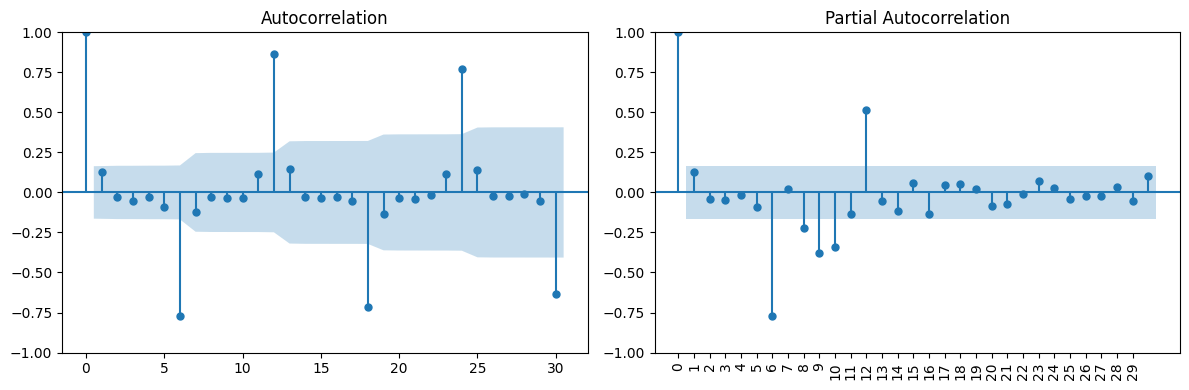

In [181]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

In [182]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [183]:
seasonal_pdq


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [184]:
#Separate data into train and test
tractor_sales_df['date'] = tractor_sales_df.index
train = tractor_sales_df[tractor_sales_df.index < '2013-01-01']
test = tractor_sales_df[tractor_sales_df.index >= '2013-01-01']
train_sales_ts_log = np.log10(train['Tractor-Sales'])

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [185]:
best_model = sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77486D+00    |proj g|=  1.59704D+01


 This problem is unconstrained.



At iterate    5    f= -2.45821D+00    |proj g|=  6.42944D-01

At iterate   10    f= -2.48260D+00    |proj g|=  1.64162D+01

At iterate   15    f= -2.53020D+00    |proj g|=  4.09940D-01

At iterate   20    f= -2.53104D+00    |proj g|=  1.50046D+00

At iterate   25    f= -2.53125D+00    |proj g|=  3.71769D-03

At iterate   30    f= -2.53177D+00    |proj g|=  1.04763D-01

At iterate   35    f= -2.53371D+00    |proj g|=  4.91348D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     68      1     0     0   1.503D-02  -2.534D+00
  F =  -2.5337114060228472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [186]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 304.045
Date:                            Thu, 15 Aug 2024   AIC                           -600.091
Time:                                    07:12:32   BIC                           -588.974
Sample:                                01-01-2003   HQIC                          -595.577
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2954      0.079     -3.717      0.000      -0.451      -0.140
ar.S.L12       0.9920      0.007   

In [187]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
pred99 = best_results.get_forecast(steps=24, alpha=0.1)

# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

testCopy

Month  Year  Tractor-Sales       date  sales_ts_forecasted
2013-01-01   Jan  2013            454 2013-01-01           438.773037
2013-02-01   Feb  2013            455 2013-02-01           440.552651
2013-03-01   Mar  2013            568 2013-03-01           534.202408
2013-04-01   Apr  2013            610 2013-04-01           570.815863
2013-05-01   May  2013            706 2013-05-01           638.592648
2013-06-01   Jun  2013            661 2013-06-01           630.007981
2013-07-01   Jul  2013            767 2013-07-01           703.492700
2013-08-01   Aug  2013            783 2013-08-01           709.207744
2013-09-01   Sep  2013            583 2013-09-01           538.593574
2013-10-01   Oct  2013            513 2013-10-01           473.224965
2013-11-01   Nov  2013            481 2013-11-01           436.037556
2013-12-01   Dec  2013            567 2013-12-01           506.398821
2014-01-01   Jan  2014            525 2014-01-01           468.552904
2014-02-01   Feb  2014            520 2014-02-01           470.438049
2014-03-01   Mar  2014            587 2014-03-01           569.560670
2014-04-01   Apr  2014            710 2014-04-01           608.274465
2014-05-01   May  2014            793 2014-05-01           679.887683
2014-06-01   Jun  2014            749 2014-06-01           670.820598
2014-07-01   Jul  2014            871 2014-07-01           748.404110
2014-08-01   Aug  2014            848 2014-08-01           754.435112
2014-09-01   Sep  2014            640 2014-09-01           574.204830
2014-10-01   Oct  2014            581 2014-10-01           505.037249
2014-11-01   Nov  2014            519 2014-11-01           465.655088
2014-12-01   Dec  2014            605 2014-12-01           540.147991

In [188]:
# Compute the root mean square error
mse = ((testCopy['Tractor-Sales'] - testCopy['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))


The Root Mean Squared Error of our forecasts is 65.665


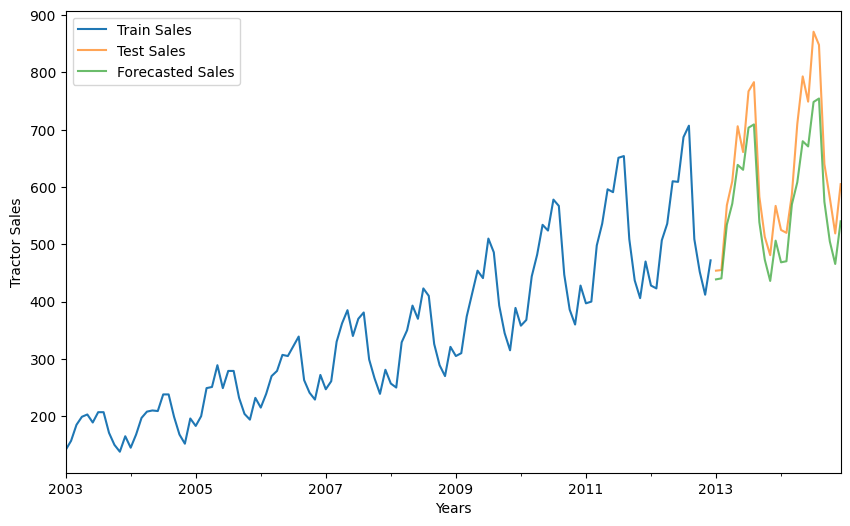

In [189]:
axis = train['Tractor-Sales'].plot(label='Train Sales', figsize=(10, 6))
testCopy['Tractor-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [190]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()


n_steps = 36
idx = pd.date_range(data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
2014-12-01  438.773037   407.837017   472.055675   407.837017   472.055675
2015-01-01  440.552651   402.860031   481.771889   402.860031   481.771889
2015-02-01  534.202408   481.814294   592.286730   481.814294   592.286730
2015-03-01  570.815863   508.623848   640.612412   508.623848   640.612412
2015-04-01  638.592648   562.802359   724.589305   562.802359   724.589305

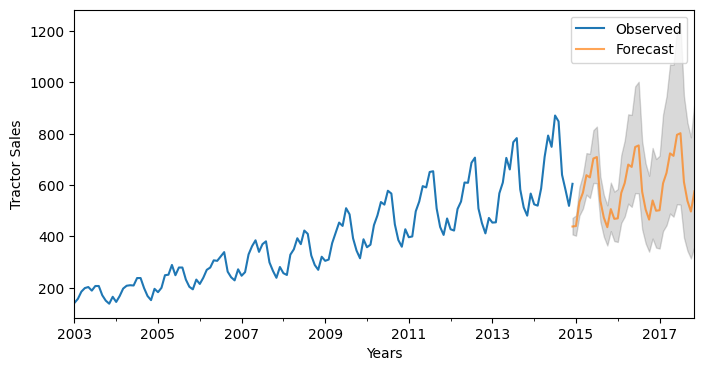

In [191]:
# plot the forecast along with the confidence band

axis = sales_ts.plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

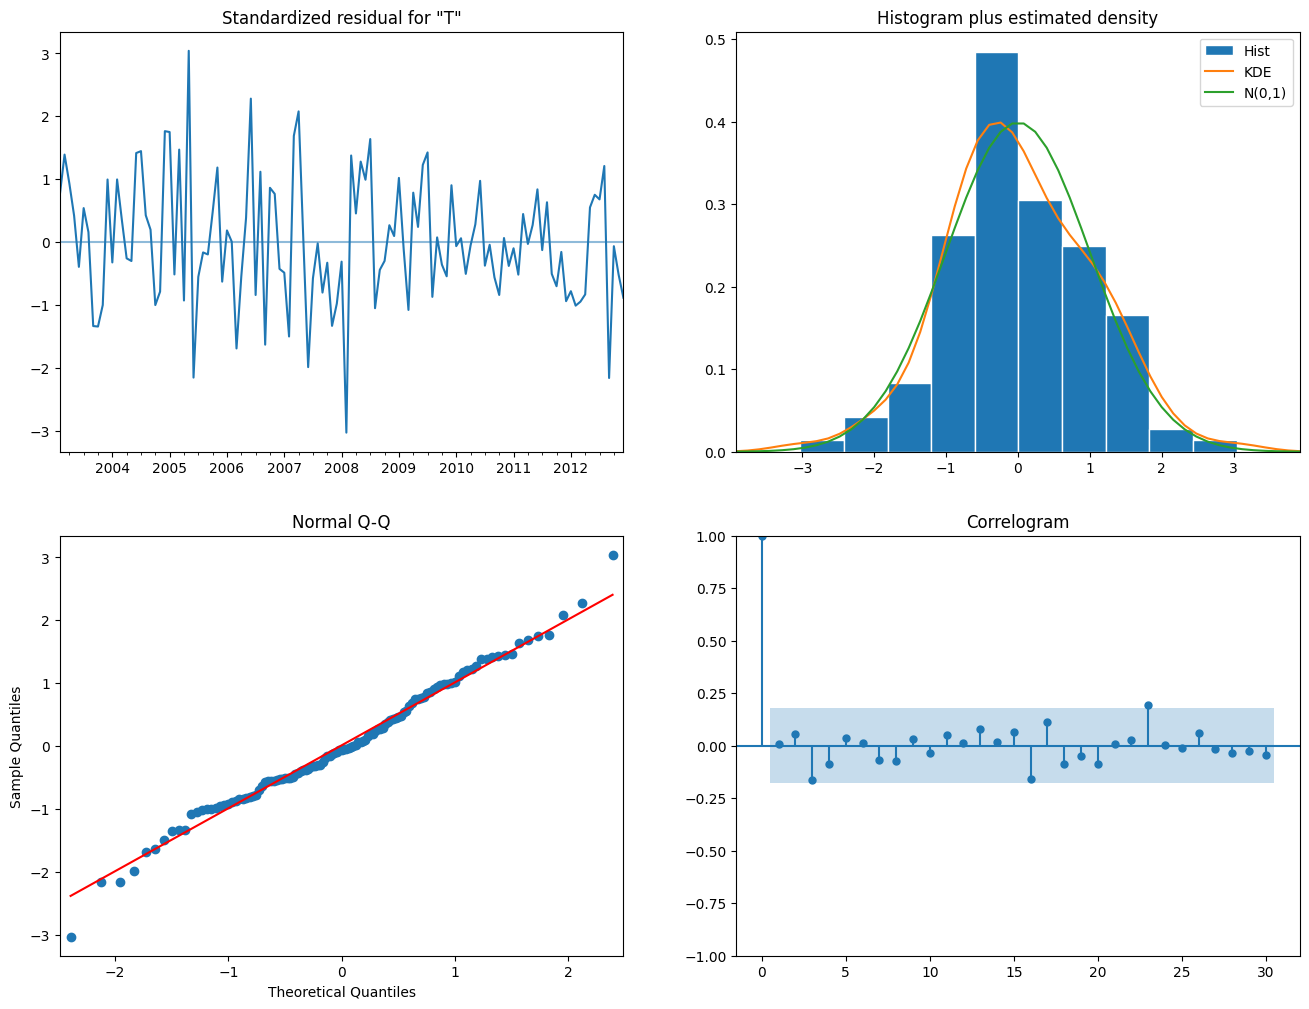

In [192]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

# References

- https://machinelearningmastery.com/5-tips-for-getting-started-with-time-series-analysis/
- https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
- https://www.projectpro.io/recipes/deal-with-missing-values-in-timeseries-in-python
- https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
- https://people.duke.edu/~rnau/411diff.htm
- https://www.kaggle.com/code/saurav9786/time-series-tutorial